**Import libraries for data manipulation and analysis.**

In [ ]:
 # It provides data structures like DataFrames that allow to work with structured data efficiently.
import pandas as pd

# A library for numerical computations.
import numpy as np

# A plotting library that provides a wide range of functions for creating static, animated, and interactive visualizations.
from matplotlib import pyplot as plt

# A module from matplotlib allows for custom formatting of tick labels on plots
import matplotlib.ticker as ticker

# A library to perform 1-dimensional interpolation of data.
from scipy.interpolate import interp1d

# Generating random numbers or selecting random elements.
import random

# Implements binary protocols for serializing and de-serializing a Python object structure.
import pickle

import os

import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

**Upload train data**

In [ ]:
train_norm_directory = 'C:/Users/Idan Lichter/OneDrive/Desktop/study/3rd year/Final Project/norm processed dfs/norm_dfs.pkl'
train_org_directory = "C:/Users/Idan Lichter/OneDrive/Desktop/study/3rd year/Final Project/org processed dfs/original_dfs.pkl"
with open(train_norm_directory, 'rb') as f:
    train_norm_dfs = pickle.load(f)
with open(train_org_directory, 'rb') as f:
    train_original_dfs = pickle.load(f)

**Upload test data**

In [ ]:
test_norm_directory = 'C:/Users/Idan Lichter/OneDrive/Desktop/study/3rd year/Final Project/test norm processed dfs/test_norm_dfs.pkl'
test_org_directory = 'C:/Users/Idan Lichter/OneDrive/Desktop/study/3rd year/Final Project/test org processed dfs/test_original_dfs.pkl'
with open(test_norm_directory, 'rb') as f:
    test_norm_dfs = pickle.load(f)
with open(test_org_directory, 'rb') as f:
    test_original_dfs = pickle.load(f)

**Upload meta data**

In [ ]:
meta_directory = 'C:/Users/Idan Lichter/OneDrive/Desktop/study/3rd year/Final Project/meta data/Processed_Patients_Meta_Data_V2.pkl'
with open(meta_directory, 'rb') as f:
    meta_df = pickle.load(f)

**Add Baseline data**

In [ ]:
def add_baseline_to_df(original_dfs, meta_df):
    """
    Add BL_MAP values to the DataFrames in the list based on matching IDs.

    Parameters:
    - original_dfs: list of DataFrames, each contain processed ppg information.
    - meta_df: DataFrame of meta data of the patients.

    Returns:
    - none
    """
    # Iterate over each row in meta_data_df
    for index, row in meta_df.iterrows():
        current_id = row['patient_ID']
        current_bl_map = row['BL_MAP']
        current_bl_dbp = row['BL_DBP']
        current_bl_sbp = row['BL_SBP']

        # Iterate through the list of original DataFrames
        for df in original_dfs:
            # Check if the current DataFrame contains the matching ID
            if current_id in df['ID'].values:
                # Add a new column 'BL_MAP' with the value from meta_df
                df.loc[df['ID'] == current_id, 'BL_MAP'] = current_bl_map
                df.loc[df['ID'] == current_id, 'BL_DBP'] = current_bl_dbp
                df.loc[df['ID'] == current_id, 'BL_SBP'] = current_bl_sbp

In [ ]:
#apply the function on train and test:
add_baseline_to_df(train_original_dfs, meta_df)
add_baseline_to_df(test_original_dfs, meta_df)

**find the minimum number of cycles in our windows**

In [ ]:
cycles_number_list = []
for df in original_dfs:
    number = int(df['Num_of_Cycles_in_df'][0])
    cycles_number_list.append(number)
min_cycles_number = min(cycles_number_list)
print(min_cycles_number)

46


**cycles detection for features**

In [ ]:
def Define_Cycle(data):
    """
    This function takes a DataFrame containing PPG data with identified peaks and defines the cycles in the segment based on the last peak (min or max).

    Parameters:
    data (DataFrame): A DataFrame containing PPG data with a 'peak' column indicating the type of peak (min or max).

    Returns:
    start_peak (bool): A boolean value indicating whether the starting peak is a minimum (True) or maximum (False).
    cycles_data (DataFrame): A subset of the input data containing only the cycles in the segment.
    """
    # Find all the indices of the peaks in the segment
    peaks = data[data['peak'].notna()].copy()

    # Determine the starting peak based on the last peak type
    if peaks.iloc[-1]['peak'] == 'Min':
        start_ind = peaks[peaks['peak'] == 'Min'].index[0]
        start_peak = True
    else:
        start_ind = peaks[peaks['peak'] == 'Max'].index[0]
        start_peak = False

    # Return only the cycles in the segment starting from the identified peak
    cycles_data = data.loc[start_ind:]

    return start_peak, cycles_data

In [ ]:
def find_cycle_boundaries(df):
    """
    Find the start and end indices of each cycle based on the 'Min' tags in the 'peak' column.

    Parameters:
    df (DataFrame): The DataFrame containing the 'peak' column with 'Min', 'Max', and 'nan' values.

    Returns:
    List of tuples where each tuple represents the start and end indices of a cycle.
    """
    min_indices = df[df['peak'] == 'Min'].index.tolist()
    cycle_boundaries = [(min_indices[i], min_indices[i+1] - 1) for i in range(len(min_indices) - 1)]

    return cycle_boundaries

**Group feature 1 - Amplitude area**

this first group of features is the area under the curve.

This area reflacts the changes in blood vessel tone and is therfore an important features for predicting BP

In [ ]:
def Calc_Area_Feature(df, x_name, y_name, start_idx, end_idx):
    """
    This function calculates the area under the curve of a specific cycle, which represents the pulse rising time.

    Parameters:
    df (DataFrame): The original DataFrame containing PPG data with corresponding x and y values.
    x_name (str): The column name in df representing the x-axis values.
    y_name (str): The column name in df representing the y-axis values.
    start_idx (int): The starting index of the cycle.
    end_idx (int): The ending index of the cycle.

    Returns:
    area_cycle (float): The calculated area for the specified cycle.
    """
    cycle = df.iloc[start_idx:end_idx + 1]
    if cycle.empty or cycle.shape[0] < 2:
        area_cycle = 0.0
    else:
        dx = np.gradient(cycle[x_name])
        area_cycle = np.sum(dx * cycle[y_name]).round(3)

    return area_cycle

In [ ]:
def Group_Feature_1_AREA(norm_df, org_df, features, num_sampels):
    """
    This function creates the group feature 1: Area for a specific segment and adds it to the features DataFrame.

    Parameters:
    norm_df (DataFrame): The normalized DataFrame for the entire dataset.
    org_df (DataFrame): The DataFrame for the entire dataset.
    features (DataFrame): The DataFrame to which the feature columns will be added.
    num_sampels (int): The number of samples (cycles) to consider.
    """
    org_df = org_df.copy()
    org_df.loc[:, 'Index_Column'] = org_df.index

    # Find cycle boundaries
    cycle_boundaries = find_cycle_boundaries(norm_df)

    # Calculate the area for each cycle and store it in lists
    norm_area_all_cycles = [
        Calc_Area_Feature(norm_df, 'norm_time (x)', 'norm_data (y)', start_idx, end_idx)
        for start_idx, end_idx in cycle_boundaries
    ]
    area_all_cycles = [
        Calc_Area_Feature(org_df, 'Index_Column', 'HiDeTr_PLETH', start_idx, end_idx)
        for start_idx, end_idx in cycle_boundaries
    ]

    # Average of all the cycles' areas in each part
    features['F1_Area_Avg_Norm'] = np.mean(norm_area_all_cycles).round(6)
    features['F1_Area_Avg'] = np.mean(area_all_cycles).round(6)

    # Std of all the cycles' areas in each part
    features['F1_Area_Std_Norm'] = np.std(norm_area_all_cycles).round(6)
    features['F1_Area_Std'] = np.std(area_all_cycles).round(6)

    # Sample specific cycles based on sampels_list
    num_cycles = len(cycle_boundaries)
    sampels_list = np.linspace(0, num_cycles-1, num_sampels, dtype=int).tolist()

    # Initialize lists to store area values for sampled cycles
    norm_area_sampel_list = []
    area_sampel_list = []

    # Use a consistent index for feature names
    for sample_idx, i in enumerate(sampels_list):
        start_idx, end_idx = cycle_boundaries[i]
        norm_area = Calc_Area_Feature(norm_df, 'norm_time (x)', 'norm_data (y)', start_idx, end_idx)
        area = Calc_Area_Feature(org_df, 'Index_Column', 'HiDeTr_PLETH', start_idx, end_idx)

        # Store the area values in lists
        norm_area_sampel_list.append(norm_area)
        area_sampel_list.append(area)

        # Store individual cycle areas in features with a consistent name
        features[f'F1_Area_cycle_Norm_Sample_{sample_idx+1}'] = norm_area
        features[f'F1_Area_cycle_Sample_{sample_idx+1}'] = area

    # Average of the sampled cycles' areas in each part
    features[f'F1_Area_Avg_sampels_Norm'] = np.mean(norm_area_sampel_list).round(6)
    features[f'F1_Area_Avg_sampels'] = np.mean(area_sampel_list).round(6)

    # Std of the sampled cycles' areas in each part
    features[f'F1_Area_Std_sampels_Norm'] = np.std(norm_area_sampel_list).round(6)
    features[f'F1_Area_Std_sampels'] = np.std(area_sampel_list).round(6)

**Group feature 2: Width Amplitude**

the second set of features is the amplitude width so set the amplitude width at 25%, 50% and 75%. they indicate the resistance of system tools.

The set of width features were extracted from the normalized set only.

In [ ]:
def Width(norm_df, peaks_index, i, high):
    """
    This function calculates the width of the amplitude according to a given parameter "high".

    Parameters:
    norm_df (DataFrame): A DataFrame containing normalized PPG data with 'norm_data (y)' and 'norm_time (x)' columns.
    peaks_index (ndarray): An array of indices representing the peaks in the PPG data.
    i (int): The index of the current peak.
    high (float): The value of the Y-coordinate to find the width at.

    Returns:
    width (float): The calculated width of the amplitude.
    """

    # Find the parts from peak to peak
    c1 = norm_df.iloc[peaks_index[i]:peaks_index[i+1]+1]
    c2 = norm_df.iloc[peaks_index[i+1]:peaks_index[i+2]+1]
    start_index = peaks_index[i]
    end_index = peaks_index[i+2] + 1

    # Check if c1 or c2 is empty or has insufficient data
    if c1.empty or c2.empty or c1.shape[0] < 2 or c2.shape[0] < 2:
        print(f"Insufficient data between peaks {i} and {i+2}, skipping width calculation.")
        return np.nan  # Return NaN or some placeholder value

    # Create interpolation functions
    try:
        f_c1 = interp1d(c1['norm_data (y)'], c1['norm_time (x)'])
        f_c2 = interp1d(c2['norm_data (y)'], c2['norm_time (x)'])


        # Find x-coordinate where y = high
        width = f_c2(high) - f_c1(high)
        width = round(width, 4)

        #plt.figure(figsize=(20,5))
        #plt.plot(norm_df['norm_time (x)'][start_index:end_index], norm_df['norm_data (y)'][start_index:end_index])
        #plt.title('good cycle')
        #plt.show()

    except ValueError as e:
        #plt.figure(figsize=(20,5))
        #plt.plot(norm_df['norm_time (x)'][start_index:end_index], norm_df['norm_data (y)'][start_index:end_index])
        #plt.title('bad cycle')
        #plt.show()
        print(f"ValueError encountered: {e}")
        width = np.nan  # Use NaN or some placeholder value

    return width

In [ ]:
def Width_feature(norm_df):
    """
    This function finds the width (25%, 50%, 75%) for each cycle in a window and creates arrays for each width.

    Parameters:
    norm_df (DataFrame): A DataFrame containing normalized PPG data with 'norm_data(y)' and 'norm_time(X)' columns.

    Returns:
    width_25_cycles_arr (ndarray): An array of widths at 25% of the amplitude for each cycle in the segment.
    width_50_cycles_arr (ndarray): An array of widths at 50% of the amplitude for each cycle in the segment.
    width_75_cycles_arr (ndarray): An array of widths at 75% of the amplitude for each cycle in the segment.
    """
    # Find the index of the peaks in the segment
    peaks_index = norm_df[norm_df['peak'].isin(['Min', 'Max'])].index.tolist()
    width_25_cycles_arr = np.array([])
    width_50_cycles_arr = np.array([])
    width_75_cycles_arr = np.array([])

    # For every cycle, find the width at 25%, 50%, and 75% of the amplitude
    for i in range(0, len(peaks_index)-2, 2):
        width_25 = Width(norm_df, peaks_index, i, 0.25)
        width_50 = Width(norm_df, peaks_index, i, 0.50)
        width_75 = Width(norm_df, peaks_index, i, 0.75)
        width_25_cycles_arr = np.append(width_25_cycles_arr, width_25)
        width_50_cycles_arr = np.append(width_50_cycles_arr, width_50)
        width_75_cycles_arr = np.append(width_75_cycles_arr, width_75)

    return width_25_cycles_arr, width_50_cycles_arr, width_75_cycles_arr

In [ ]:
def Avg_Width_Part(width_25_cycles, width_50_cycles, width_75_cycles):
    """
    This function calculates the average width of the cycles in a segment based on the 25%, 50%, and 75% widths.

    Parameters:
    width_25_cycles (ndarray): Array containing the widths at 25% for each cycle.
    width_50_cycles (ndarray): Array containing the widths at 50% for each cycle.
    width_75_cycles (ndarray): Array containing the widths at 75% for each cycle.

    Returns:
    tuple: A tuple containing the average widths at 25%, 50%, and 75% respectively.
    """
    avg_width_25 = np.mean(width_25_cycles).round(6)
    avg_width_50 = np.mean(width_50_cycles).round(6)
    avg_width_75 = np.mean(width_75_cycles).round(6)

    return avg_width_25, avg_width_50, avg_width_75

In [ ]:
def Std_Width_Part(width_25_cycles, width_50_cycles, width_75_cycles):
    """
    This function calculates the standard deviation of the widths of the cycles in a segment based on the 25%, 50%, and 75% widths.

    Parameters:
    width_25_cycles (ndarray): Array containing the widths at 25% for each cycle.
    width_50_cycles (ndarray): Array containing the widths at 50% for each cycle.
    width_75_cycles (ndarray): Array containing the widths at 75% for each cycle.

    Returns:
    tuple: A tuple containing the standard deviation of the widths at 25%, 50%, and 75% respectively.
    """
    std_width_25 = width_25_cycles.std().round(6)
    std_width_50 = width_50_cycles.std().round(6)
    std_width_75 = width_75_cycles.std().round(6)

    return std_width_25, std_width_50, std_width_75

In [ ]:
def Group_Feature_2_WIDTH(norm_df, features, num_sampels):
    """
    Calculates width-related group features for each segment based on the normalized data.

    Parameters:
    norm_df (DataFrame): Overall normalized DataFrame.
    features (DataFrame): DataFrame to store the calculated features.
    num_sampels (int): The number of cycles to sample.
    Returns:
    None
    """
    # Calculate the width features
    width_25_cycles, width_50_cycles, width_75_cycles = Width_feature(norm_df)

    # Calculate average and standard deviation of width cycles for all cycles
    avg_width_25, avg_width_50, avg_width_75 = Avg_Width_Part(width_25_cycles, width_50_cycles, width_75_cycles)
    std_width_25, std_width_50, std_width_75 = Std_Width_Part(width_25_cycles, width_50_cycles, width_75_cycles)

    # Fill the average and standard deviation of the widths at each percentage (25%, 50%, 75%) across all cycles
    all_avg_width_part = np.array([avg_width_25, avg_width_50, avg_width_75])
    all_std_width_part = np.array([std_width_25, std_width_50, std_width_75])

    for i, high in enumerate([25, 50, 75]):
        features[f'F2_Avg_Width_{high}(%)_Norm'] = all_avg_width_part[i]
        features[f'F2_Std_Width_{high}(%)_Norm'] = all_std_width_part[i]

    # Sample specific cycles based on num_sampels
    num_cycles = len(width_25_cycles)
    sampels_list = np.linspace(0, num_cycles-1, int(num_sampels), dtype=int).tolist()

    # Initialize lists to store sampled width values
    sampled_width_25_cycles = []
    sampled_width_50_cycles = []
    sampled_width_75_cycles = []

    # Use a consistent index for feature names
    for sample_idx, i in enumerate(sampels_list):
        sampled_width_25_cycles.append(width_25_cycles[i])
        sampled_width_50_cycles.append(width_50_cycles[i])
        sampled_width_75_cycles.append(width_75_cycles[i])

        # Store individual sampled widths in features with a consistent name
        features[f'F2_Width_25_cycle_Norm_Sample_{sample_idx+1}'] = width_25_cycles[i]
        features[f'F2_Width_50_cycle_Norm_Sample_{sample_idx+1}'] = width_50_cycles[i]
        features[f'F2_Width_75_cycle_Norm_Sample_{sample_idx+1}'] = width_75_cycles[i]

    # Calculate average and standard deviation of the sampled widths
    features[f'F2_Width_25_Avg_sampels_Norm'] = np.nanmean(sampled_width_25_cycles).round(6)
    features[f'F2_Width_50_Avg_sampels_Norm'] = np.nanmean(sampled_width_50_cycles).round(6)
    features[f'F2_Width_75_Avg_sampels_Norm'] = np.nanmean(sampled_width_75_cycles).round(6)

    features[f'F2_Width_25_Std_sampels_Norm'] = np.nanstd(sampled_width_25_cycles).round(6)
    features[f'F2_Width_50_Std_sampels_Norm'] = np.nanstd(sampled_width_50_cycles).round(6)
    features[f'F2_Width_75_Std_sampels_Norm'] = np.nanstd(sampled_width_75_cycles).round(6)

    # Calculate average and standard deviation of each width amplitude (25%, 50%, 75%) across all segments
    for i, high in enumerate([25, 50, 75]):
        features[f'F2_Avg_Width_{high}%_Norm'] = all_avg_width_part[i]
        features[f'F2_Std_Width_{high}%_Norm'] = all_std_width_part[i]

    # Calculate average and standard deviation of the average width amplitude across all segments
    features['F2_Avg_Width_avg_Norm'] = np.nanmean(all_avg_width_part)
    features['F2_Std_Width_avg_Norm'] = np.nanstd(all_std_width_part).round(4)

**Group feature 3: ROR & ROF**

The third set of features is pulse rise time (ROR) and pulse fall time (ROF).

These features represent the systolic and diastolic time and indicate changes in blood preasure, meaning contraction of the heart chambers respectively.

In [ ]:
def calculate_ror_rof(data, x_name, start_peak):
    """
    This function calculates the Rate of Rise (ROR) and Rate of Fall (ROF) for the cycles in each segment.

    Parameters:
    data (DataFrame): A DataFrame representing a part of the PPG data.
    x_name (str): The name of the column representing the x-coordinate (time or normalized time).
    start_peak (bool): A boolean value indicating if the first peak is a minimum (True) or maximum (False).

    Returns:
    ror_arr (ndarray): An array of ROR values for each cycle in the segment.
    rof_arr (ndarray): An array of ROF values for each cycle in the segment.
    """
    # Select only the rows that are peaks
    peaks_index = data[data['peak']!='nan'].index.tolist()
    ror_arr = np.array([])
    rof_arr = np.array([])

    if start_peak:
        # If the last peak is a 'Min', calculate ROR and ROF starting from the first minimum peak
        for i in range(0, len(peaks_index)-2, 2):
            # Calculate ROR
            max_idx = peaks_index[i+1]
            first_min_idx = peaks_index[i]
            ror_val = data.loc[max_idx, x_name] - data.loc[first_min_idx, x_name]

            # Calculate ROF
            max_idx = peaks_index[i+1]
            sec_min_idx = peaks_index[i+2]
            rof_val = data.loc[sec_min_idx, x_name] - data.loc[max_idx, x_name]

            ror_arr = np.append(ror_arr, ror_val)
            rof_arr = np.append(rof_arr, rof_val)

    else:
        # If the last peak is a 'Max', calculate ROR and ROF starting from the first maximum peak
        for i in range(0, len(peaks_index)-2, 2):
            # Calculate ROF
            first_max_idx = peaks_index[i]
            min_idx = peaks_index[i+1]
            rof_val = data.loc[min_idx, x_name] - data.loc[first_max_idx, x_name]

            # Calculate ROR
            sec_max_idx = peaks_index[i+2]
            min_idx = peaks_index[i+1]
            ror_val = data.loc[sec_max_idx, x_name] - data.loc[min_idx, x_name]

            ror_arr = np.append(ror_arr, ror_val)
            rof_arr = np.append(rof_arr, rof_val)

    return ror_arr, rof_arr

In [ ]:
def Group_Feature_3_ROR_ROF(norm_df, org_df, features, start_peak_norm, start_peak, num_sampels):
    """
    Calculates the group features related to ROR (Rate of Rise) and ROF (Rate of Fall) for each segment.

    Args:
    norm_df (DataFrame): DataFrame containing the normalized data for the current segment.
    org_df (DataFrame): DataFrame containing the original data for the current segment.
    features (DataFrame): DataFrame to store the calculated features.
    start_peak_norm (str): Start peak type for normalized data ('Min' or 'Max').
    start_peak (str): Start peak type for original data ('Min' or 'Max').
    num_sampels (int): Integer specifying the number of cycles to sample.

    Returns:
    None
    """
    org_df = org_df.copy()
    org_df.loc[:, 'Index_Column'] = org_df.index
    ror_arr_norm, rof_arr_norm = calculate_ror_rof(norm_df, 'norm_time (x)', start_peak_norm)
    ror_arr, rof_arr = calculate_ror_rof(org_df, 'Index_Column', start_peak)

    # Ensure that all arrays have the same length and clamp num_sampels
    min_num_cycles = min(len(ror_arr_norm), len(rof_arr_norm), len(ror_arr), len(rof_arr))
    num_sampels = min(num_sampels, min_num_cycles)

    # Generate sampled indices within valid range
    sampels_list = np.linspace(0, min_num_cycles-1, num_sampels, dtype=int).tolist()

    # Initialize lists to store sampled ROR and ROF values
    sampled_ror_arr_norm = []
    sampled_rof_arr_norm = []
    sampled_ror_arr = []
    sampled_rof_arr = []

    # Use a consistent index for feature names
    for sample_idx, i in enumerate(sampels_list):
        # Ensure that the indices are within bounds for all arrays
        sampled_ror_arr_norm.append(ror_arr_norm[i])
        sampled_rof_arr_norm.append(rof_arr_norm[i])
        sampled_ror_arr.append(ror_arr[i])
        sampled_rof_arr.append(rof_arr[i])

        # Store individual sampled ROR and ROF values in features with a consistent name
        features[f'F3_ROR_cycle_Norm_Sample_{sample_idx+1}'] = ror_arr_norm[i]
        features[f'F3_ROR_cycle_Sample_{sample_idx+1}'] = ror_arr[i]
        features[f'F3_ROF_cycle_Norm_Sample_{sample_idx+1}'] = rof_arr_norm[i]
        features[f'F3_ROF_cycle_Sample_{sample_idx+1}'] = rof_arr[i]

    # Calculate average and standard deviation of the sampled ROR and ROF
    features[f'F3_Avg_ROR_sampels_Norm'] = np.nanmean(sampled_ror_arr_norm).round(6)
    features[f'F3_Avg_ROR_sampels'] = np.nanmean(sampled_ror_arr).round(6)
    features[f'F3_Avg_ROF_sampels_Norm'] = np.nanmean(sampled_rof_arr_norm).round(6)
    features[f'F3_Avg_ROF_sampels'] = np.nanmean(sampled_rof_arr).round(6)

    features[f'F3_Std_ROR_sampels_Norm'] = np.nanstd(sampled_ror_arr_norm).round(6)
    features[f'F3_Std_ROR_sampels'] = np.nanstd(sampled_ror_arr).round(6)
    features[f'F3_Std_ROF_sampels_Norm'] = np.nanstd(sampled_rof_arr_norm).round(6)
    features[f'F3_Std_ROF_sampels'] = np.nanstd(sampled_rof_arr).round(6)

**Group feature 4: Cycle time**

The fourth group of features is cycle time connecting the values of the variables ROR and ROF.

In [ ]:
def Cycle_Time(data):
    """
    This function calculates the cycle time (in seconds) in a segment of the PPG data.

    Parameters:
    data (DataFrame): A DataFrame representing a segment of the PPG data.

    Returns:
    cycle_time_arr (ndarray): An array of cycle times in seconds for each cycle in the segment.
    """
    peaks = data[data['peak']!='nan'].index.tolist()
    cycle_time_arr = np.array([])

    for i in range(0, len(peaks)-2, 2):
        cycle_time = (peaks[i+2] - peaks[i]) / 100
        cycle_time_arr = np.append(cycle_time_arr, cycle_time)
    return cycle_time_arr

In [ ]:
def Group_Feature_4_Cycle_Time(norm_df, org_df, features, num_sampels):
    """
    Calculates the group features related to cycle time for each segment.

    Args:
    norm_df (DataFrame): DataFrame containing the normalized data for the current segment.
    org_df (DataFrame): DataFrame containing the original data for the current segment.
    features (DataFrame): DataFrame to store the calculated features.
    num_sampels (int): Integer specifying the number of cycles to sample.

    Returns:
    None
    """
    # Calculate cycle times for normalized and original data
    cycle_time_norm = Cycle_Time(norm_df)
    cycle_time_org = Cycle_Time(org_df)

    # Ensure num_sampels does not exceed the number of available cycles
    num_cycles = min(len(cycle_time_norm), len(cycle_time_org))
    num_sampels = min(num_sampels, num_cycles)

    # Generate sampled indices within valid range
    sampels_list = np.linspace(0, num_cycles-1, num_sampels, dtype=int).tolist()

    # Initialize lists to store sampled cycle times
    sampled_cycle_time_norm = []
    sampled_cycle_time_org = []

    # Use a consistent index for feature names
    for sample_idx, i in enumerate(sampels_list):
        sampled_cycle_time_norm.append(cycle_time_norm[i])
        sampled_cycle_time_org.append(cycle_time_org[i])

        # Store individual sampled cycle times in features with a consistent name
        features[f'F4_Time_cycle_Norm_Sample_{sample_idx+1}(sec)'] = cycle_time_norm[i]
        features[f'F4_Time_cycle_Sample_{sample_idx+1}(sec)'] = cycle_time_org[i]

    # Average of the sampled cycles time
    features[f'F4_Avg_Time_sampels_cycle_Norm'] = np.nanmean(sampled_cycle_time_norm).round(6)
    features[f'F4_Avg_Time_sampels_cycle'] = np.nanmean(sampled_cycle_time_org).round(6)

    # Std of the sampled cycles time
    features[f'F4_Std_Time_sampels_cycle_Norm'] = np.nanstd(sampled_cycle_time_norm).round(6)
    features[f'F4_Std_Time_sampels_cycle'] = np.nanstd(sampled_cycle_time_org).round(6)

**Group feature 5: Y = high of the max peaks**

The fifth group of features describes the height of the cycle, which means the value of the amplitude at the peak point of the cycle.

This feature is only extracted from the unnormalized data set.

In [ ]:
def Y_High_Max_Peak(data, start_peak):
    """
    This function calculates the amplitude height in the maximum peaks of a segment of the PPG data.

    Parameters:
    data (DataFrame): A DataFrame representing a segment of the PPG data.
    start_peak (bool): Boolean value indicating whether the last peak is a 'Min' peak or not.

    Returns:
    Y_array (ndarray): An array of amplitude heights in the maximum peaks.
    """
    peaks_index = data[data['peak']!='nan'].index.tolist()
    Y_array = np.array([])

    if start_peak:
        # If the last peak is a 'Min' peak
        for i in range(0, len(peaks_index)-1, 2):
            max_idx = peaks_index[i+1]
            min_idx = peaks_index[i]
            y_val = data.loc[max_idx, 'HiDeTr_PLETH'] - data.loc[min_idx, 'HiDeTr_PLETH']
            Y_array = np.append(Y_array, y_val)
    else:
        # If the last peak is a 'Max' peak
        for i in range(0, len(peaks_index)-2, 2):
            max_idx = peaks_index[i+2]
            min_idx = peaks_index[i+1]
            y_val = data.loc[max_idx, 'HiDeTr_PLETH'] - data.loc[min_idx, 'HiDeTr_PLETH']
            Y_array = np.append(Y_array, y_val)

    return Y_array

In [ ]:
def Group_Feature_5_Y_High_Max_Peaks(org_df, features, start_peak, num_sampels):
    """
    Calculates the group features related to the height of the max peaks (Y) for each segment.

    Args:
    org_df (DataFrame): DataFrame containing the data for the current segment.
    features (DataFrame): DataFrame to store the calculated features.
    start_peak (str): Start position for peak detection.
    num_sampels (int): Integer specifying the number of cycles to sample.

    Returns:
    None
    """
    y_arr = Y_High_Max_Peak(org_df, start_peak)

    # Average of all cycle Y values in each segment
    features['F5_Avg_Y_high_max'] = np.mean(y_arr).round(6)

    # Std of all cycle Y values in each segment
    features['F5_Std_Y_high_max'] = y_arr.std().round(6)

    # Sample specific cycles based on num_sampels
    num_cycles = len(y_arr)
    sampels_list = np.linspace(0, num_cycles-1, int(num_sampels), dtype=int).tolist()

    # Initialize list to store sampled Y values
    sampled_y_arr = []

    # Use a consistent index for feature names
    for sample_idx, i in enumerate(sampels_list):
        sampled_y_arr.append(y_arr[i])

        # Store individual sampled Y values in features with a consistent name
        features[f'F5_Y_high_max_Sample_{sample_idx+1}'] = y_arr[i]

    # Average of the sampled Y values
    features[f'F5_Avg_Y_high_max_sampels'] = np.nanmean(sampled_y_arr).round(6)

    # Std of the sampled Y values
    features[f'F5_Std_Y_high_max_sampels'] = np.nanstd(sampled_y_arr).round(6)

**Group feature 6: STT**

The sixth set of features measures the pulse rise time divided by the height at the peak of the cycle.

This feature is only extracted from the unnormalized data set.

In [ ]:
def STT(data, start_peak):
    """
    This function calculates the STT (Slope to Amplitude Ratio - (ROR) / Y (high in max)) for a given segment of the PPG data.

    Parameters:
    data (DataFrame): A DataFrame representing a part of the PPG data.
    start_peak (bool): A boolean value indicating whether the last peak is a 'Min' peak or not.

    Returns:
    STT_arr (ndarray): An array of STT values.
    """
    # Calculate ROR values using X values and PLETH_trend_removel
    data = data.copy()
    data.loc[:, 'Index_Column'] = data.index
    ror_arr, rof_arr = calculate_ror_rof(data, 'Index_Column', 'HiDeTr_PLETH')

    # Calculate the amplitude heights in the maximum peaks
    y_arr = Y_High_Max_Peak(data, start_peak)

    # Calculate the STT values by dividing ROR by amplitude heights
    STT_arr = ror_arr / y_arr

    return STT_arr

In [ ]:
def Group_Feature_6_STT(org_df, features, start_peak, num_sampels):
    """
    Calculates the group features related to STT (Systolic Time Theory) for each segment.

    Args:
    org_df (DataFrame): DataFrame containing the data for the current segment.
    features (DataFrame): DataFrame to store the calculated features.
    start_peak (str): Start position for peak detection.
    num_sampels (int): Integer specifying the number of cycles to sample.

    Returns:
    None
    """
    STT_arr = STT(org_df, start_peak)

    # Average of all cycle STT in each segment
    features['F6_Avg_STT'] = np.mean(STT_arr).round(6)

    # Std of all cycle STT in each segment
    features['F6_Std_STT'] = STT_arr.std().round(6)

    # Sample specific cycles based on num_sampels
    num_cycles = len(STT_arr)
    sampels_list = np.linspace(0, num_cycles-1, int(num_sampels), dtype=int).tolist()

    # Initialize list to store sampled STT values
    sampled_STT_arr = []

    # Use a consistent index for feature names
    for sample_idx, i in enumerate(sampels_list):
        sampled_STT_arr.append(STT_arr[i])

        # Store individual sampled STT values in features with a consistent name
        features[f'F6_STT_Sample_{sample_idx+1}'] = STT_arr[i]

    # Average of the sampled STT values
    features[f'F6_Avg_STT_sampels'] = np.nanmean(sampled_STT_arr).round(6)

    # Std of the sampled STT values
    features[f'F6_Std_STT_sampels'] = np.nanstd(sampled_STT_arr).round(6)

**Group feature 7: TV**

Total Variation

In [ ]:
def TV(data):
    """
    This function calculates the Total Variation (TV) for a given segment of the PPG data.

    Parameters:
    data (DataFrame): A DataFrame representing a part of the PPG data.

    Returns:
    TV_value (float): The calculated Total Variation value.
    """
    data = data.copy()
    TV_value = np.sum(np.abs(np.diff(data['F_PLETH'])))

    return TV_value

In [ ]:
def Group_Feature_7_TV(org_df, features):
    """
    Calculates the group features related to Total Variation (TV) for each segment.

    Args:
    org_df (DataFrame): DataFrame containing the data for the current segment.
    features (DataFrame): DataFrame to store the calculated features.

    Returns:
    None
    """
    TV_value = TV(org_df)

    # Store the calculated TV in the features DataFrame
    features['F7_TV'] = TV_value.round(6)

**Labels**

5 different labels were defined, sistolic blood preasure value (SBP), diastolic blood preasure value (DBP), MAP value, difference of change and the ratio of change in MAP value based on its baseline value.

In [ ]:
def Create_Label_Columns(df, features):
    """
    This function creates the label columns for a specific segment and adds them to the features DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the data for the specific segment.
        features (DataFrame): The DataFrame to which the label columns will be added.
    """
    # save the baseline value
    baseline_Map_val = df['BL_MAP'].values[0]
    baseline_SBP_val = df['BL_SBP'].values[0]
    baseline_DBP_val = df['BL_DBP'].values[0]

    # LABEL 1: Create the Label column of the BP for each part
    MAP_val = df['MAP'].values[0]
    features['L1_MAP'] = MAP_val

    # LABEL 2: Create another Label column of the change in the BP (MAP)
    change_MAP_val = MAP_val - baseline_Map_val
    features['L2_DMAP'] = change_MAP_val

    # LABEL 3: Create another label column of the ratio change in the BP (MAP)
    SBP_val = df['SBP'].values[0]
    features['L3_SBP'] = SBP_val

    # LABEL 4: Create the Label column of the SBP
    change_SBP_val = SBP_val - baseline_SBP_val
    features['L4_DSBP'] = change_SBP_val

    # LABEL 5: Create the Label column of the DBP
    DBP_val = df['DBP'].values[0]
    features['L5_DBP'] = DBP_val

    # LABEL 6: Create the Label column of the SBP
    change_DBP_val = DBP_val - baseline_DBP_val
    features['L6_DDBP'] = change_DBP_val

**Feture Selection**

In [ ]:
def Create_Features_DF(norm_df, org_df):
    """
    Creates a DataFrame of features for each segment of the patient data.

    Args:
    norm_df (DataFrame): DataFrame containing the normalized patient data.
    df (DataFrame): DataFrame containing the original patient data.

    Returns:
    features (DataFrame): DataFrame containing the extracted features for each segment.
    no_width_parts (list): List of parts for which the width feature was not found.
    """
    # Create a new DataFrame for the features
    features = pd.DataFrame()

    # Fix the segment with only the cycles
    start_peak, processed_df = Define_Cycle(org_df)
    start_peak_norm, processed_norm_df = Define_Cycle(norm_df)

    # Create a column with the number of cycles
    features['Cycles'] = [processed_df['Num_of_Cycles_in_df'].iloc[0]]

    # Determine the number of cycles that will be exeminated for the features
    num_sampels = int(min_cycles_number // 2) # equal to 23 in our case, this is the number of samples that will be taken from each window in even spaces.

    # Create ID column
    features['ID'] = [processed_df['ID'].iloc[0]]

    # Create all the label columns
    Create_Label_Columns(processed_df, features)

    # GROUP FEATURES 1: AREA
    Group_Feature_1_AREA(processed_norm_df, processed_df, features, num_sampels)

    # GROUP FEATURES 2: Width amplitude (only for the normalized data) in 25%, 50%, 75%
    Group_Feature_2_WIDTH(processed_norm_df, features, num_sampels)

    # GROUP FEATURES 3: ROR & ROF
    Group_Feature_3_ROR_ROF(processed_norm_df, processed_df, features, start_peak_norm, start_peak, num_sampels)

    # GROUP FEATURES 4: Cycle time
    Group_Feature_4_Cycle_Time(processed_norm_df, processed_df, features, num_sampels)

    # GROUP FEATURES 5: Y High Max Peaks (only for the original data)
    Group_Feature_5_Y_High_Max_Peaks(processed_df, features, start_peak, num_sampels)

    # GROUP FEATURES 6: STT (only for the original data)
    Group_Feature_6_STT(processed_df, features, start_peak, num_sampels)

    # GROUP FEATURES 7: TV (only for the original data)
    Group_Feature_7_TV(processed_df, features)

    return features

In [ ]:
train_features_dfs = []
test_features_dfs = []

# Apply the Create_Features_DF function on the train and test data:
for norm_df, org_df in zip(train_norm_dfs, train_original_dfs):
    train_features = Create_Features_DF(norm_df, org_df)
    train_features_dfs.append(train_features)

for norm_df, org_df in zip(test_norm_dfs, test_original_dfs):
    test_features = Create_Features_DF(norm_df, org_df)
    test_features_dfs.append(test_features)

**Create a combined Feature df**

In [ ]:
# Combine all DataFrames in the list into a single DataFrame for train and test:
combined_train_features_df = pd.concat(train_features_dfs,axis=0, ignore_index=True)
combined_test_features_df = pd.concat(test_features_dfs,axis=0, ignore_index=True)

In [ ]:
print(f"We created {len(combined_train_features_df.columns)} features for each 1 minute window.")

We created 356 features for each 1 minute window.


**VISUALIZATION PART - ONLY FOR TRAIN FEATURES**

**Visualization - Number of cycles in each part**

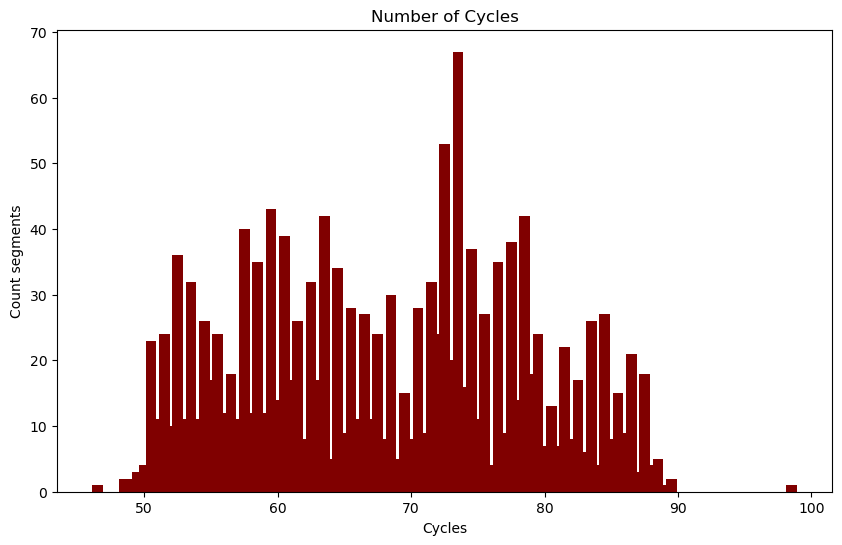

In [ ]:
def Cycles_Bar_Plot(df):
    """
    Plot a bar chart of the number of cycles in the dataset.

    Args:
    df (pandas.DataFrame): Input DataFrame containing the data.
    """
    features_by_cycle = df.groupby('Cycles')
    cycle_series = features_by_cycle['Cycles'].unique().tolist()
    cycle_labels = [age[0] for age in cycle_series]

    plt.figure(figsize=(10, 6))
    plt.bar(cycle_labels, features_by_cycle['Cycles'].count(), color='maroon')
    plt.xlabel("Cycles")
    plt.ylabel("Count segments")
    plt.title('Number of Cycles')
    plt.show()

# Plot the cycles bar plot with the train & test data
Cycles_Bar_Plot(combined_train_features_df)

* we can see that windows with more than 90 cycles are ubnormal and we should remove tham from our data.

**Number of segments to every patient**

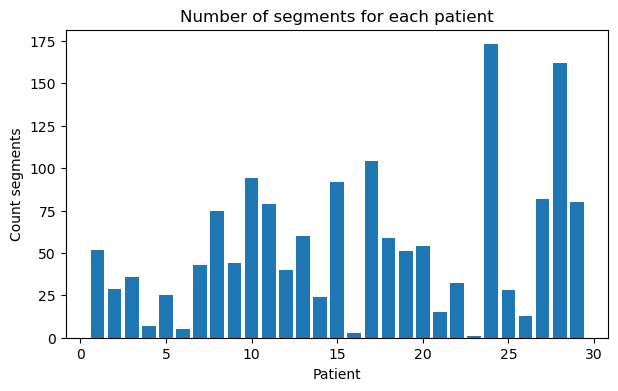

In [ ]:
# Group the features by patient ID
features_by_ID = combined_train_features_df.groupby('ID')
id_series = features_by_ID['ID'].unique().tolist()

# Create labels for the x-axis
id_unique = [age[0] for age in id_series]
id_labels = range(1, len(id_unique) + 1)

# Plot the bar chart
plt.figure(figsize=(7, 4))
plt.bar(id_labels, features_by_ID['ID'].count())
plt.xlabel("Patient")
plt.ylabel("Count segments")
plt.title('Number of segments for each patient')
plt.show()

**Statistics on all the features**

In [ ]:
# Initialize empty arrays to store the statistical measures for each column
count_feature = np.array([])
mean_feature = np.array([])
std_feature = np.array([])
min_feature = np.array([])
val_25_prec_feature = np.array([])
val_50_prec_feature = np.array([])
val_75_prec_feature = np.array([])
max_feature = np.array([])
feature_name = np.array([])

# Iterate over each column in the combined_features_df data frame
for column in combined_train_features_df.columns:
    # Store the column name in the feature_name array
    feature_name = np.append(feature_name, column)

    # Calculate and store the statistical measures for the current column using the describe() function
    describe_col = combined_train_features_df[column].describe()

    count_feature = np.append(count_feature, describe_col.get('count', np.nan))
    mean_feature = np.append(mean_feature, describe_col.get('mean', np.nan))
    std_feature = np.append(std_feature, describe_col.get('std', np.nan))
    min_feature = np.append(min_feature, describe_col.get('min', np.nan))
    val_25_prec_feature = np.append(val_25_prec_feature, describe_col.get('25%', np.nan))
    val_50_prec_feature = np.append(val_50_prec_feature, describe_col.get('50%', np.nan))
    val_75_prec_feature = np.append(val_75_prec_feature, describe_col.get('75%', np.nan))
    max_feature = np.append(max_feature, describe_col.get('max', np.nan))

# Create the features_statistic data frame and populate it with the collected statistical measures
features_statistic = pd.DataFrame({
    'feature_name': feature_name,
    'count': count_feature,
    'mean': mean_feature,
    'std': std_feature,
    'min': min_feature,
    '25%': val_25_prec_feature,
    '50%': val_50_prec_feature,
    '75%': val_75_prec_feature,
    'max': max_feature
})

# Return the features_statistic data frame
features_statistic

feature_name   count          mean           std           min  \
0                Cycles  1562.0  6.814597e+01  1.040950e+01  4.650000e+01   
1                    ID  1562.0           NaN           NaN           NaN   
2                L1_MAP  1562.0  7.902753e+01  1.021715e+01  4.733333e+01   
3               L2_DMAP  1562.0 -1.595262e+01  2.253482e+01 -7.666667e+01   
4                L3_SBP  1562.0  1.115922e+02  1.735028e+01  7.000000e+01   
..                  ...     ...           ...           ...           ...   
351    F6_STT_Sample_22  1562.0  1.642415e-03  4.646970e-04  8.665375e-04   
352    F6_STT_Sample_23  1562.0  2.205055e-03  1.448499e-02  7.791618e-04   
353  F6_Avg_STT_sampels  1562.0  1.671225e-03  7.388774e-04  8.160000e-04   
354  F6_Std_STT_sampels  1562.0  3.596114e-04  2.955192e-03  2.700000e-05   
355               F7_TV  1562.0  6.359721e+06  1.207033e+06  3.743376e+06   

              25%           50%           75%           max  
0    5.950000e+01  6.850000e+01  7.650000e+01  9.850000e+01  
1             NaN           NaN           NaN           NaN  
2    7.200000e+01  7.766667e+01  8.525000e+01  1.223333e+02  
3   -3.366667e+01 -2.133333e+01 -6.666667e-01  5.600000e+01  
4    9.900000e+01  1.070000e+02  1.240000e+02  1.850000e+02  
..            ...           ...           ...           ...  
351  1.332380e-03  1.577301e-03  1.874413e-03  8.123978e-03  
352  1.302892e-03  1.640230e-03  2.008338e-03  5.474616e-01  
353  1.365000e-03  1.623000e-03  1.889750e-03  2.550100e-02  
354  1.440000e-04  2.020000e-04  2.990000e-04  1.112830e-01  
355  5.479120e+06  6.211126e+06  7.199014e+06  1.060167e+07  

[356 rows x 9 columns]

**Number of NaN values in every feature**

In [ ]:
#Counts the number of NaN values in each column in the data sets
nan_counts = combined_train_features_df.isnull().sum()
print(f'The number of NaN values in each column is: \n{nan_counts[nan_counts > 0]}')

The number of NaN values in each column is: 
Series([], dtype: int64)


**Number of 0 values in every feature**

In [ ]:
# Counts the number of zero values in each column in the data set
zero_counts = (combined_train_features_df == 0).sum()

# Filters the columns that have more than 0 zero values
zero_columns = zero_counts[zero_counts > 0]

print(f'The number of 0 values in each column is: \n{zero_columns}')


The number of 0 values in each column is: 
L2_DMAP                      10
L4_DSBP                      12
L6_DDBP                      35
F1_Area_cycle_Sample_23       1
F3_Std_ROR_sampels_Norm    1562
F3_Std_ROF_sampels_Norm    1562
dtype: int64


**Boxplot for the distribution of each feature**

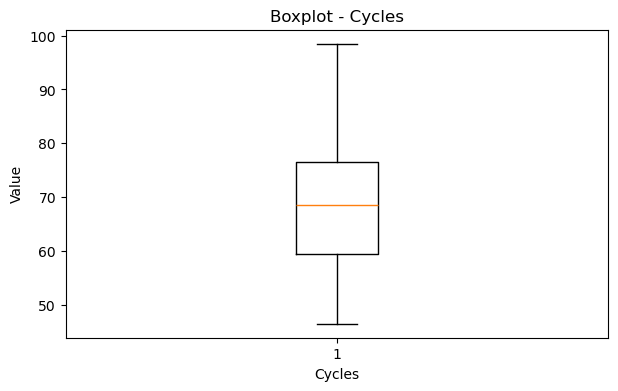

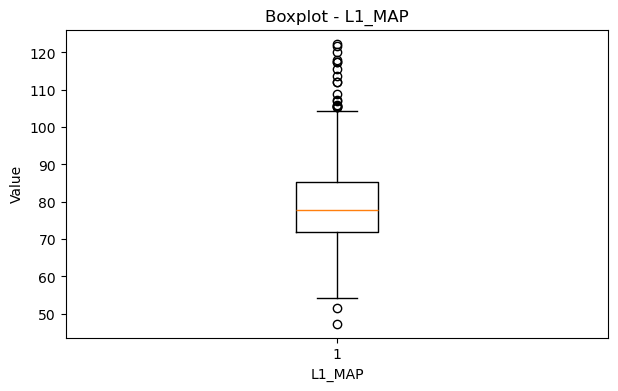

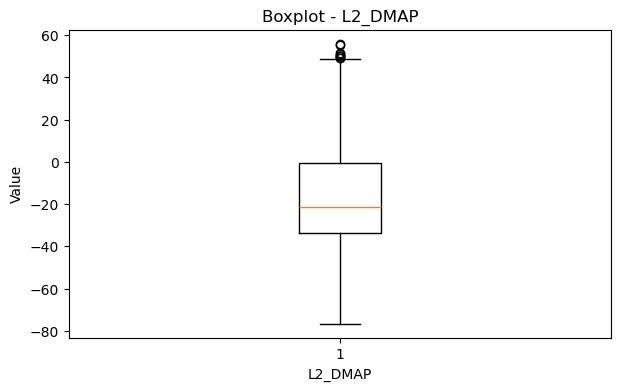

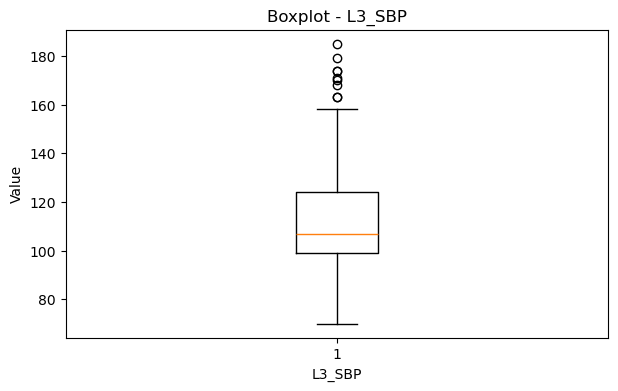

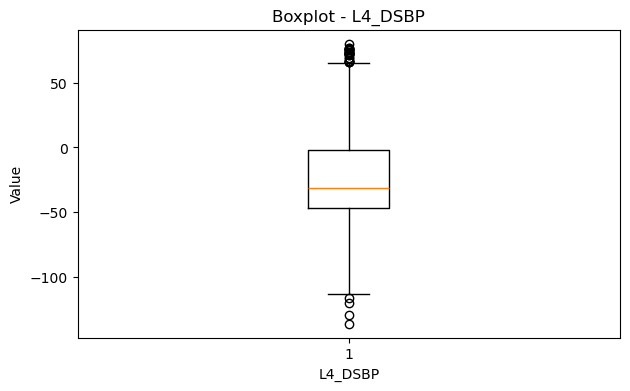

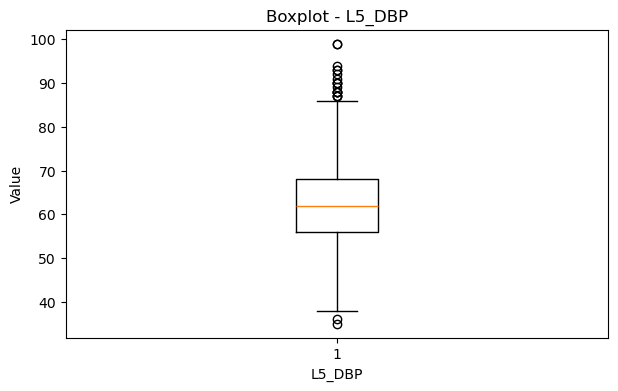

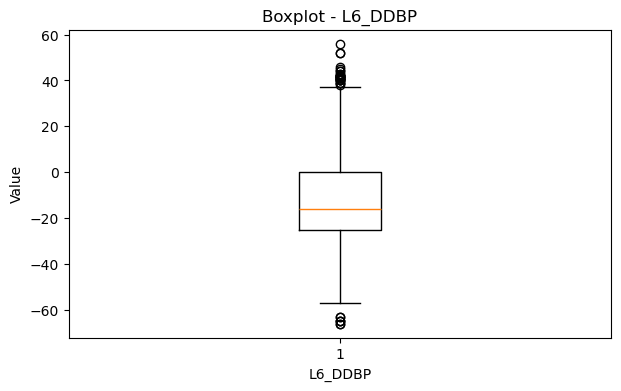

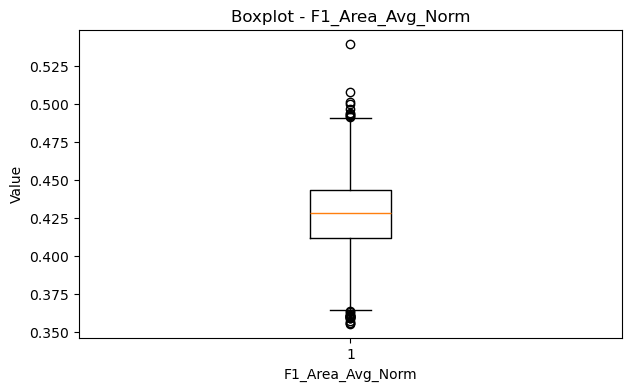

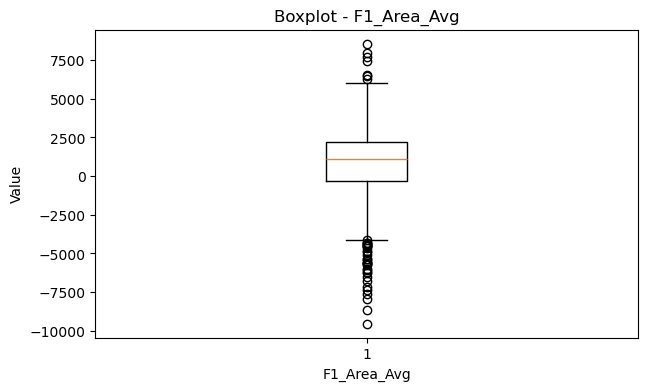

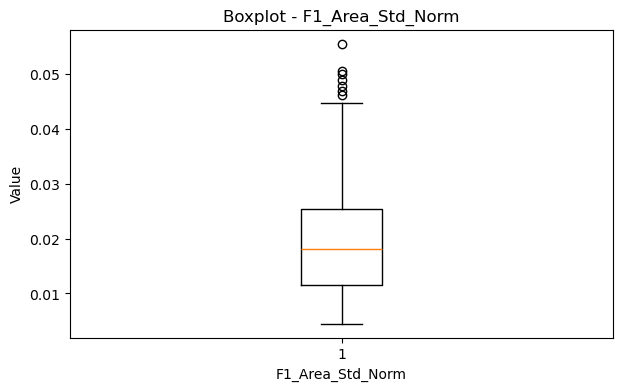

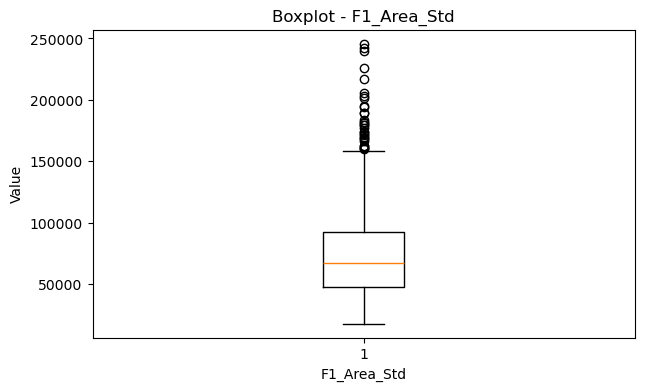

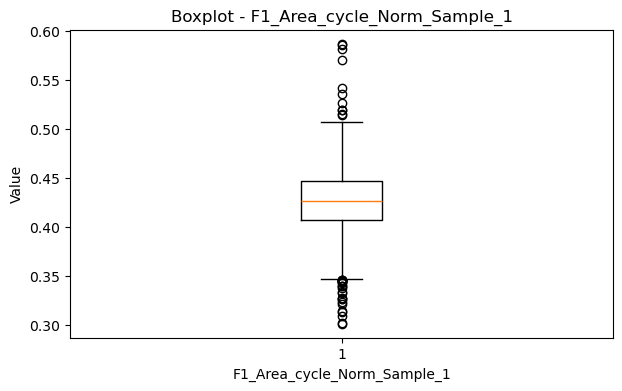

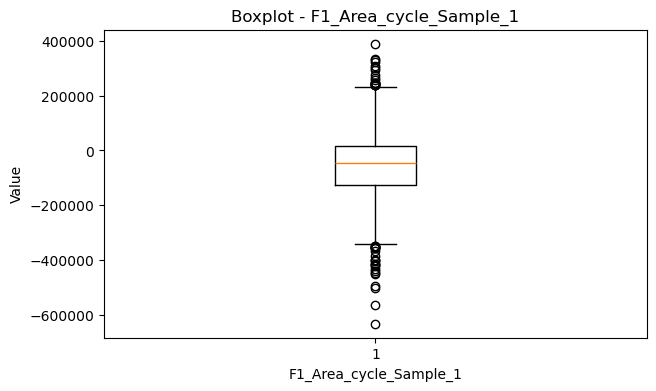

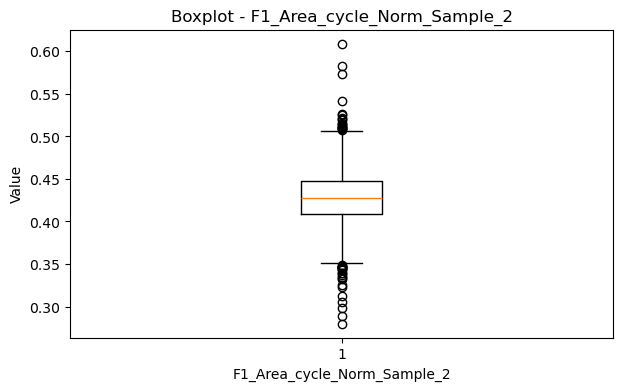

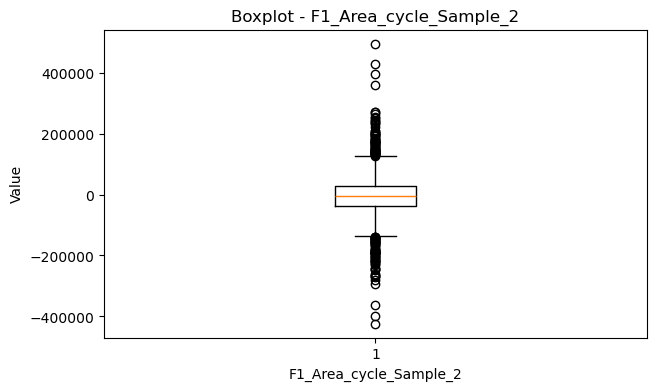

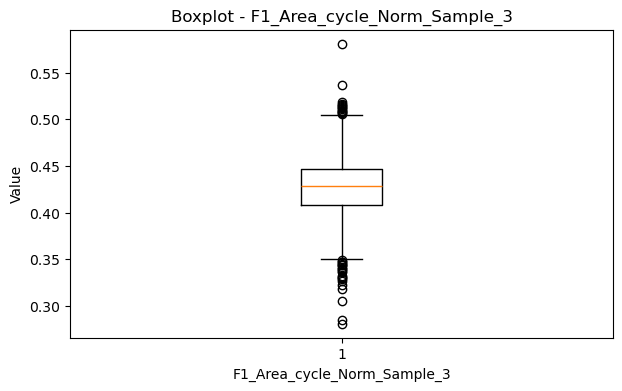

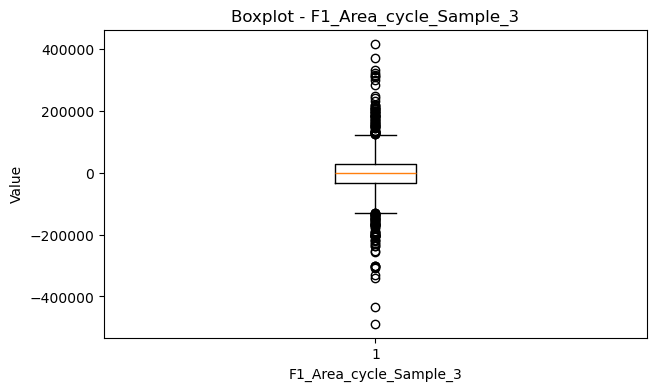

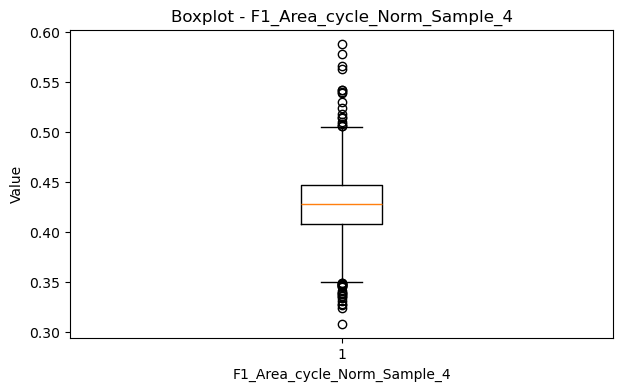

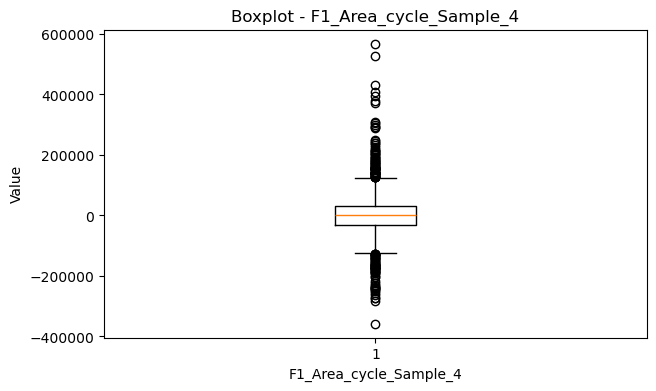

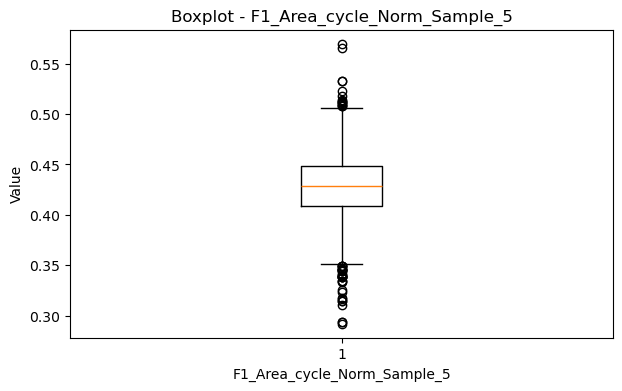

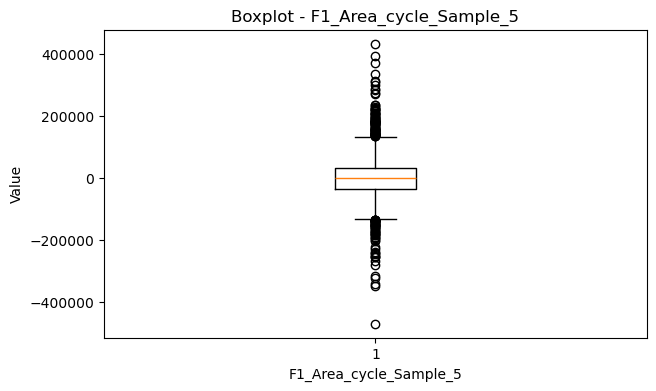

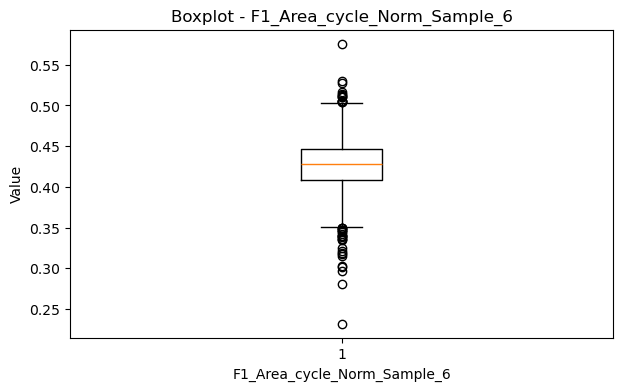

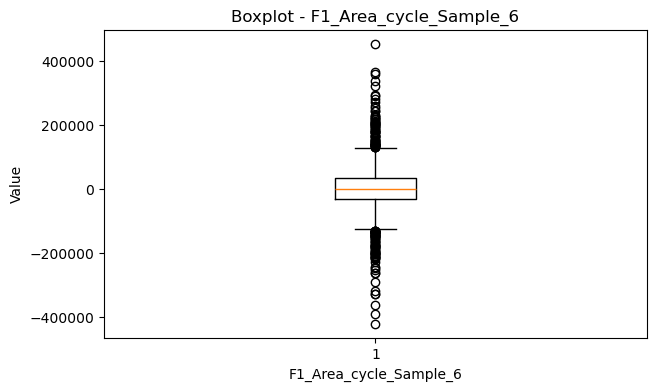

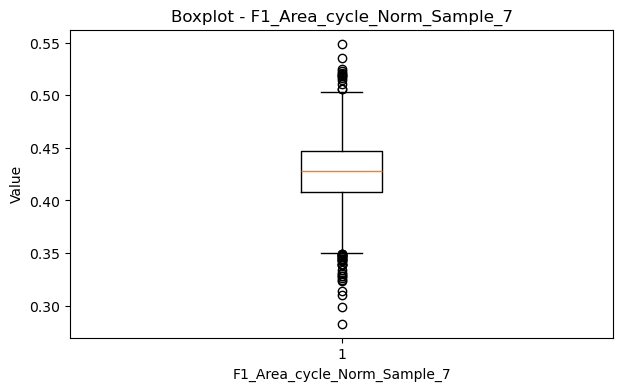

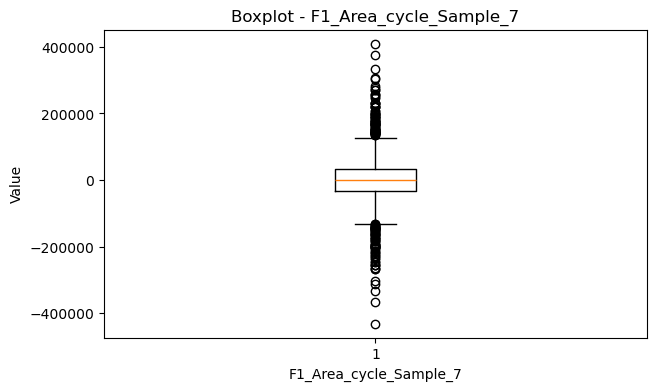

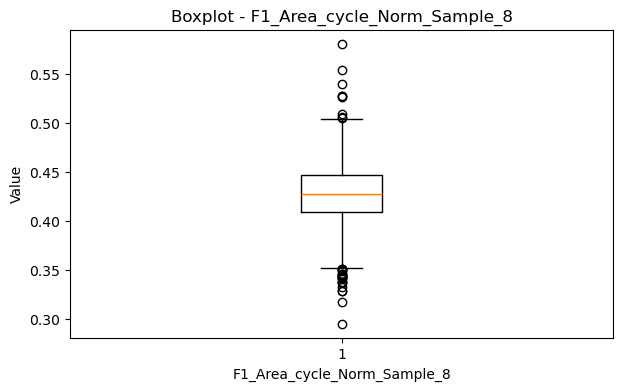

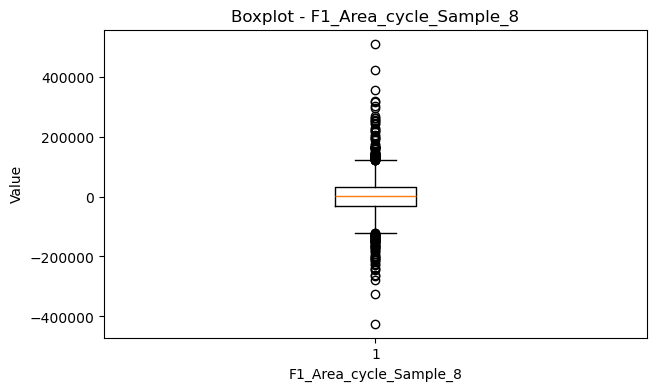

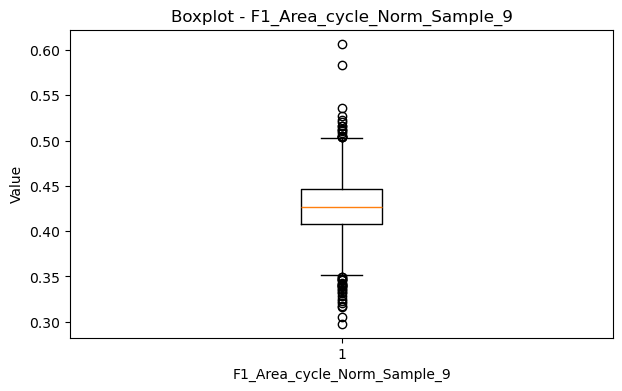

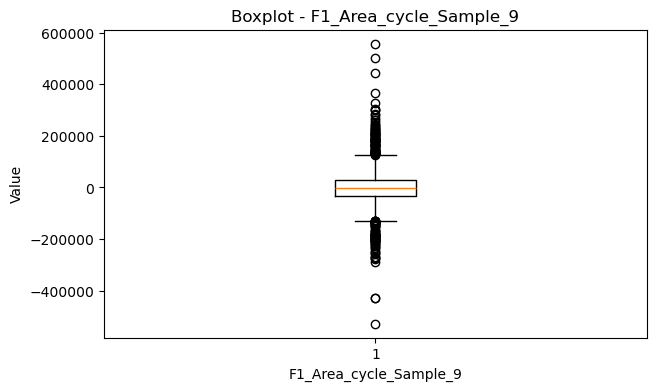

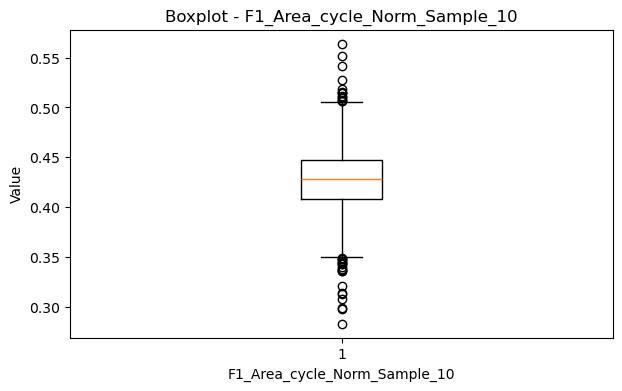

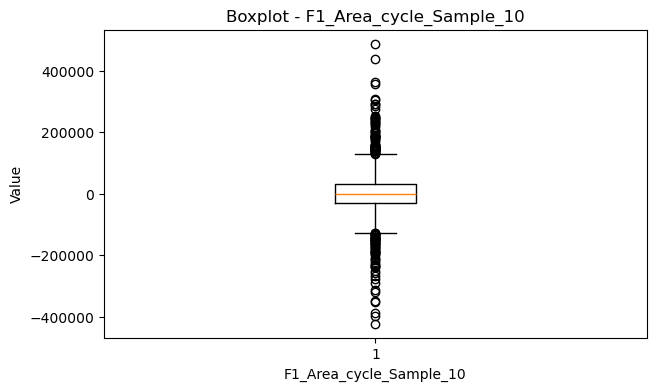

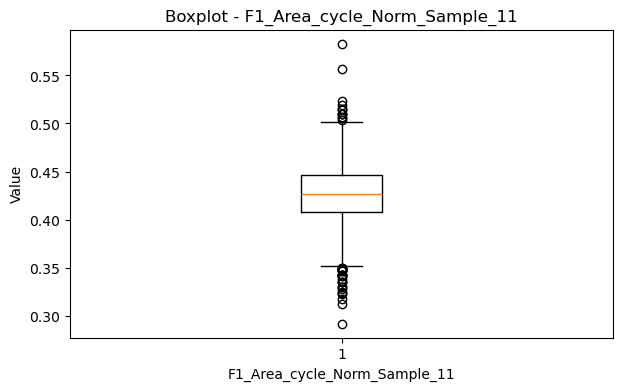

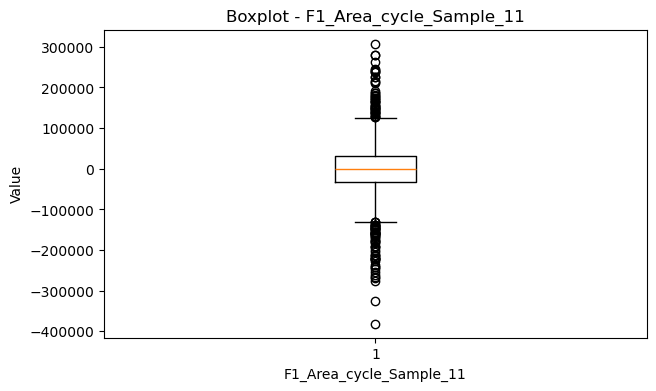

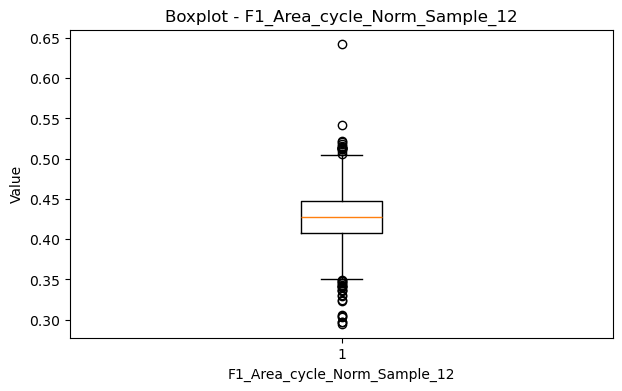

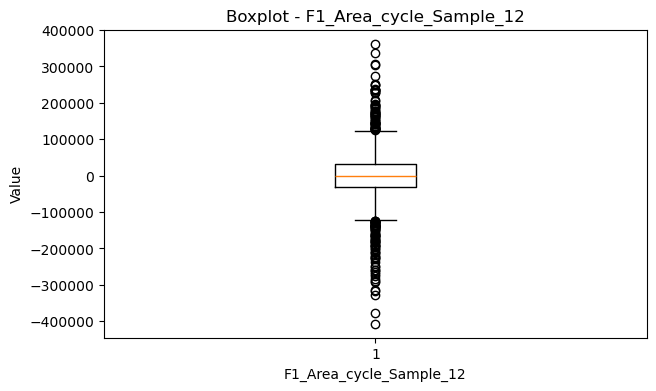

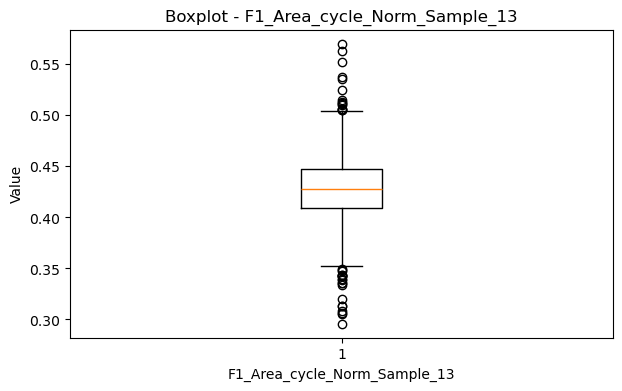

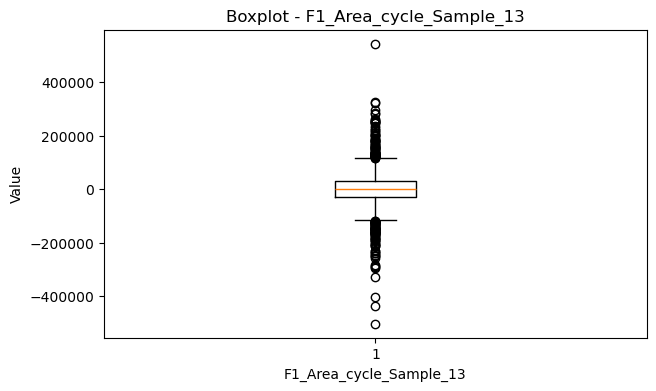

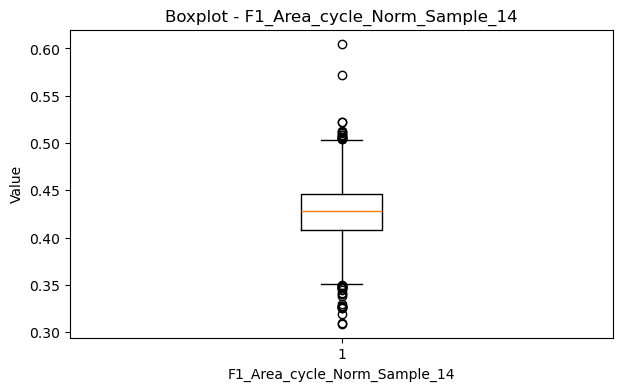

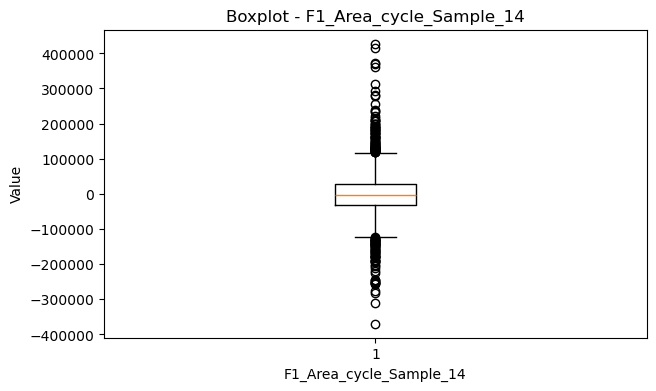

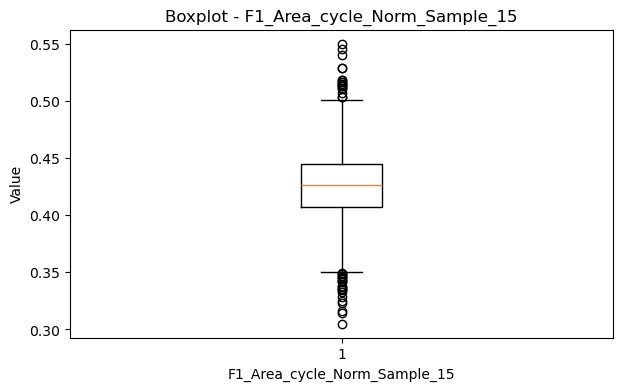

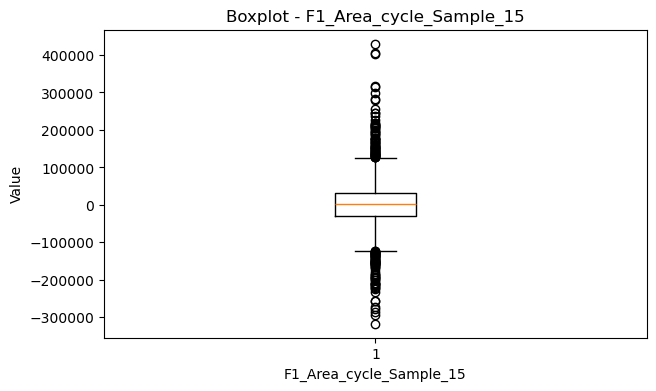

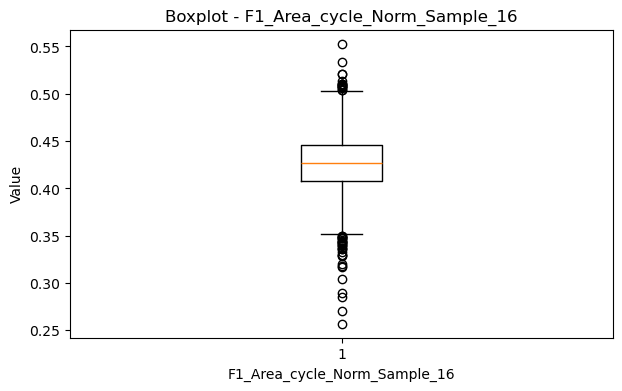

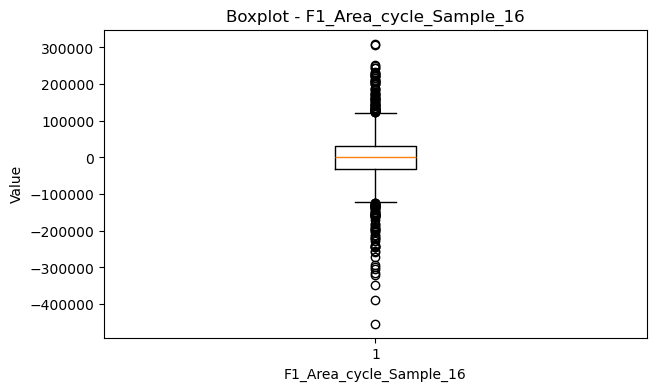

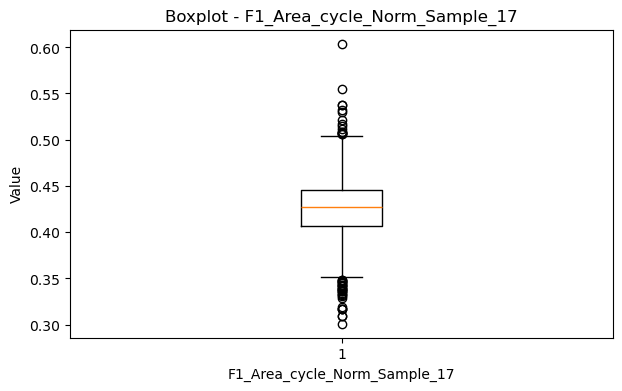

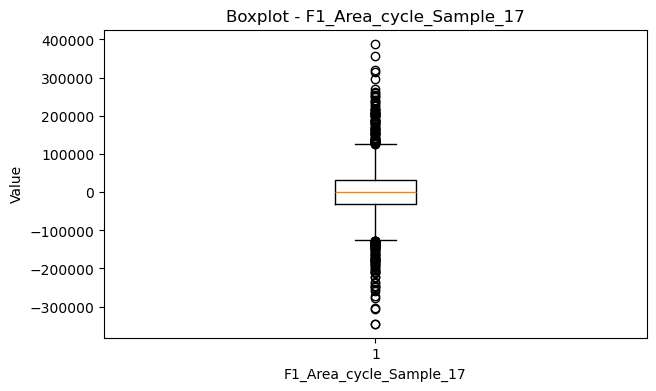

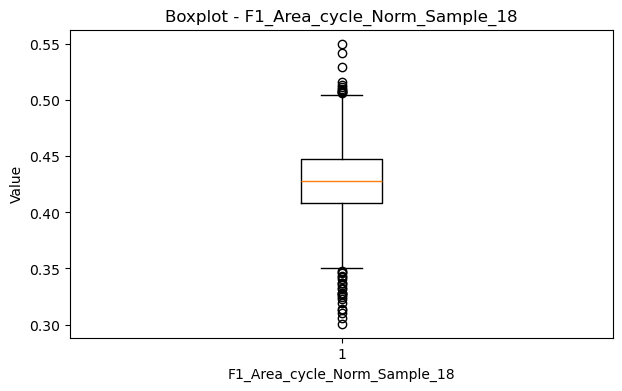

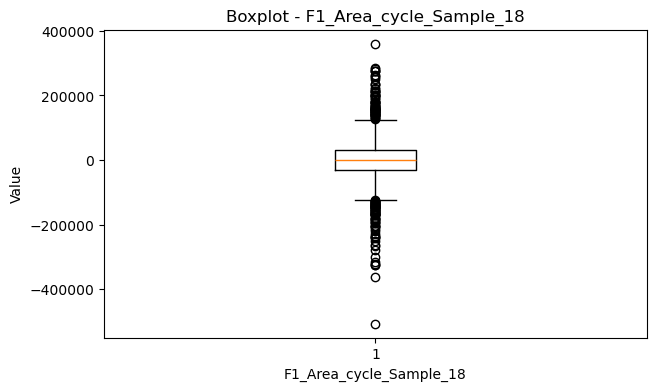

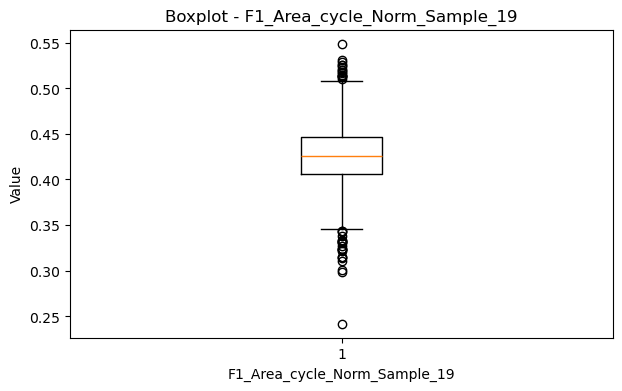

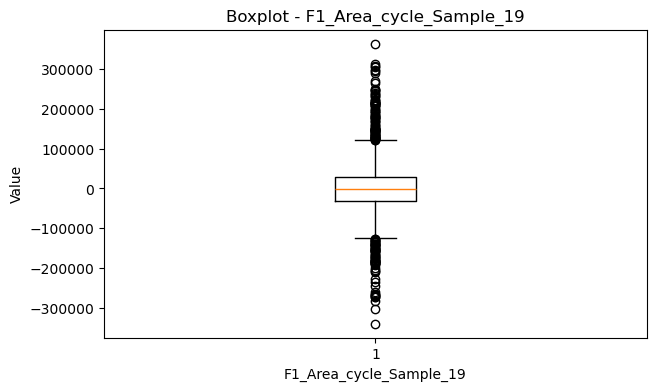

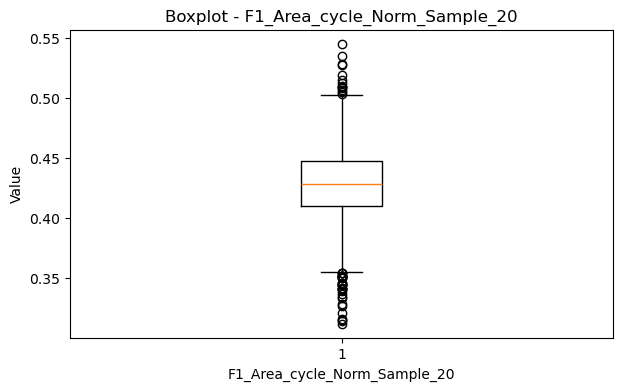

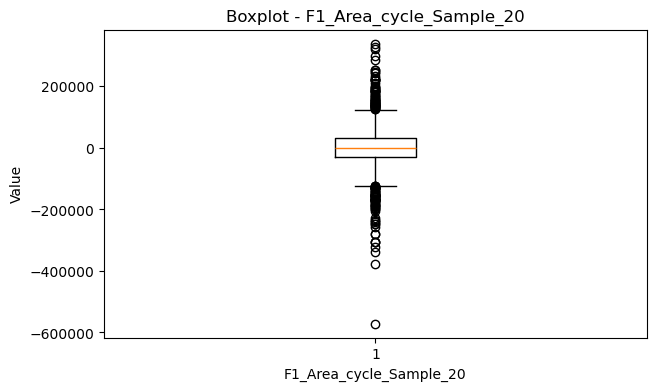

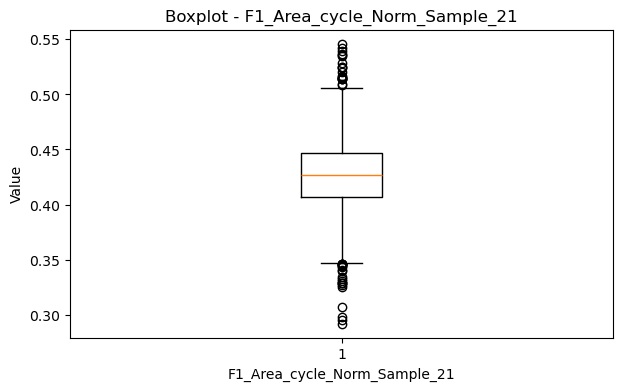

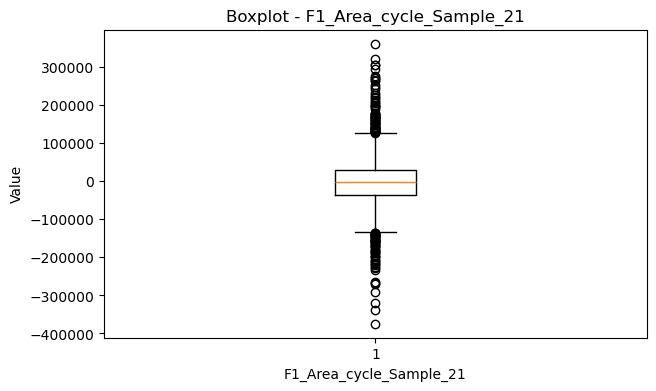

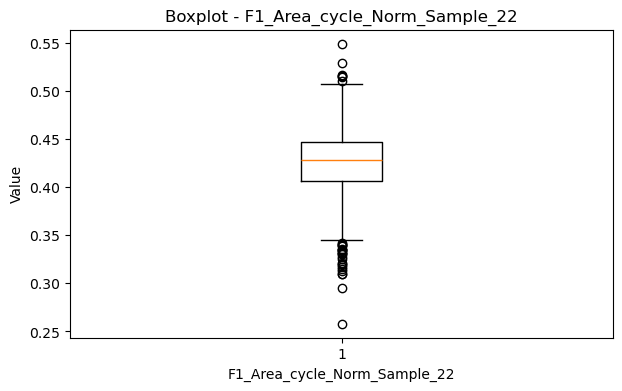

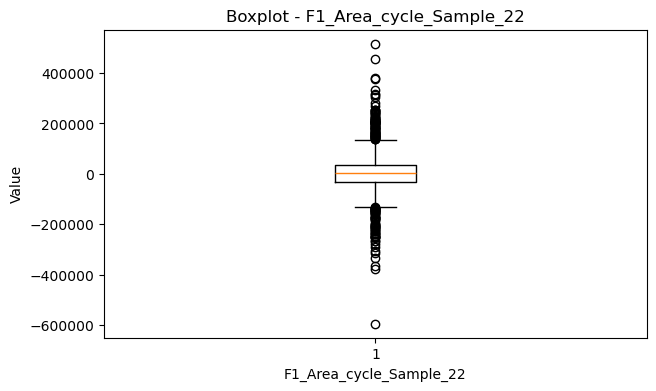

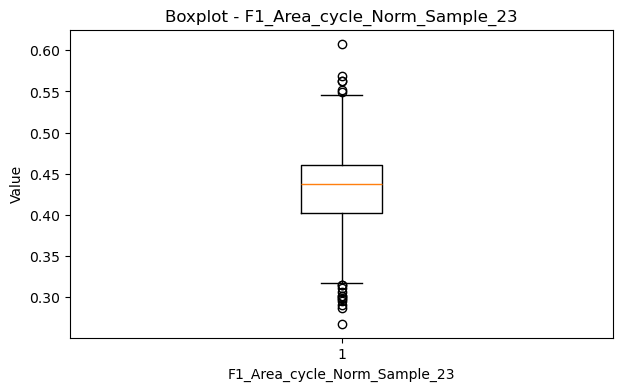

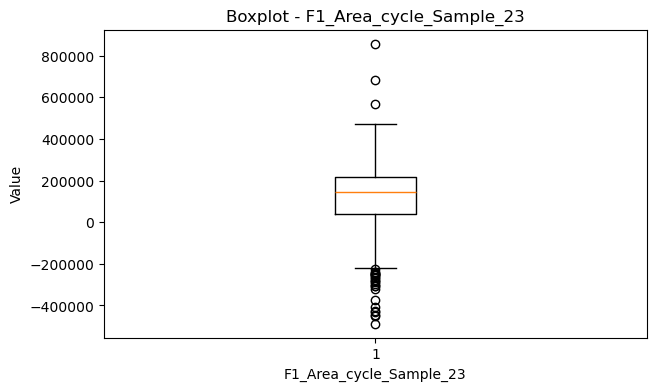

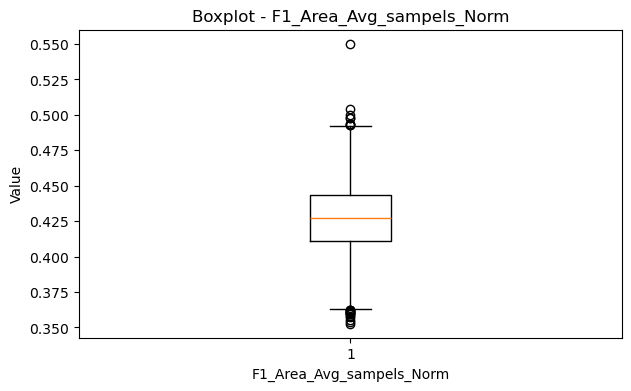

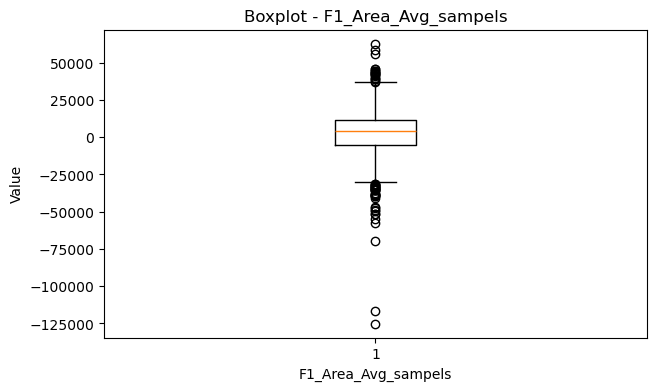

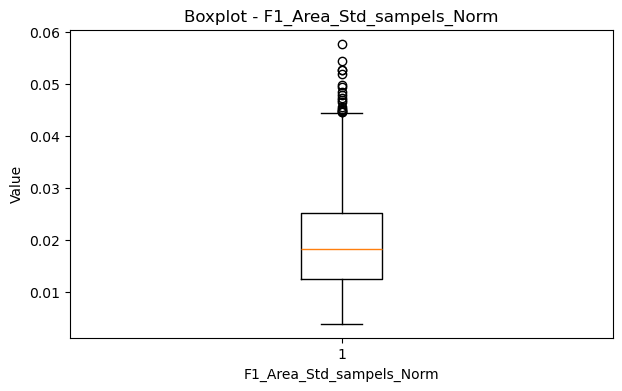

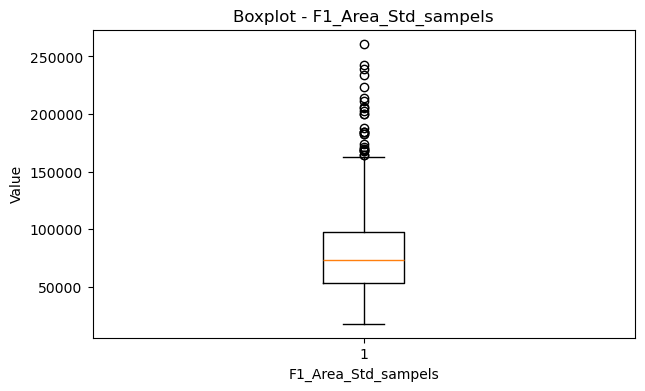

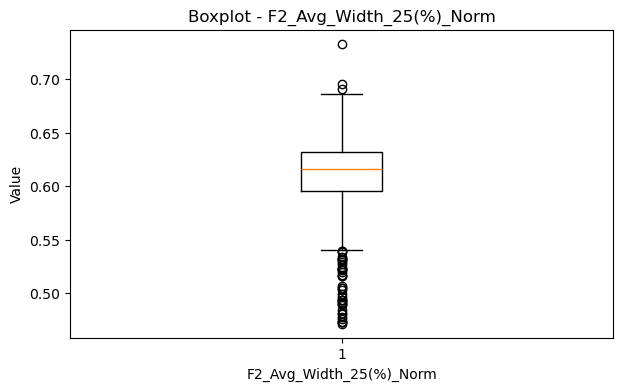

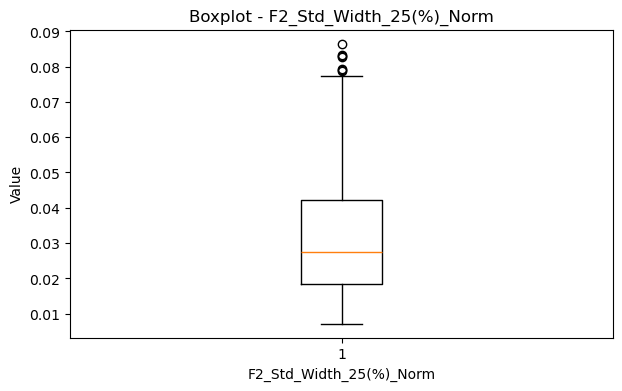

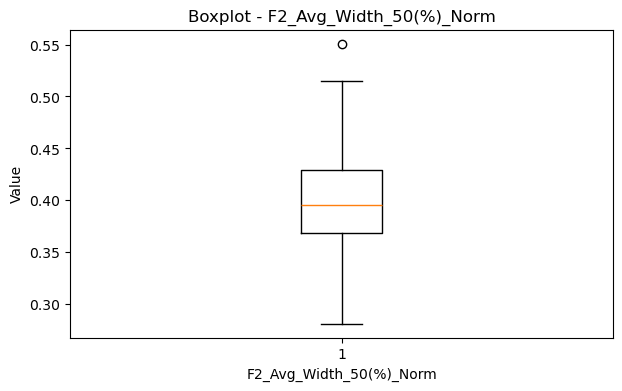

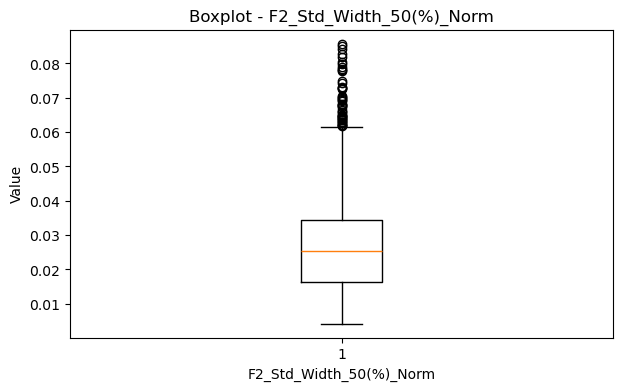

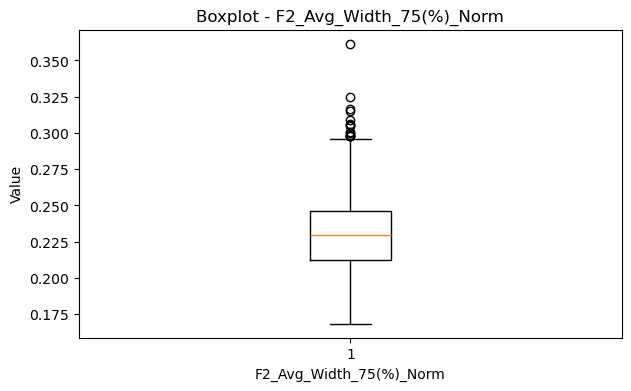

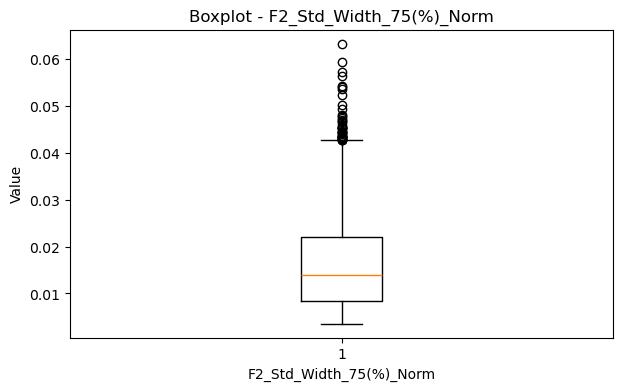

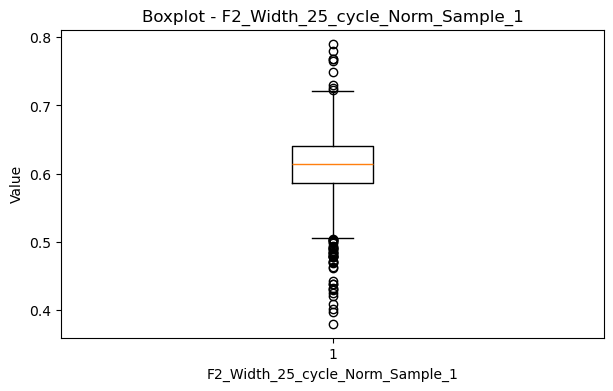

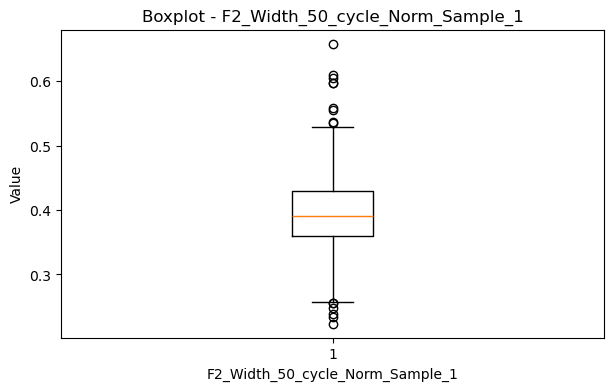

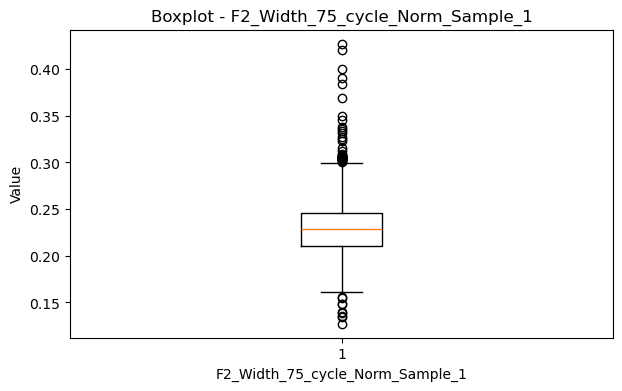

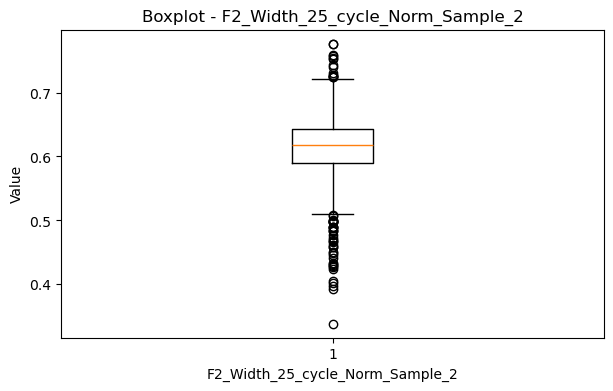

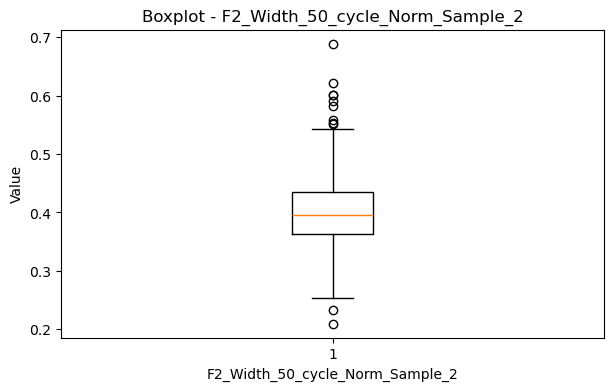

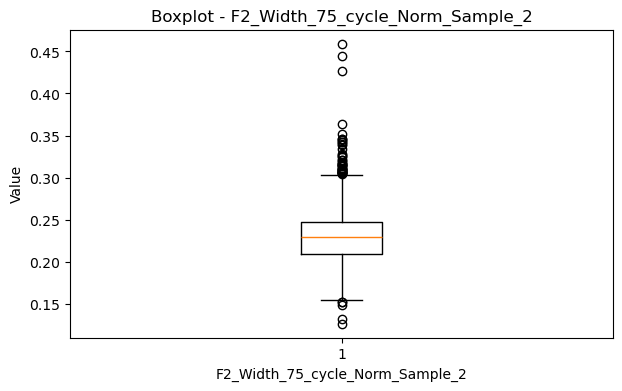

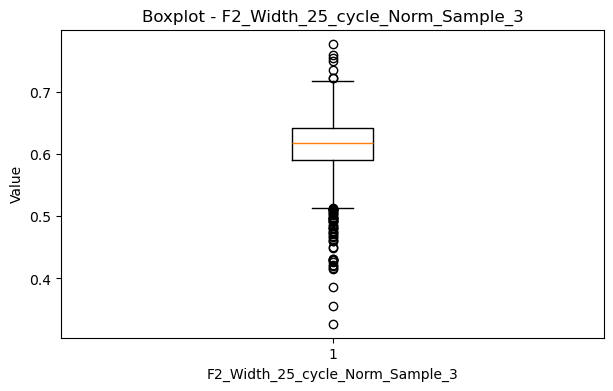

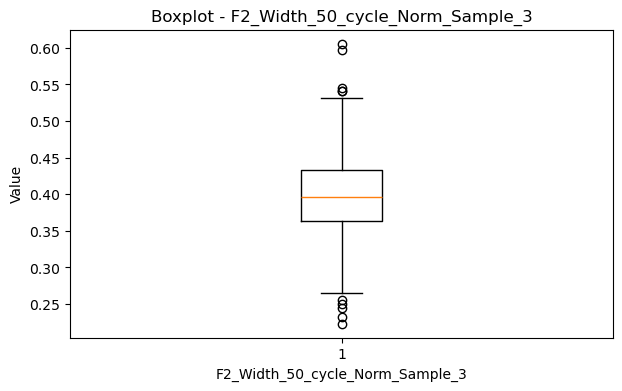

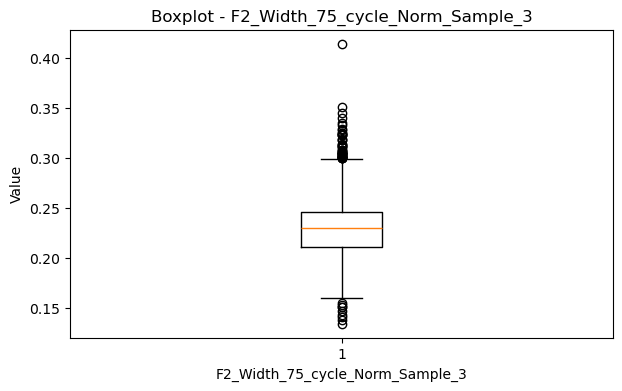

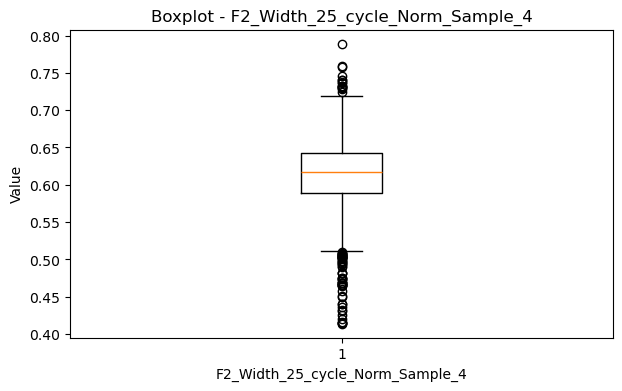

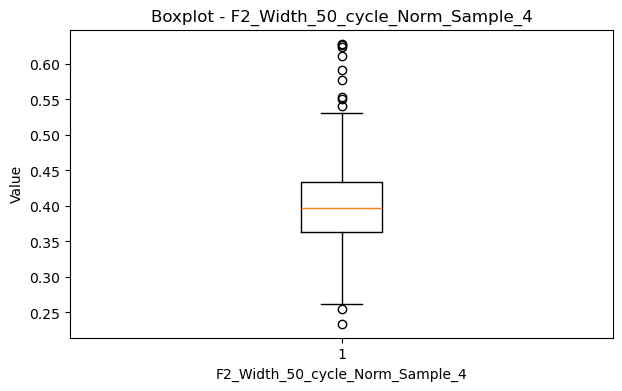

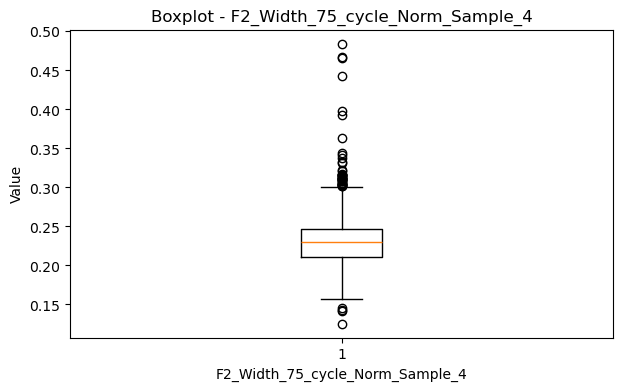

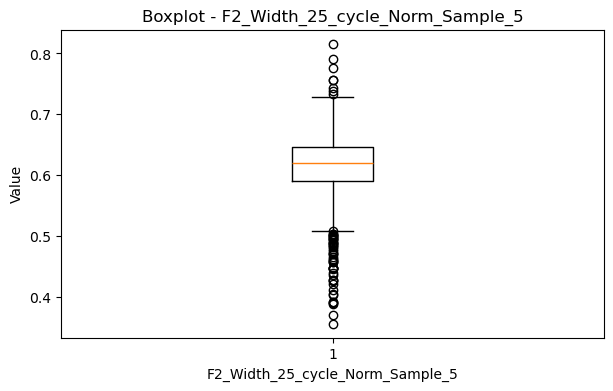

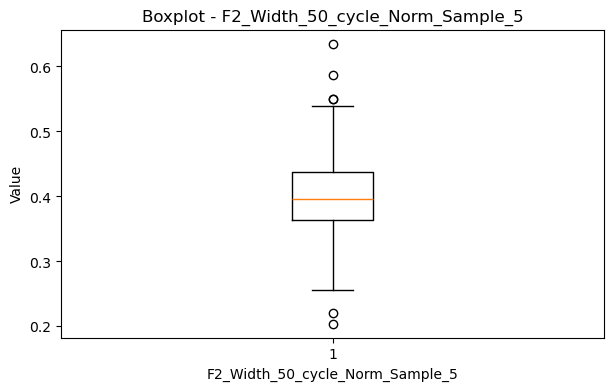

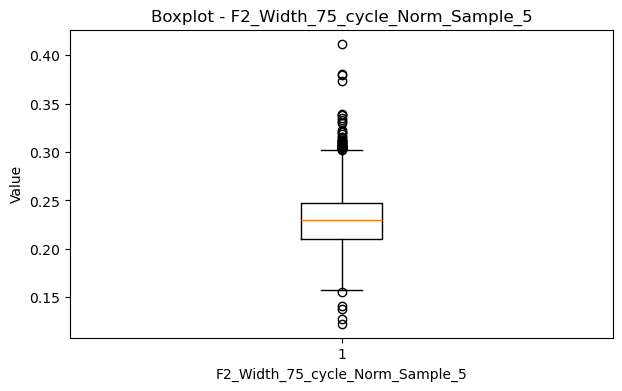

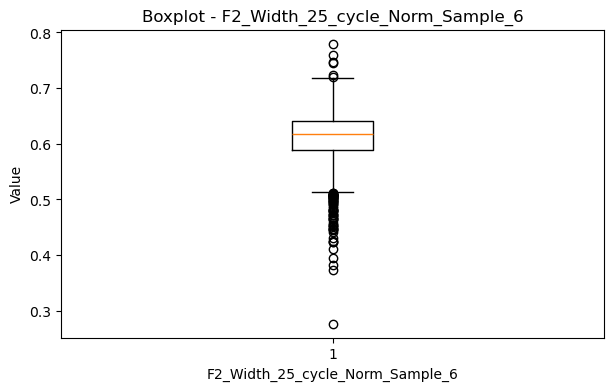

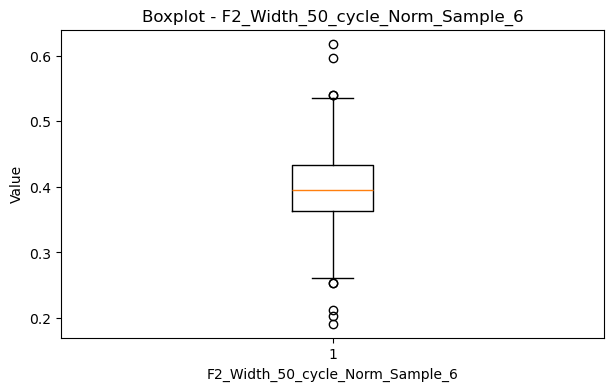

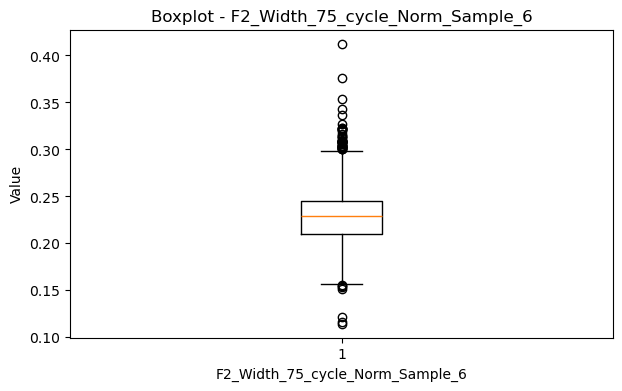

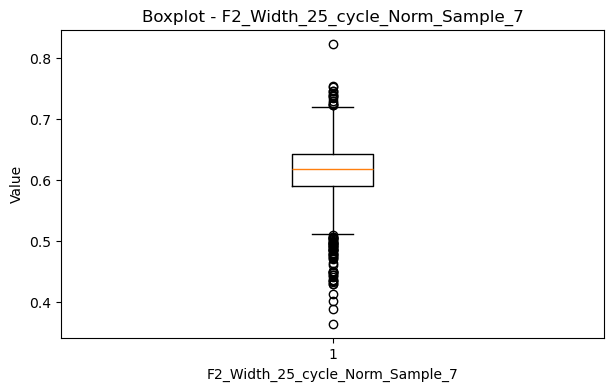

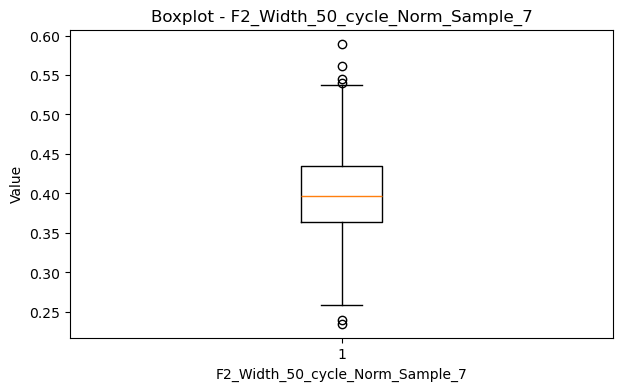

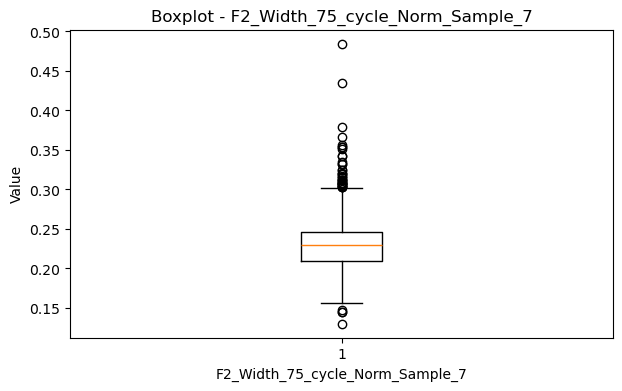

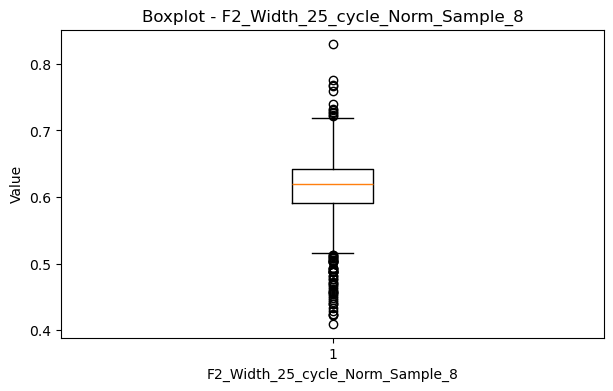

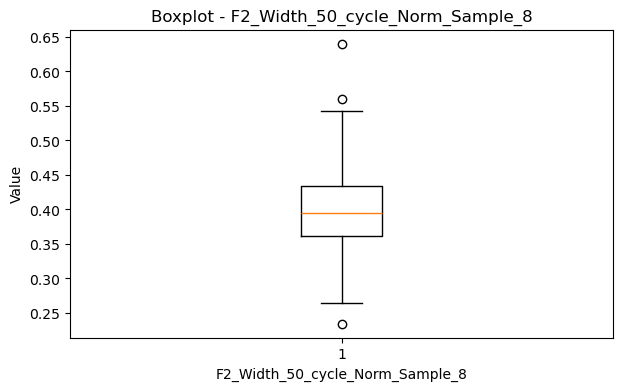

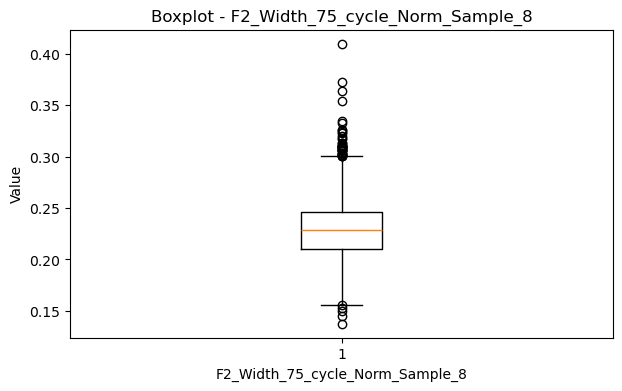

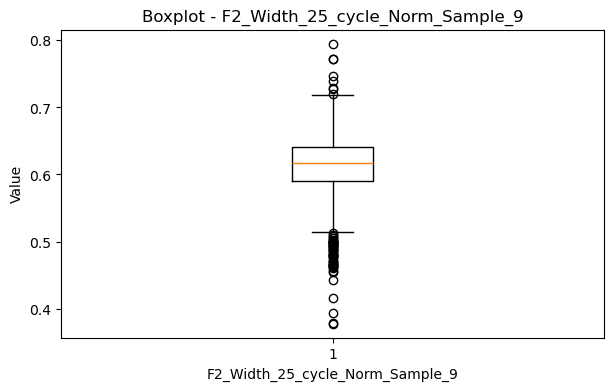

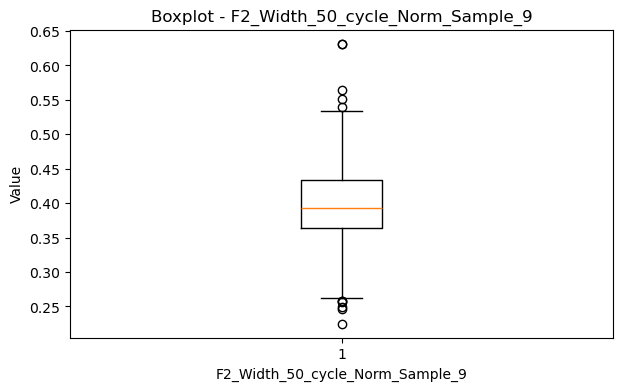

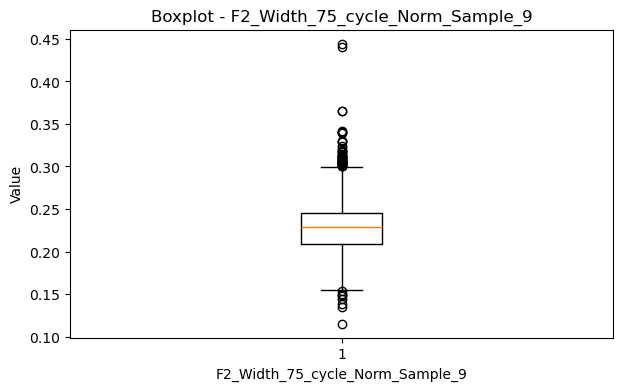

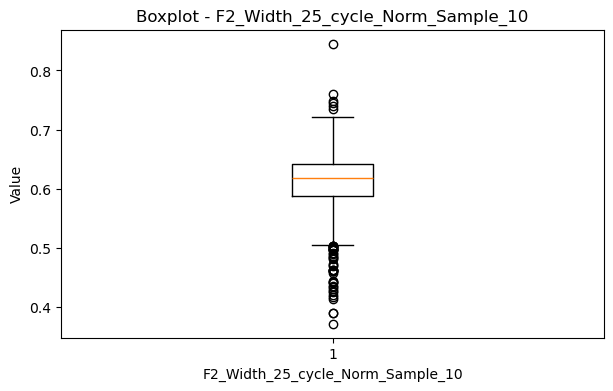

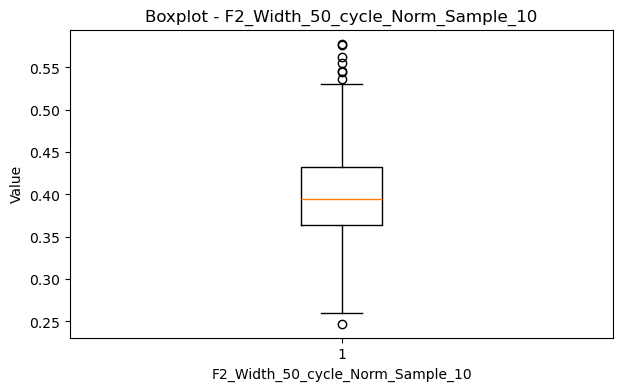

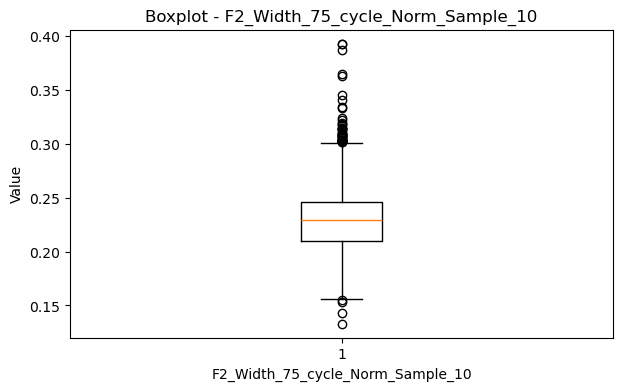

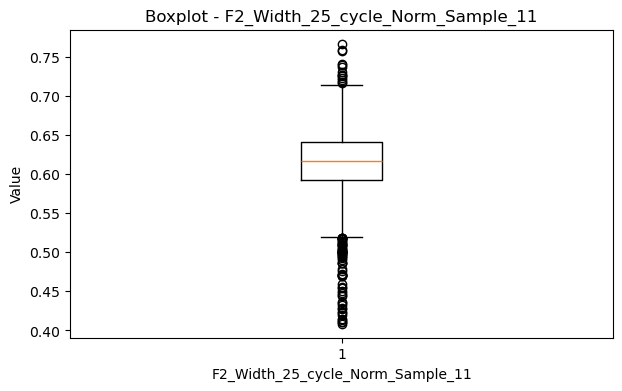

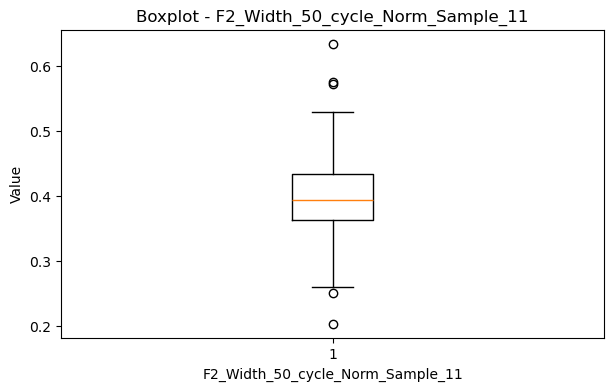

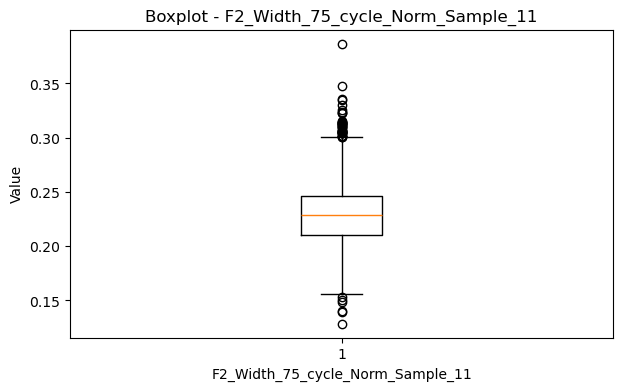

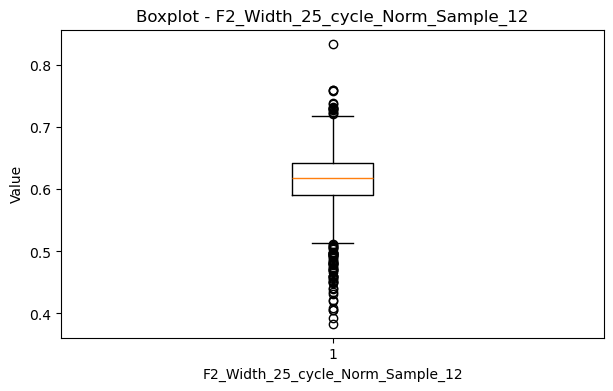

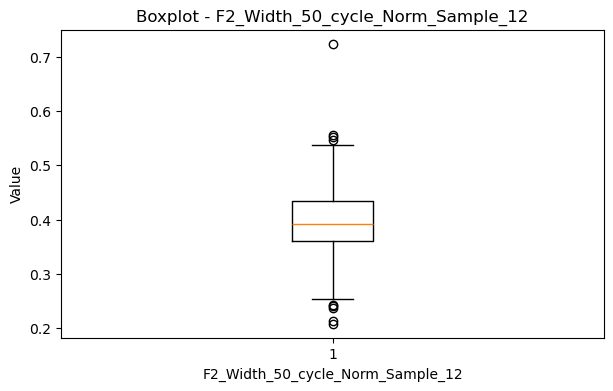

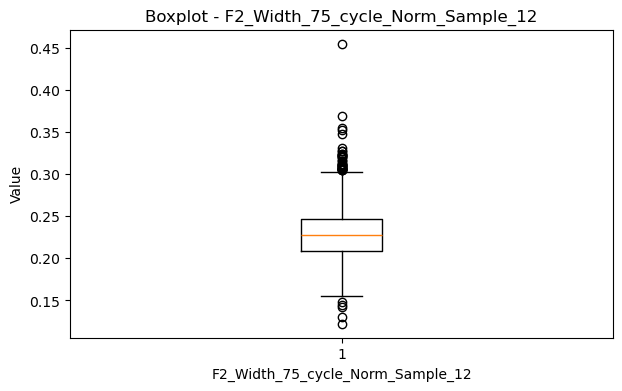

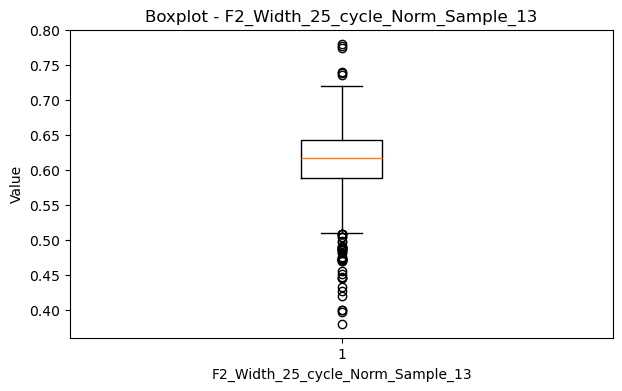

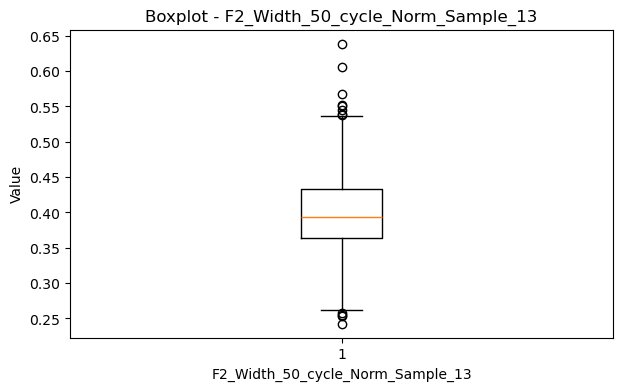

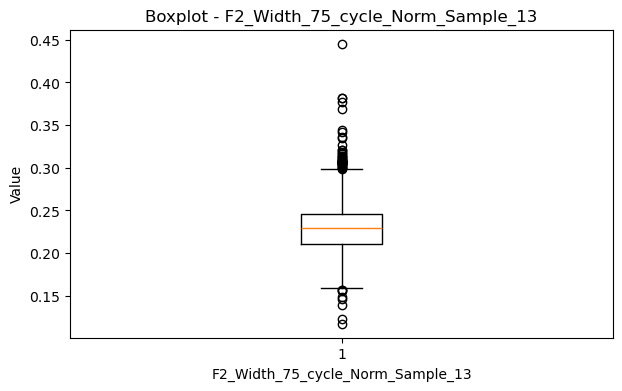

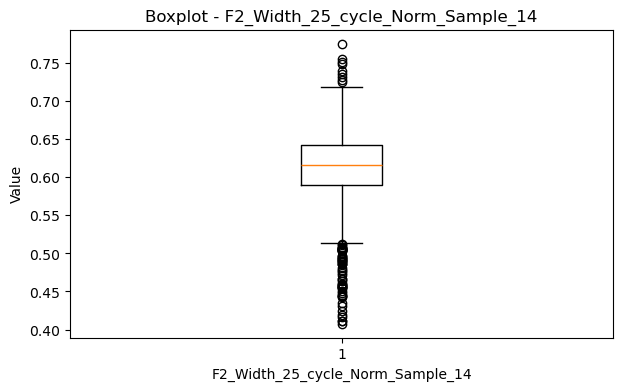

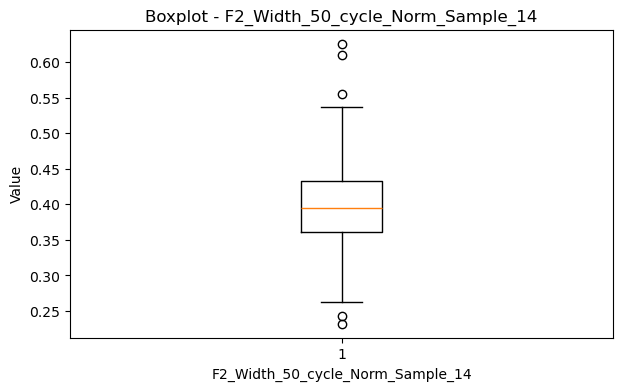

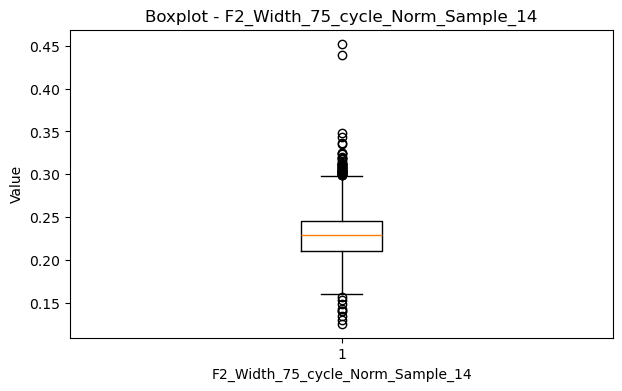

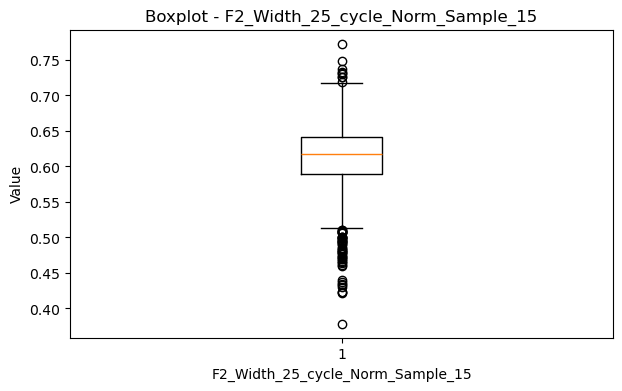

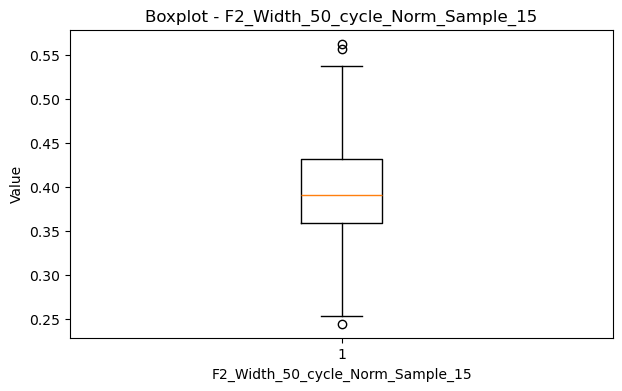

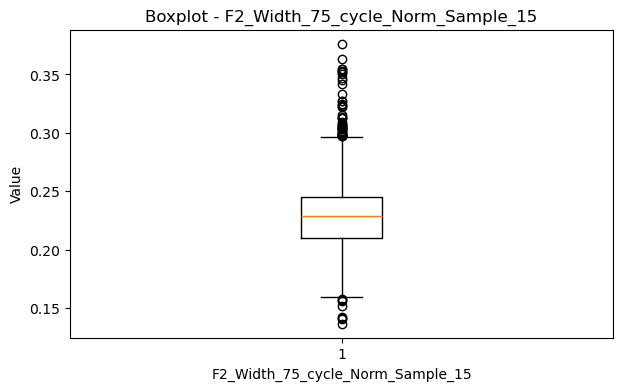

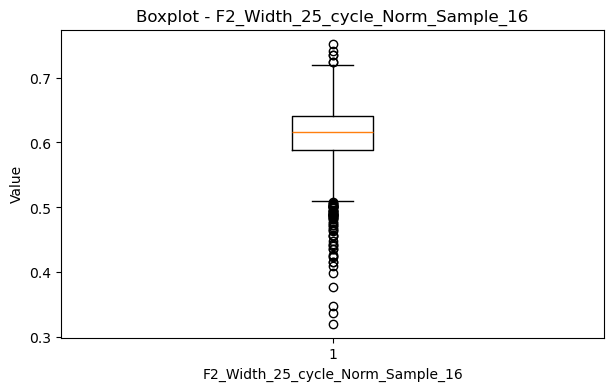

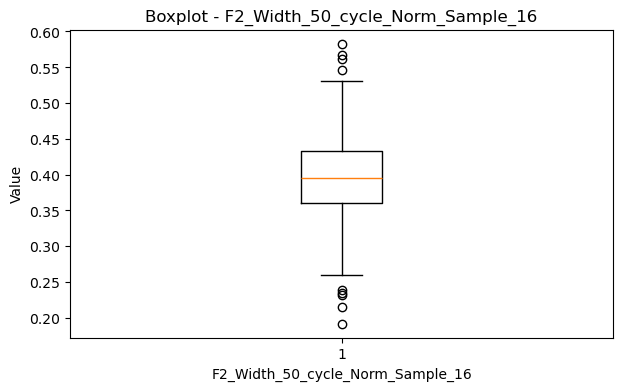

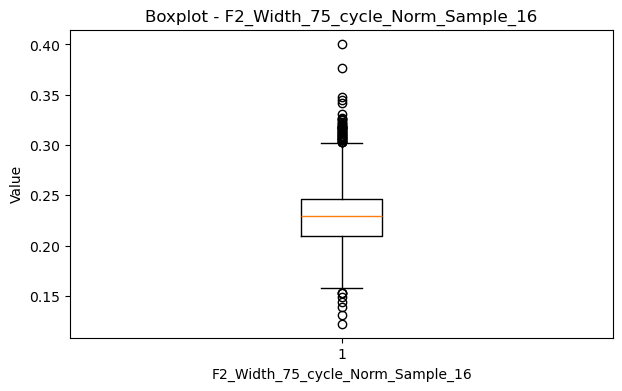

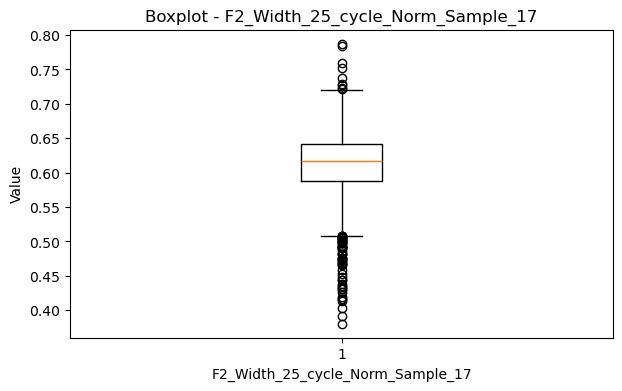

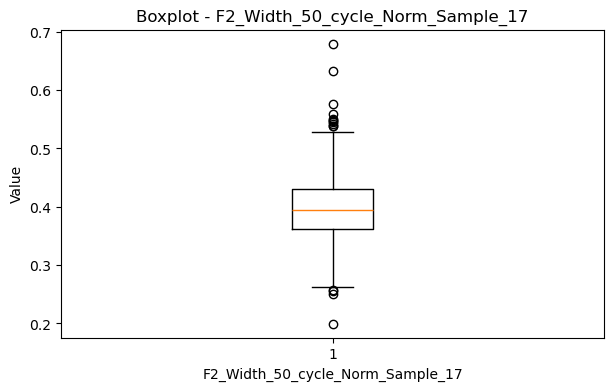

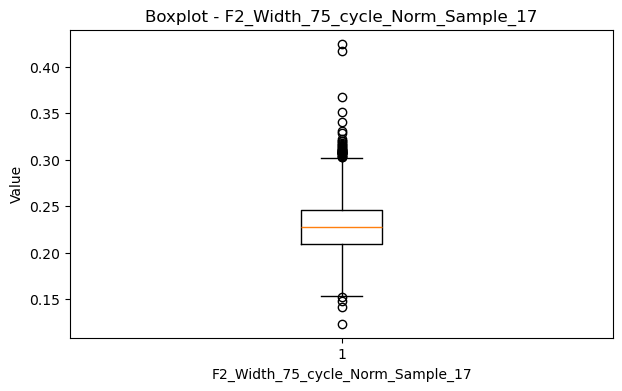

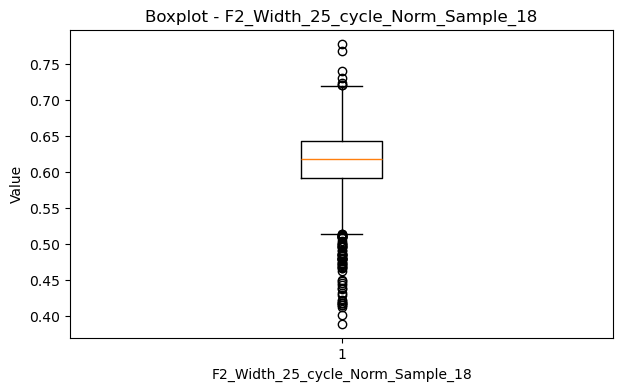

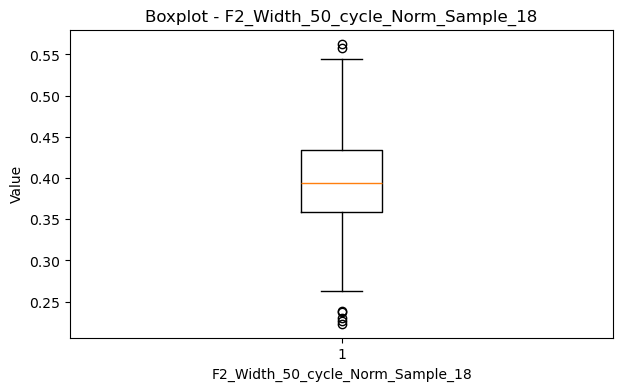

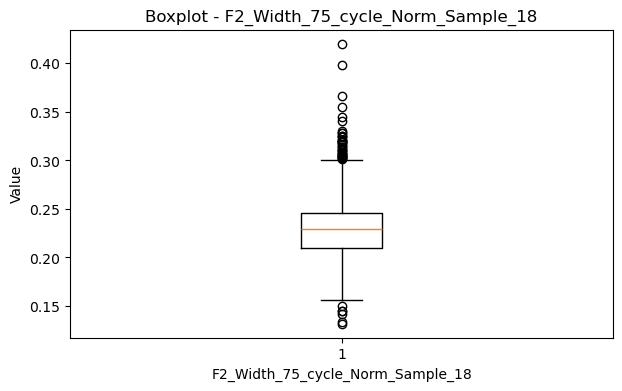

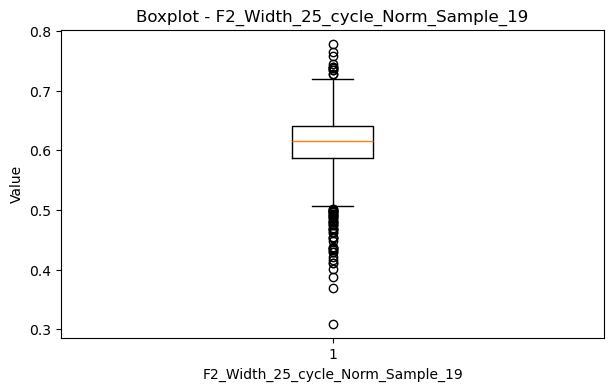

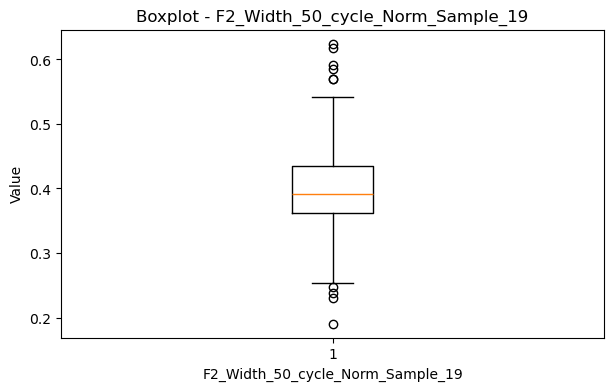

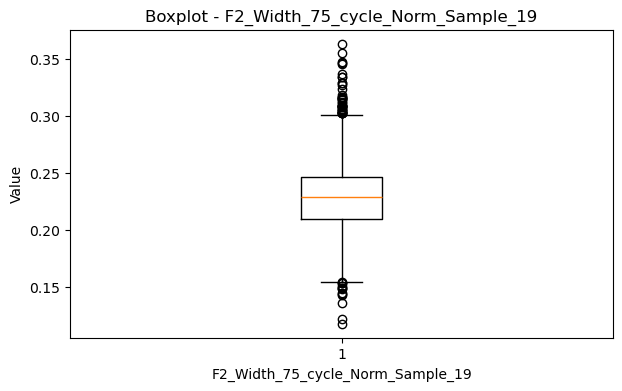

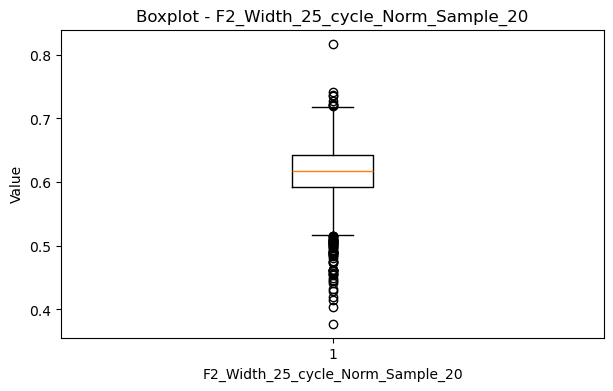

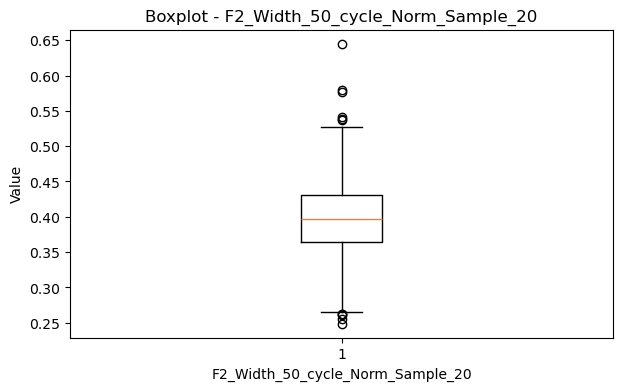

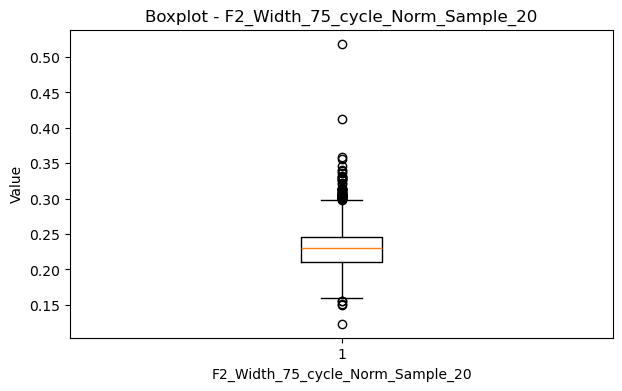

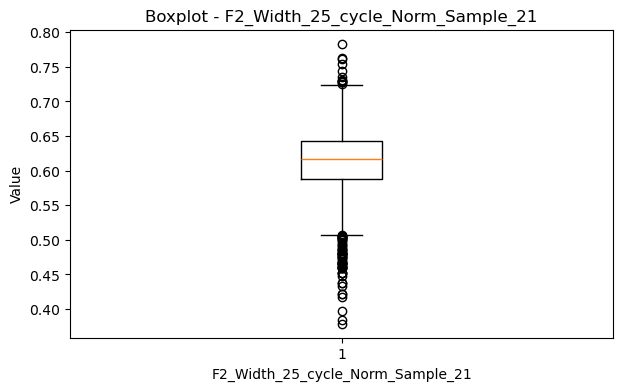

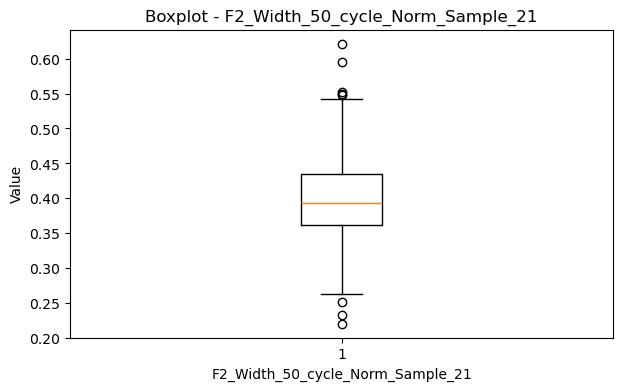

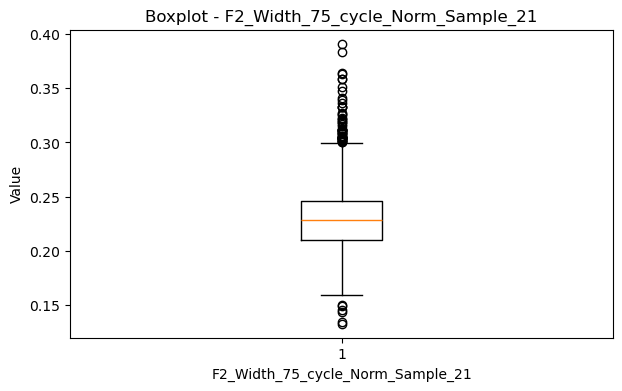

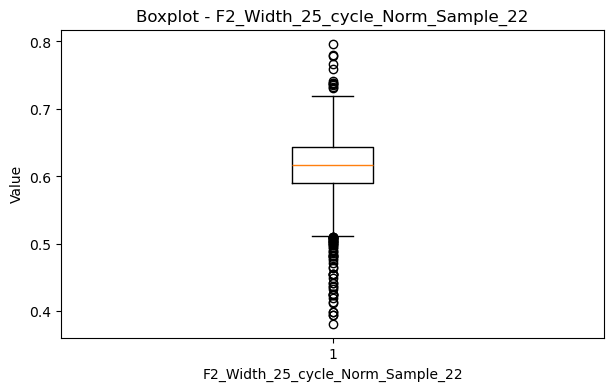

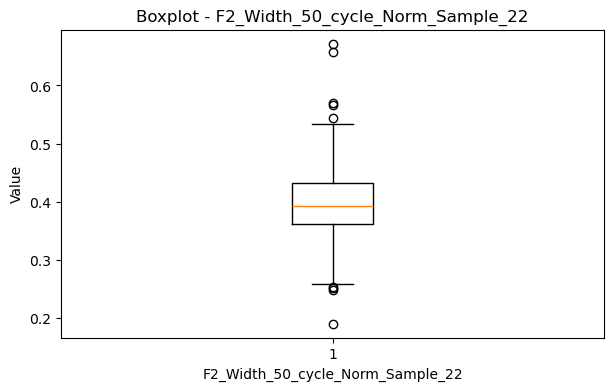

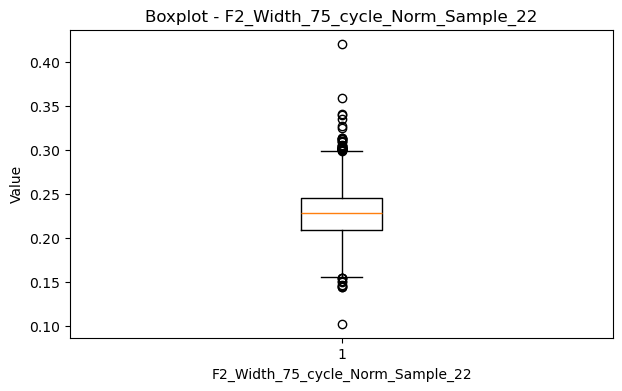

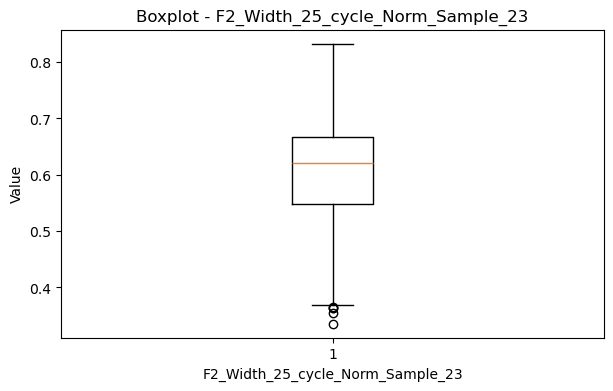

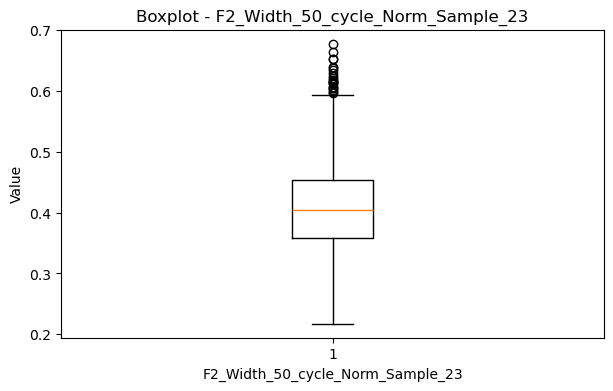

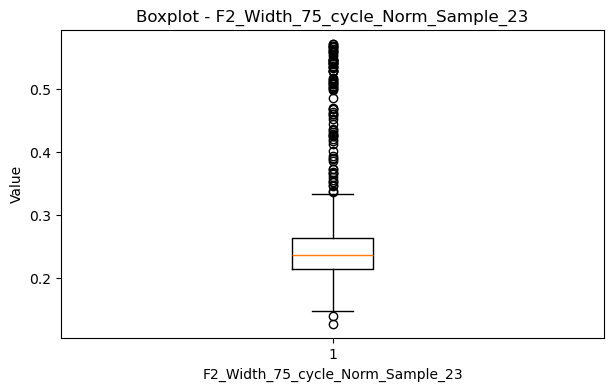

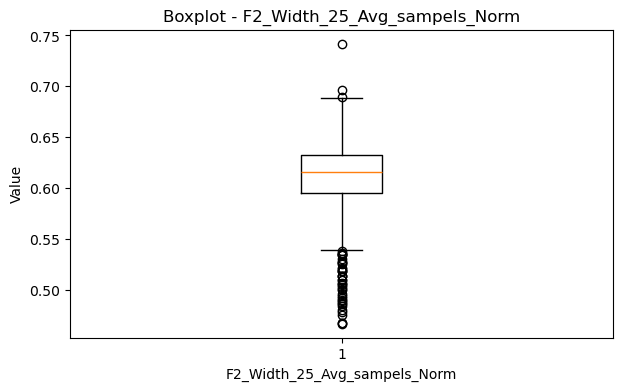

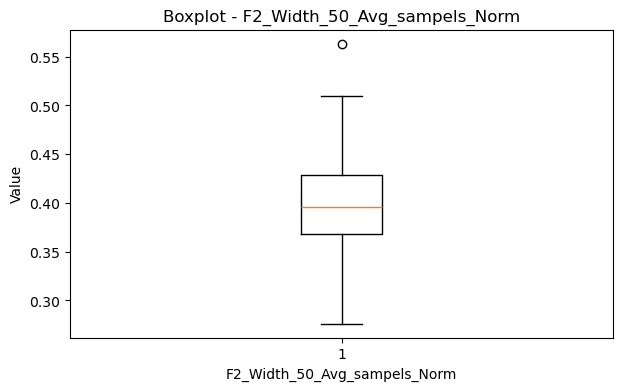

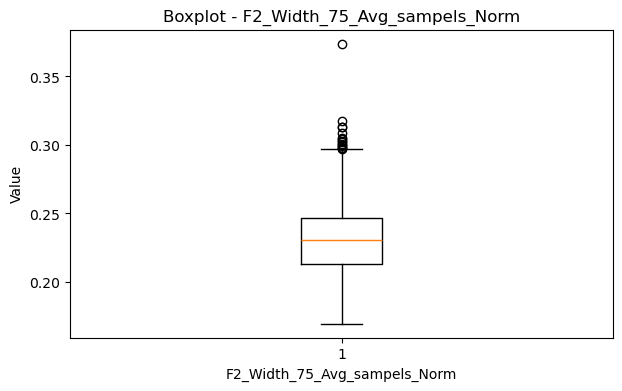

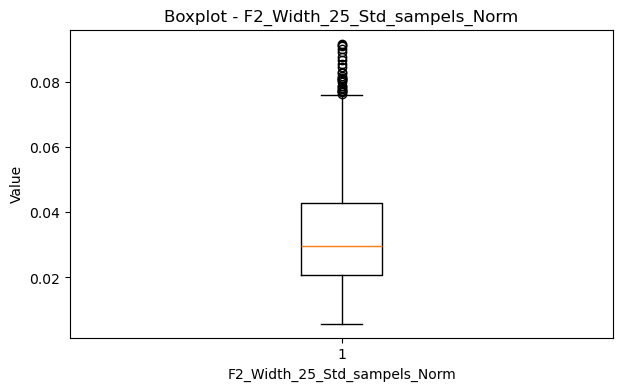

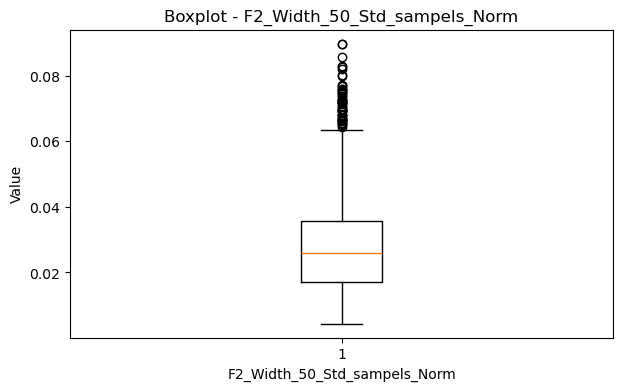

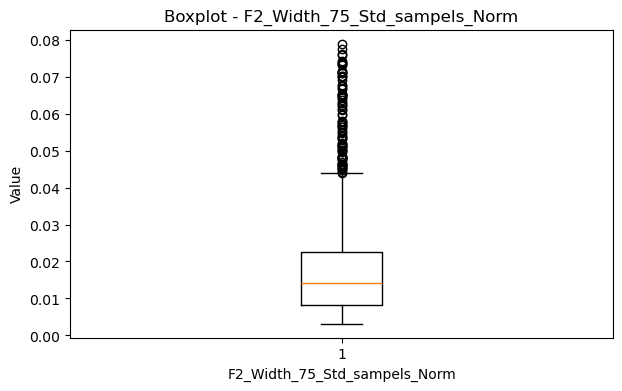

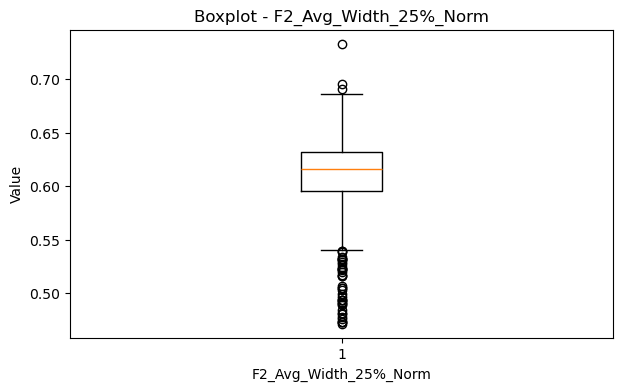

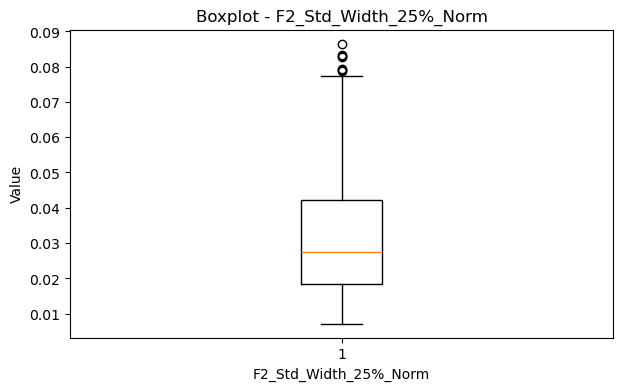

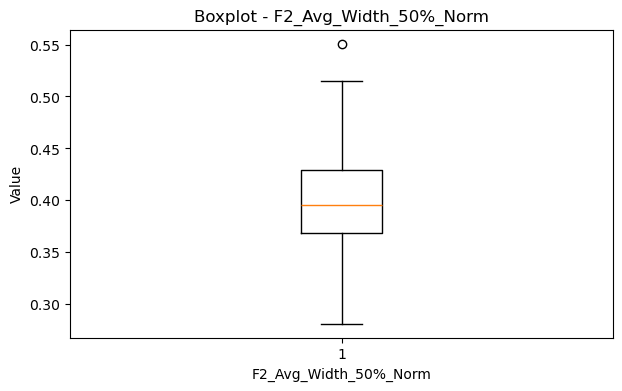

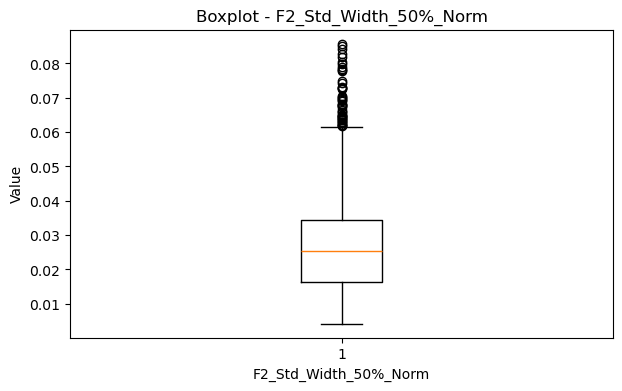

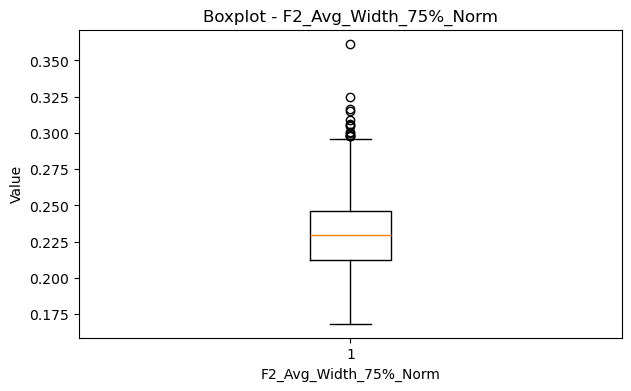

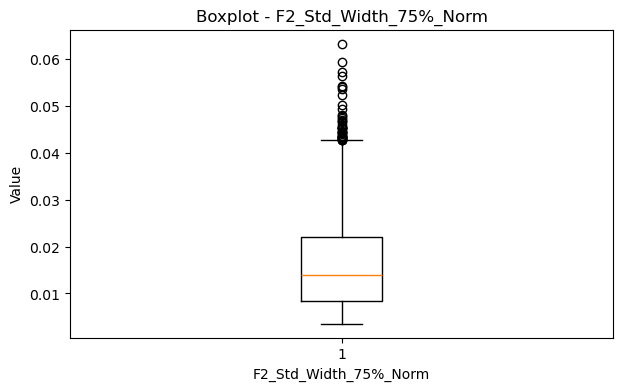

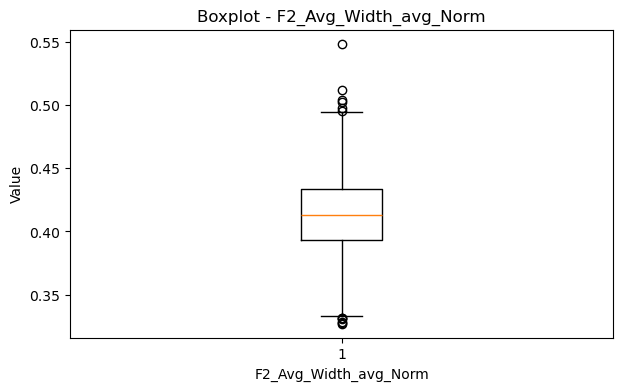

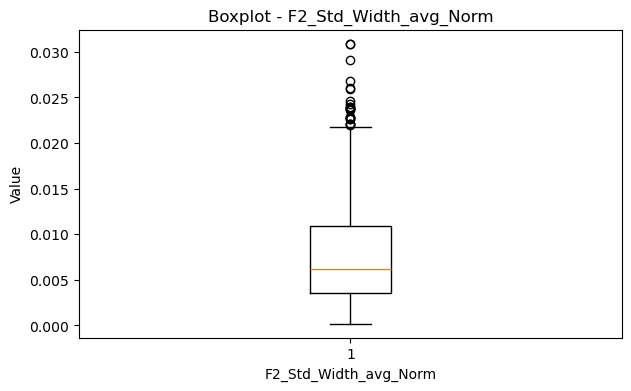

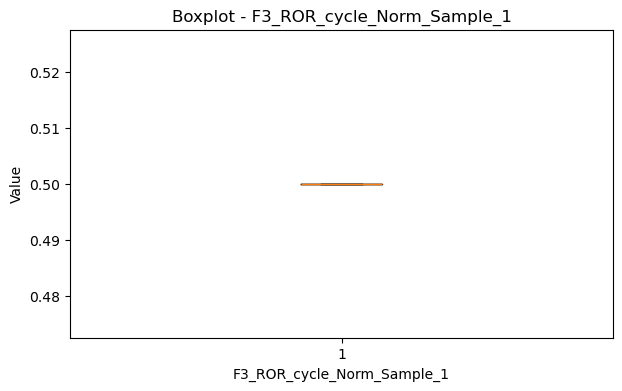

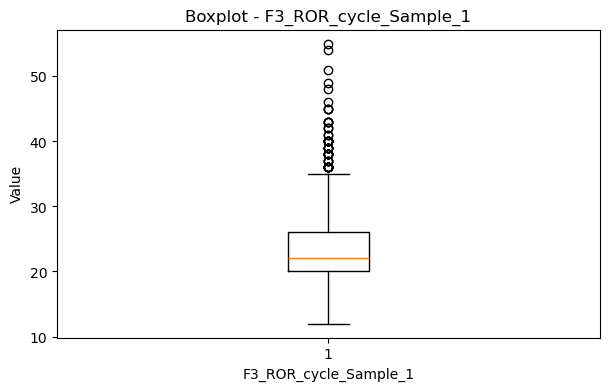

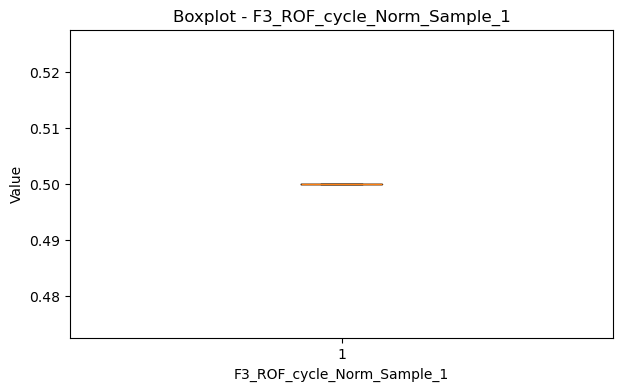

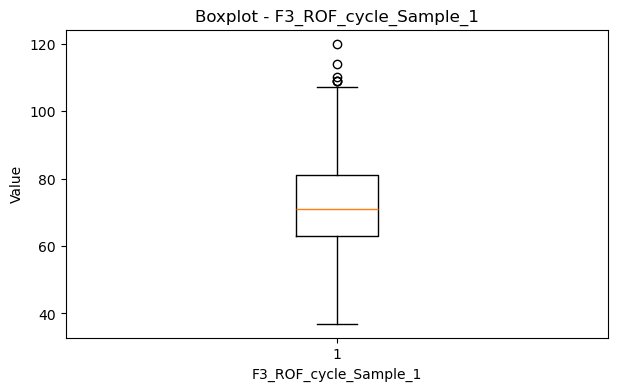

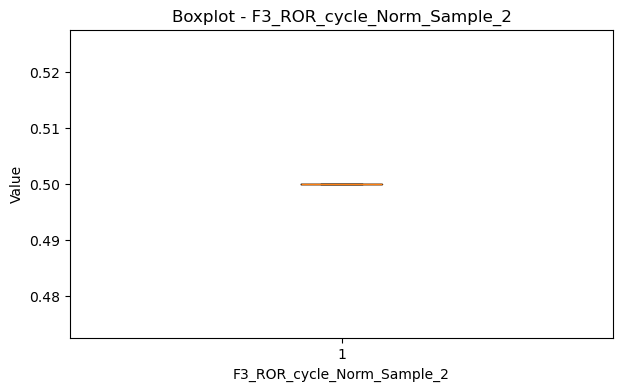

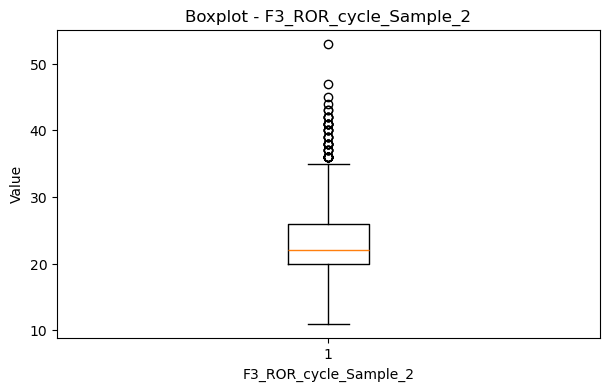

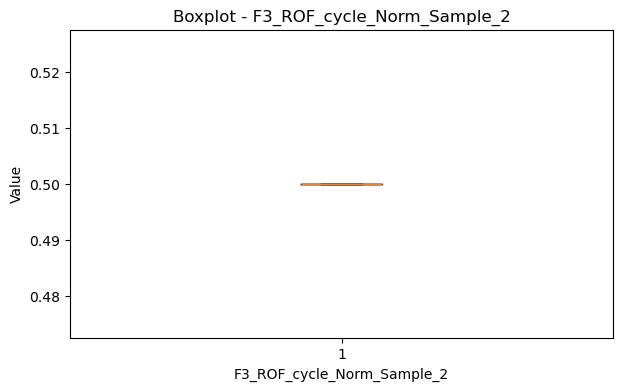

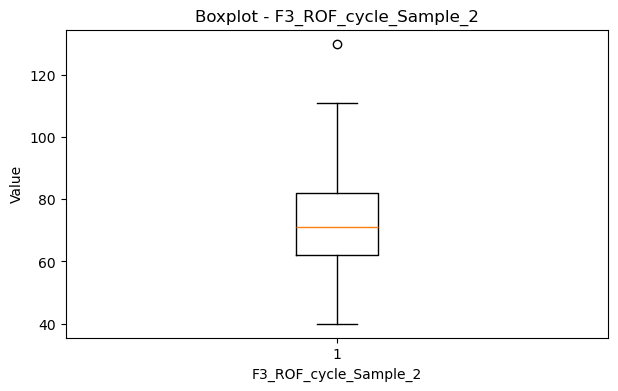

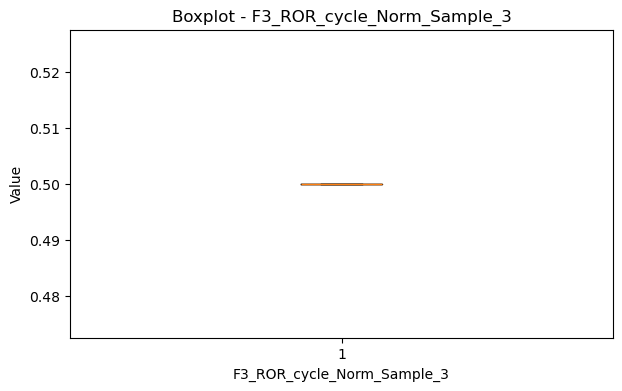

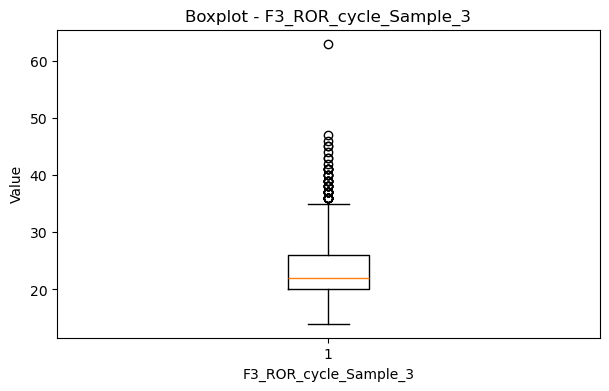

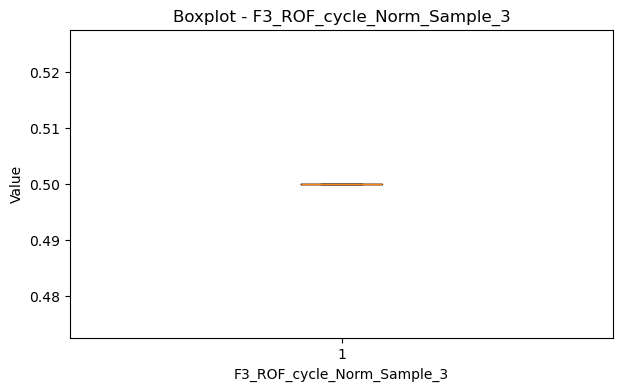

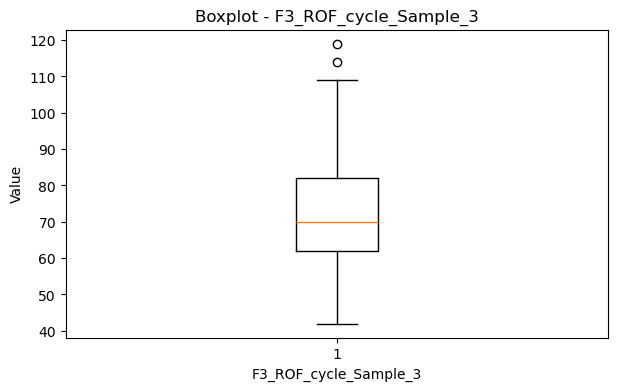

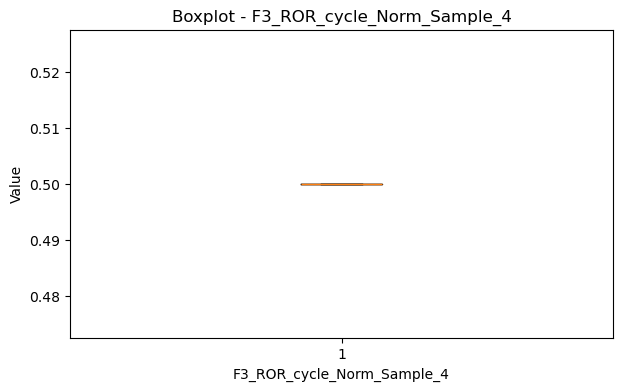

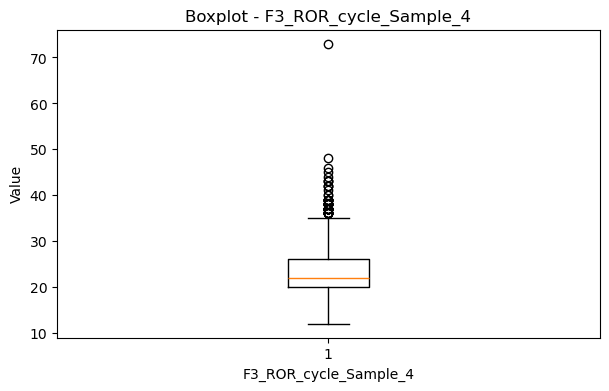

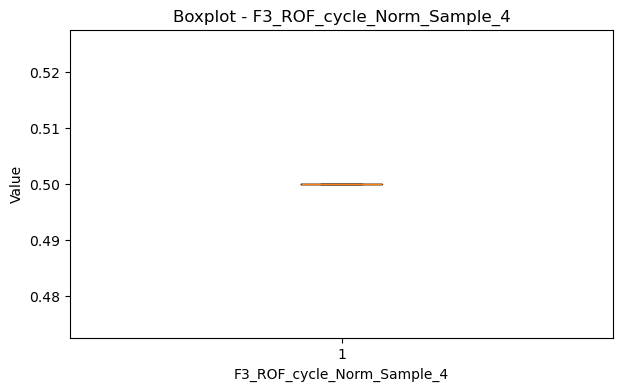

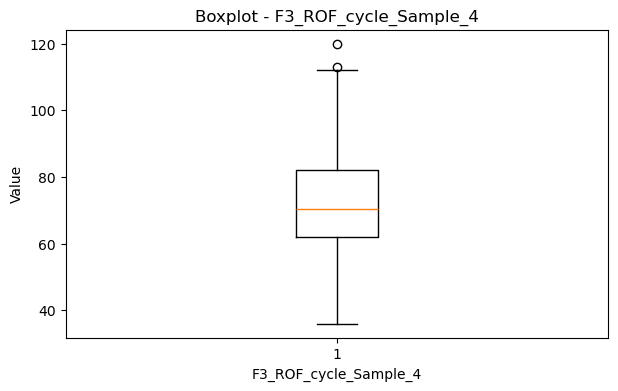

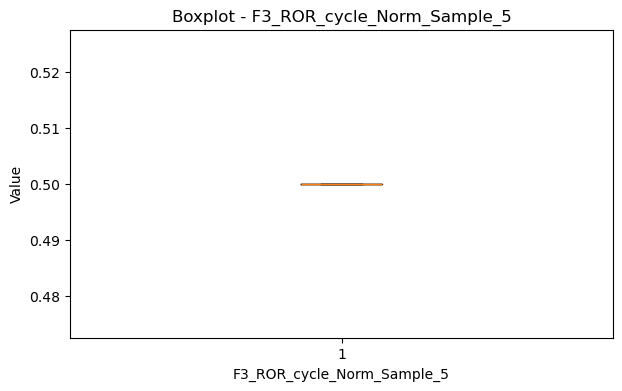

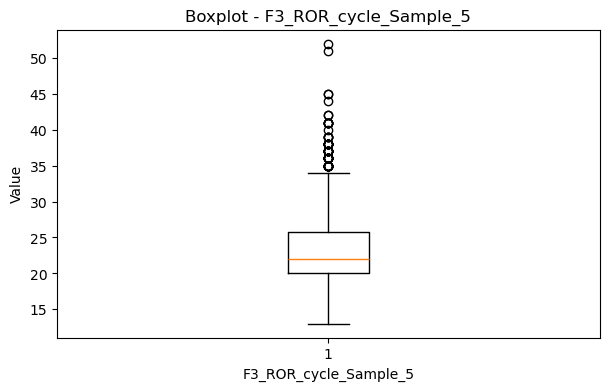

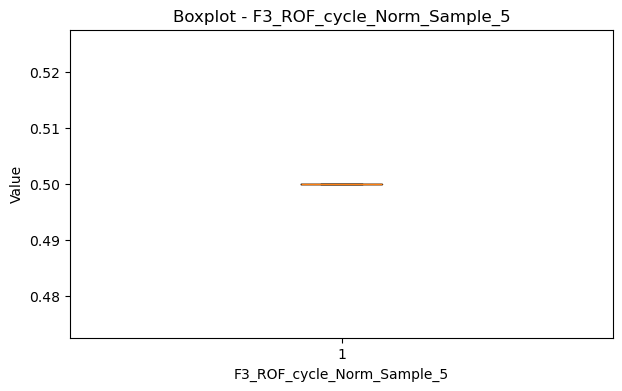

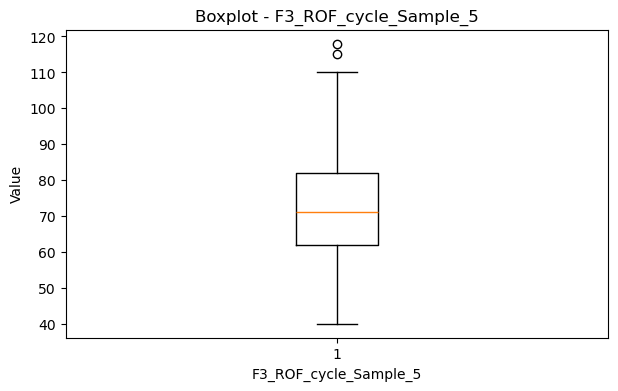

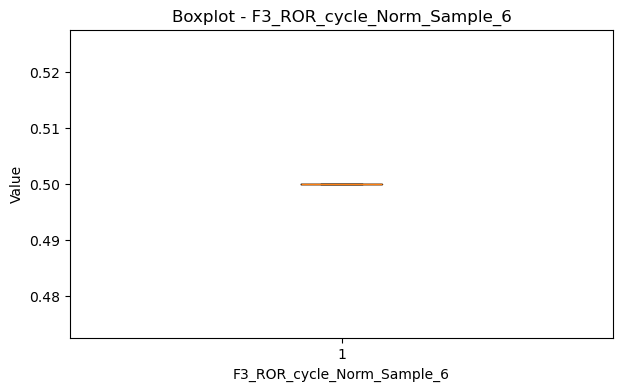

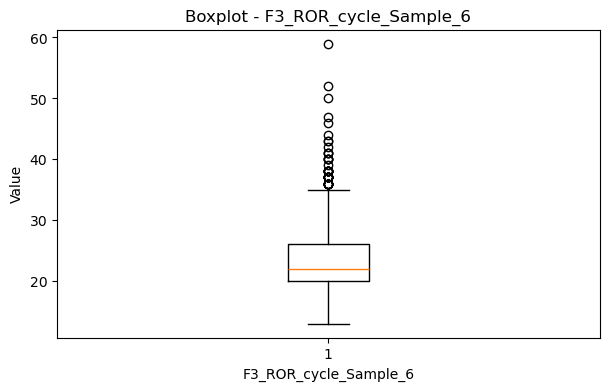

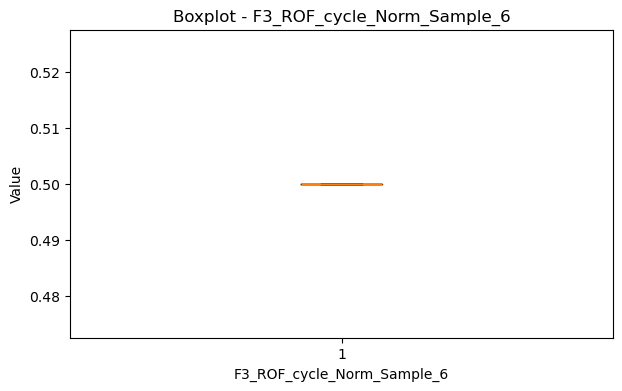

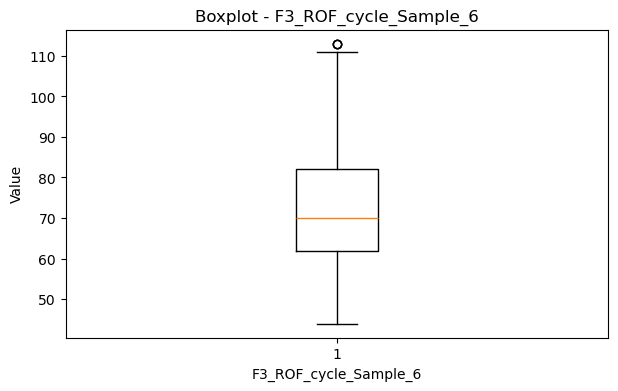

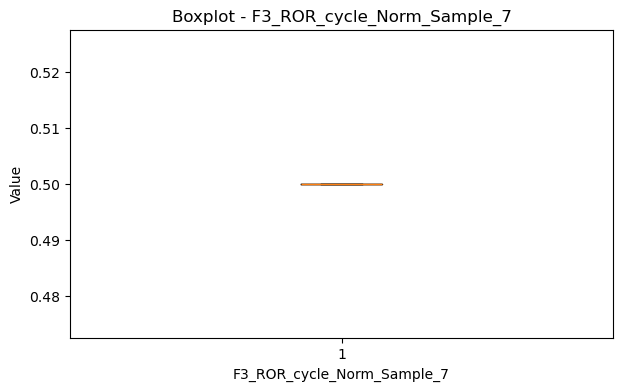

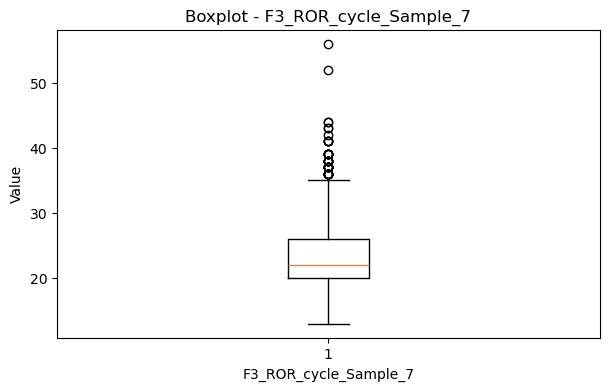

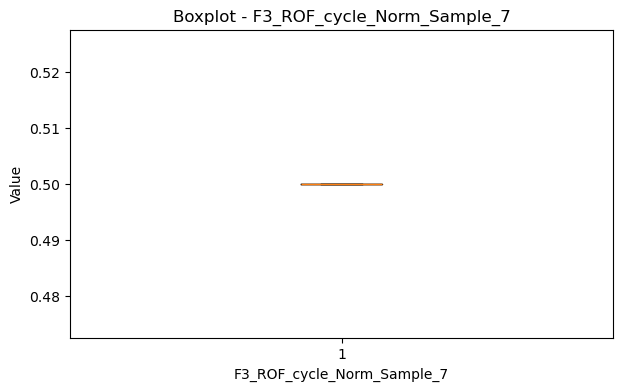

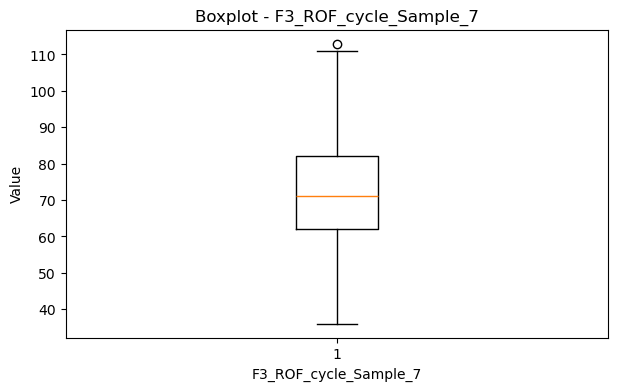

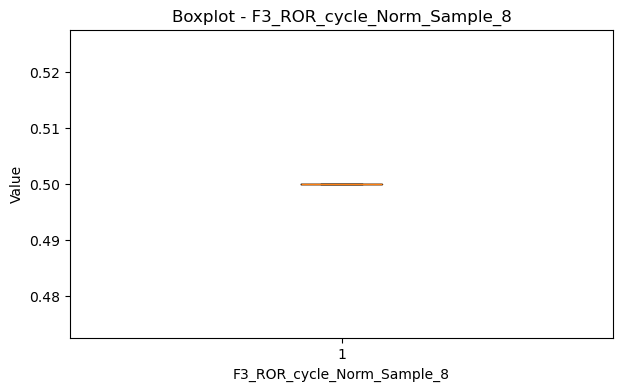

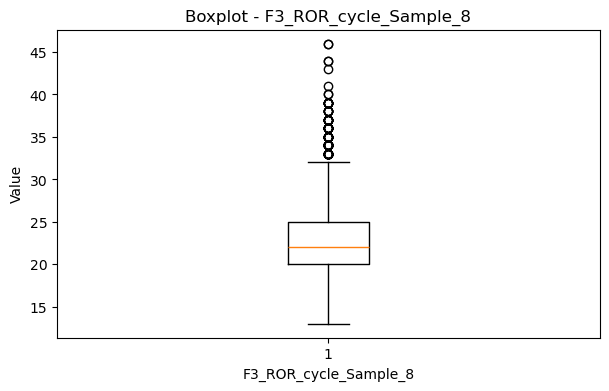

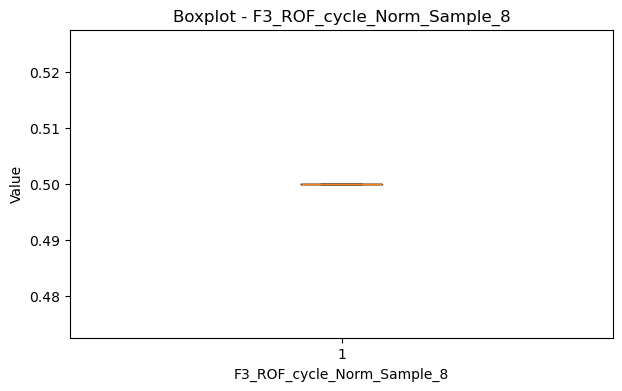

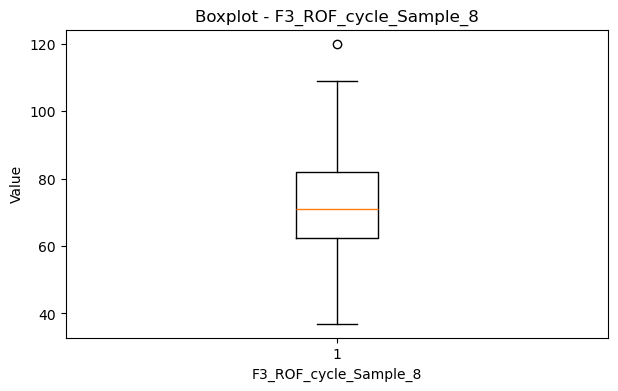

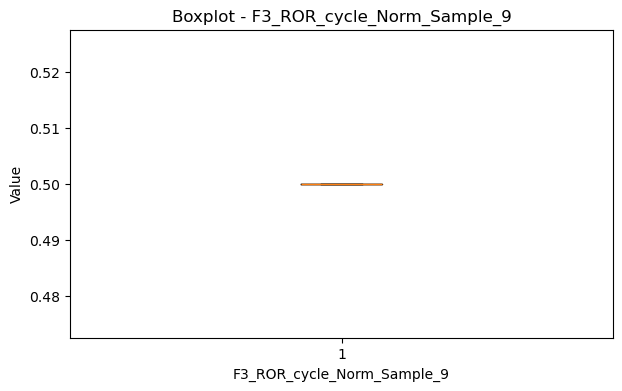

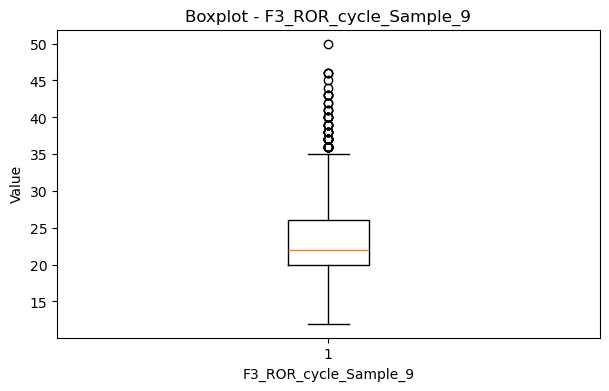

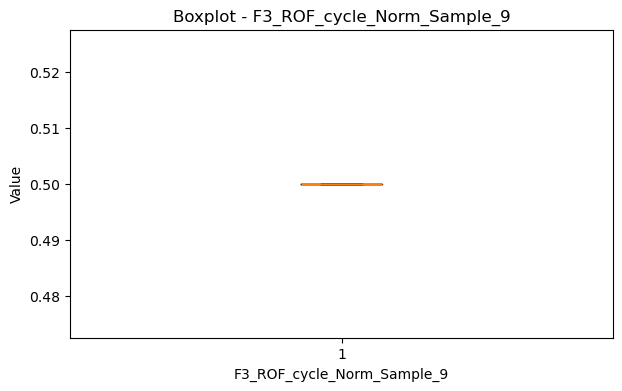

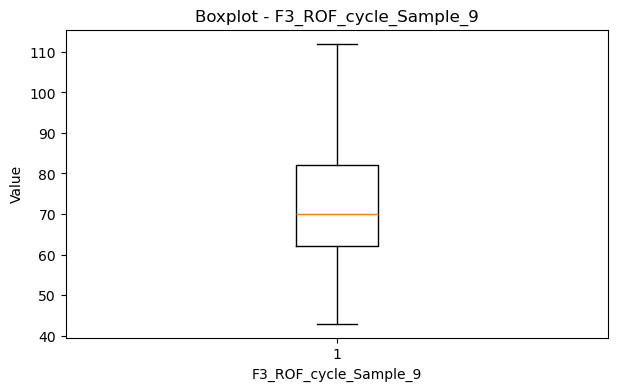

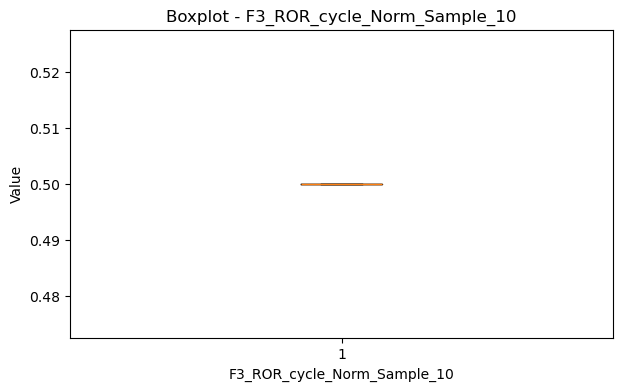

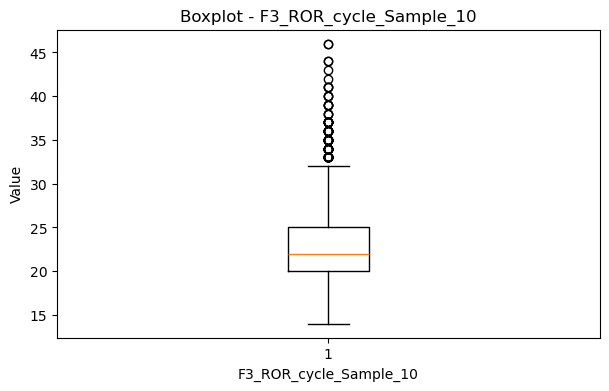

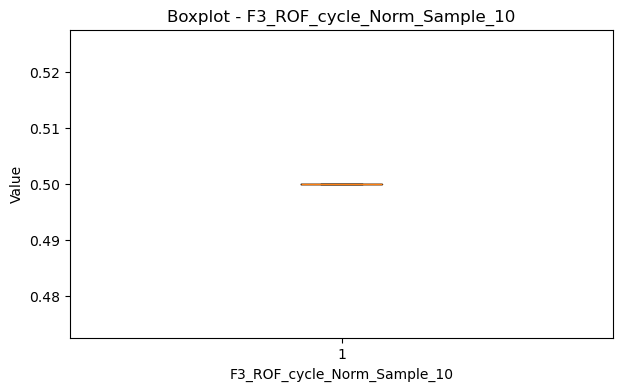

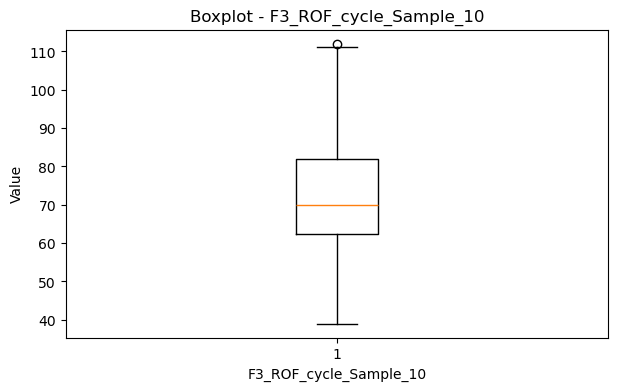

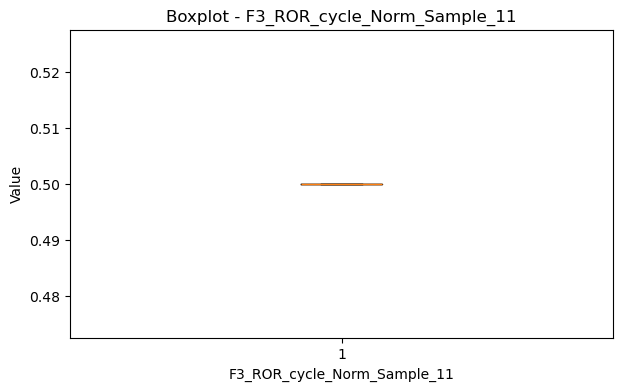

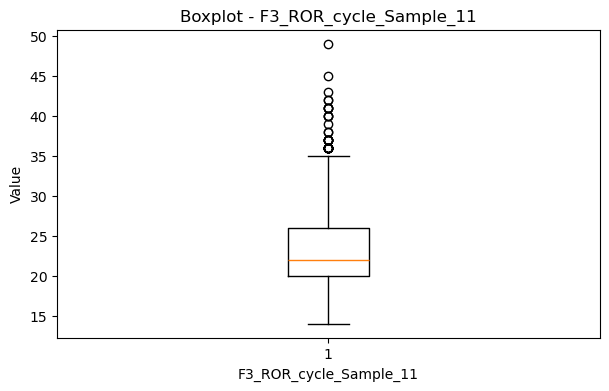

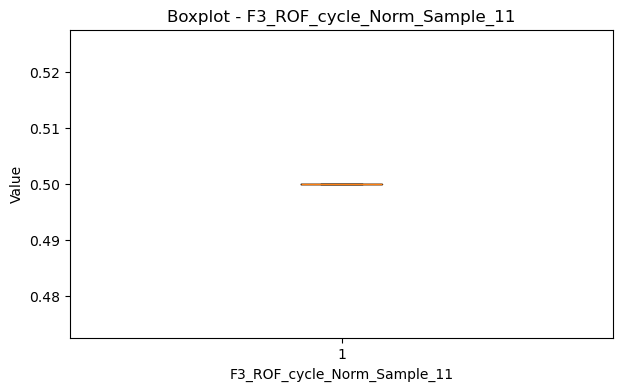

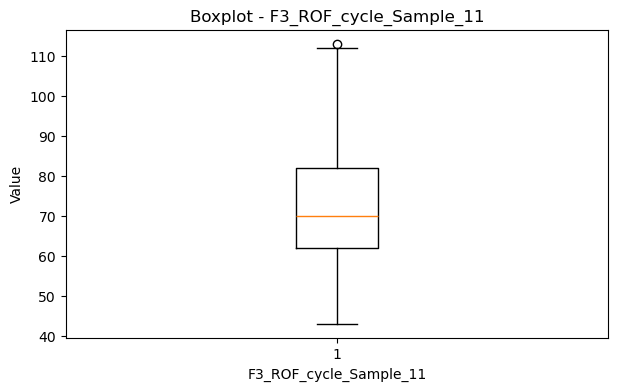

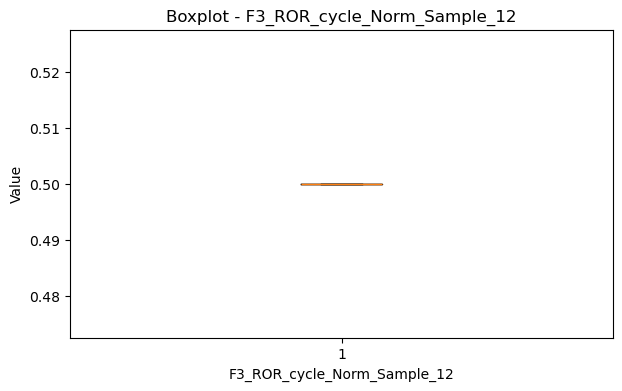

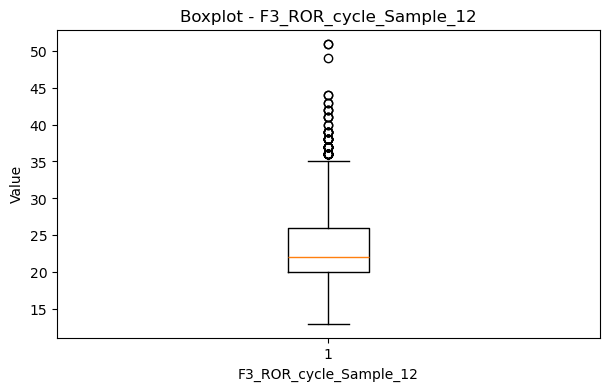

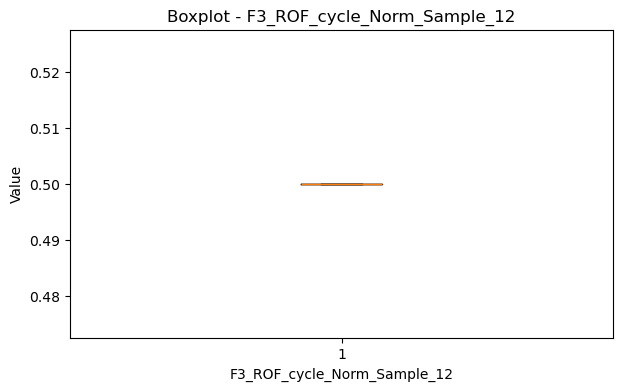

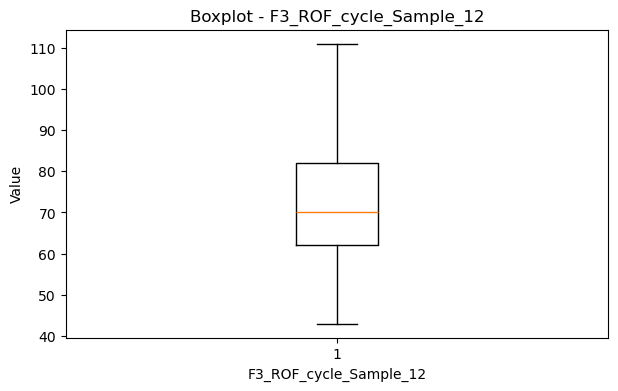

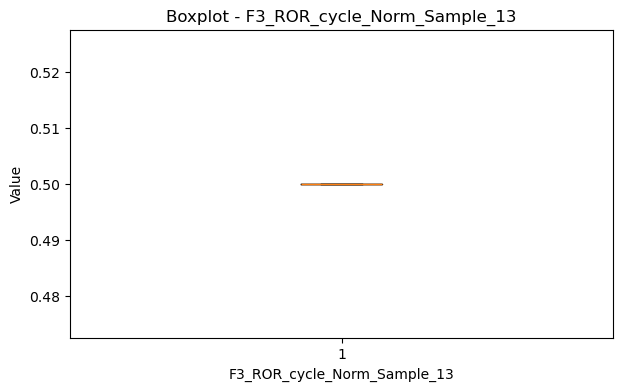

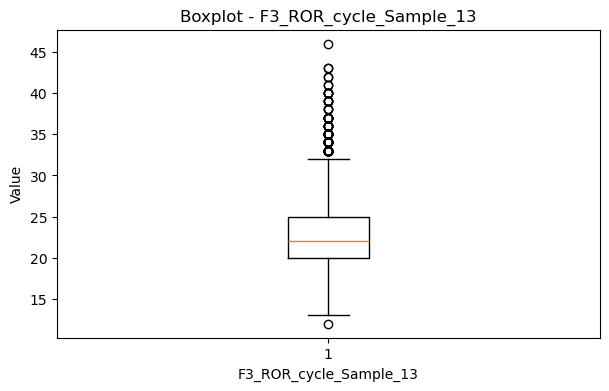

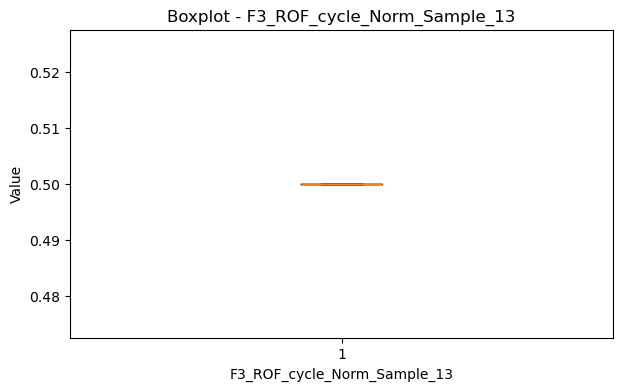

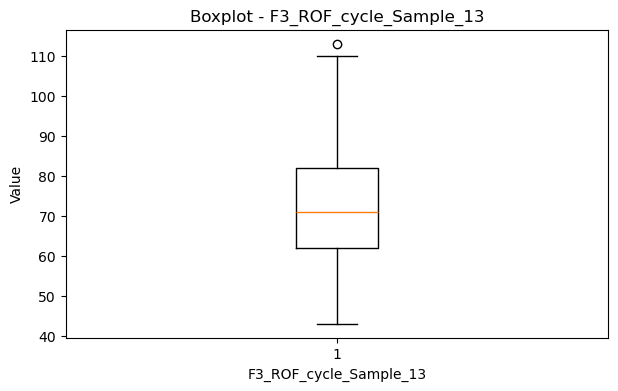

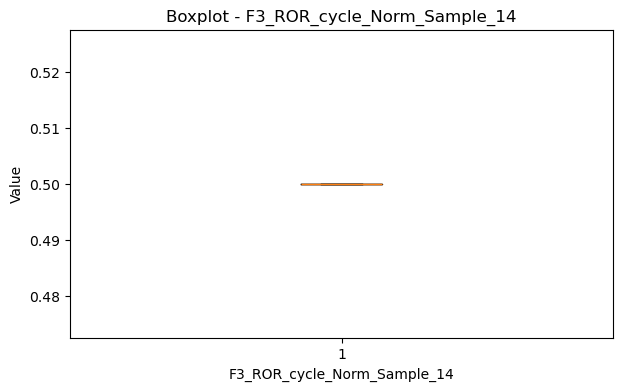

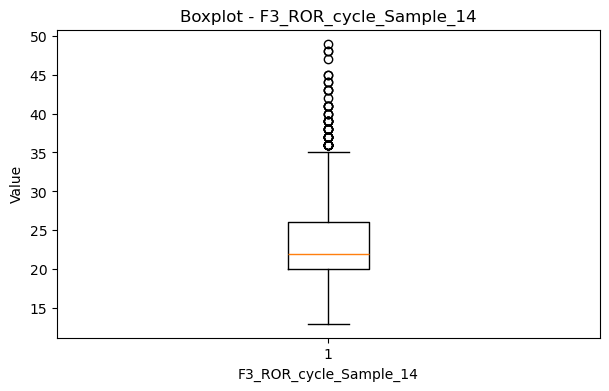

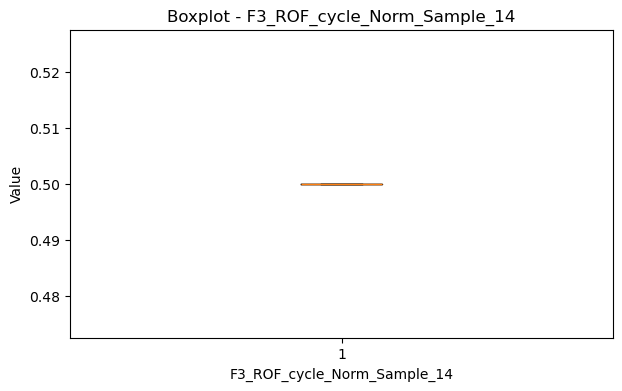

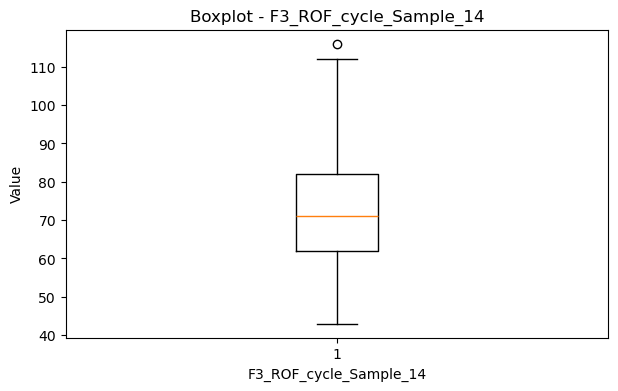

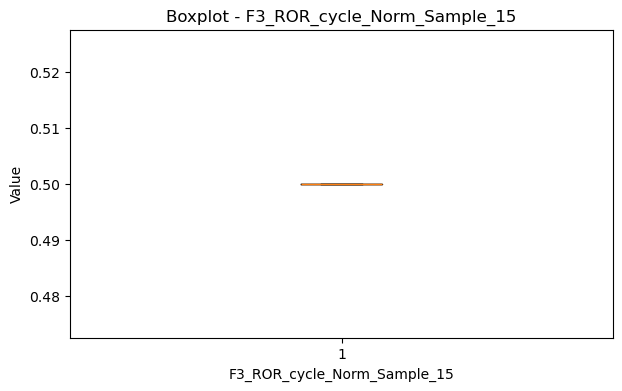

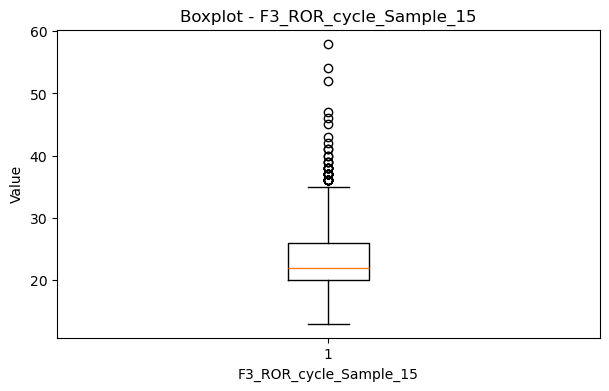

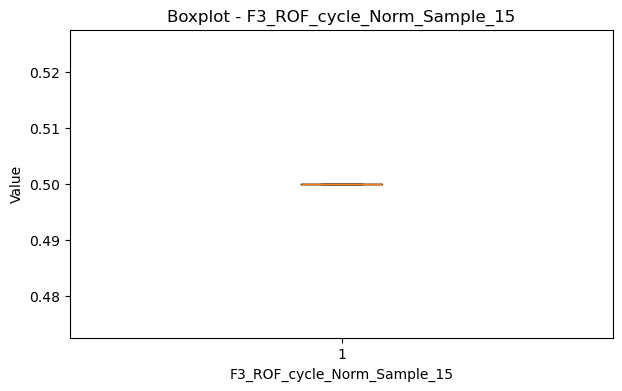

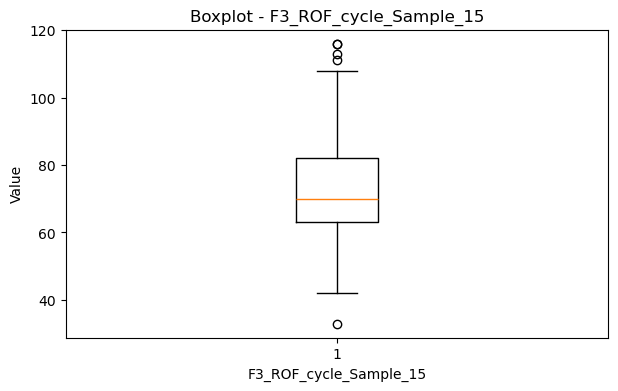

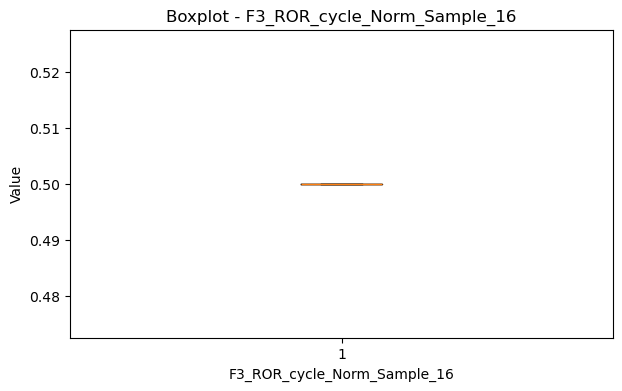

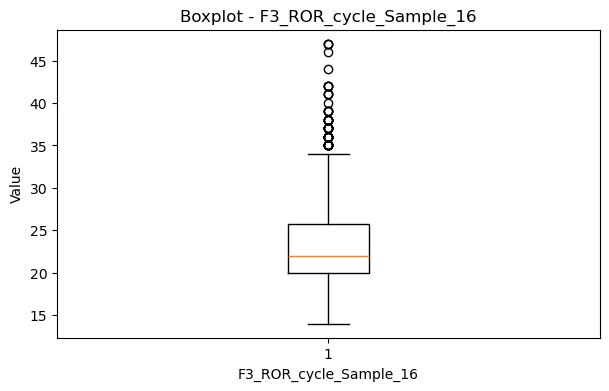

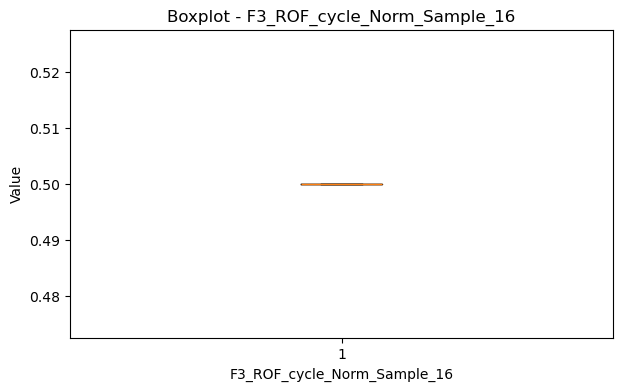

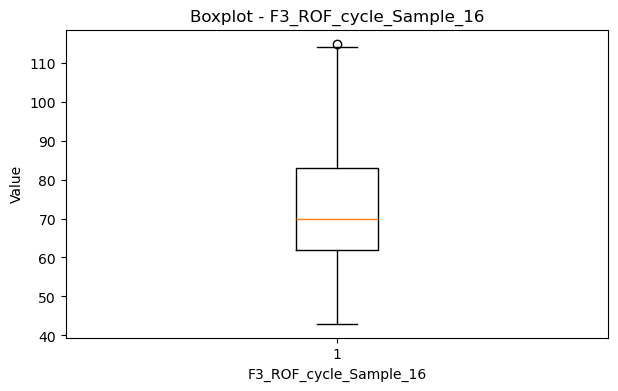

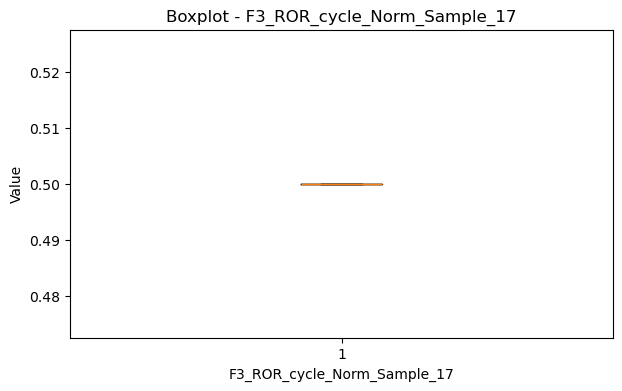

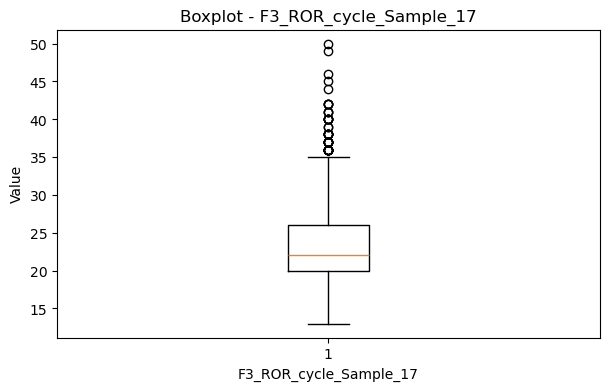

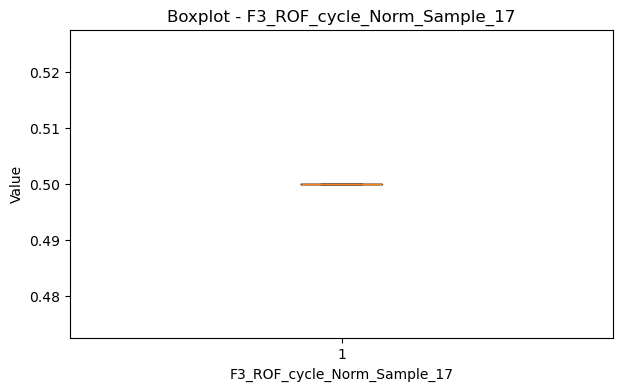

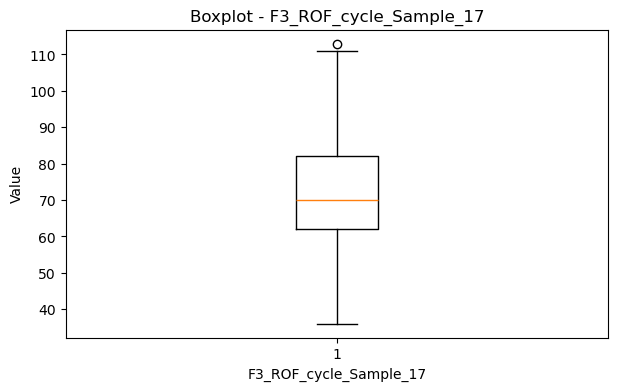

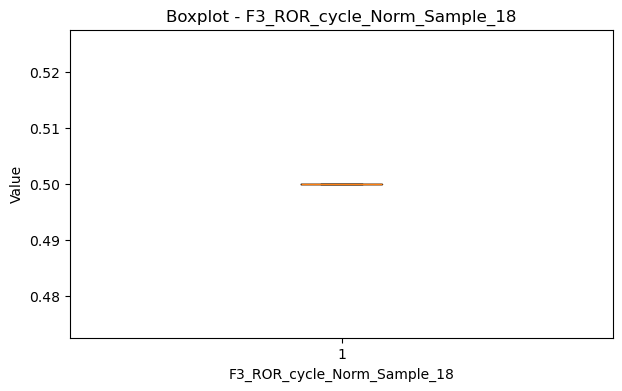

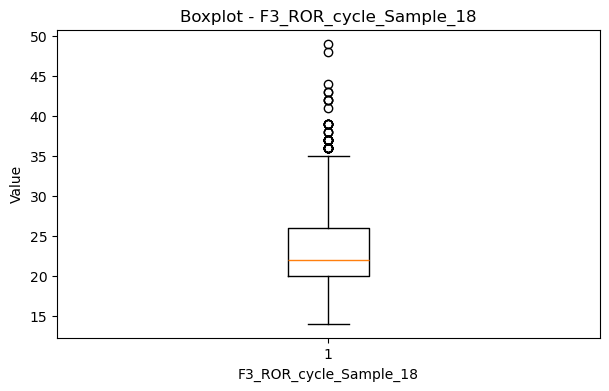

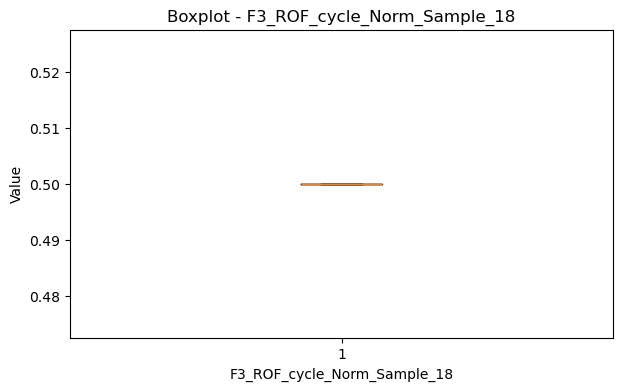

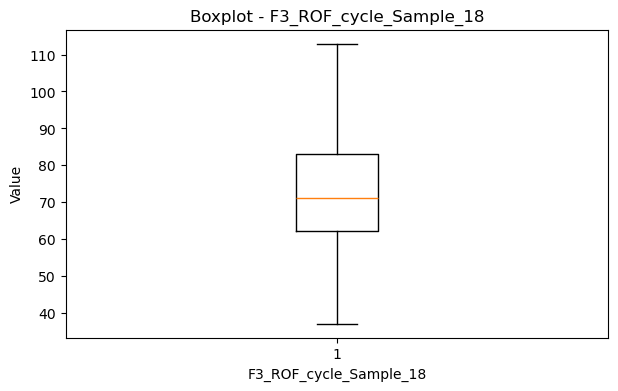

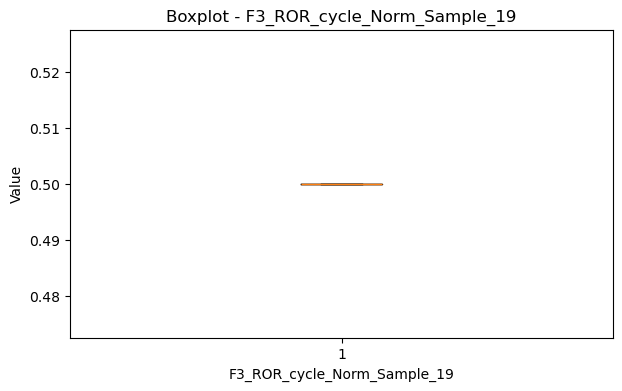

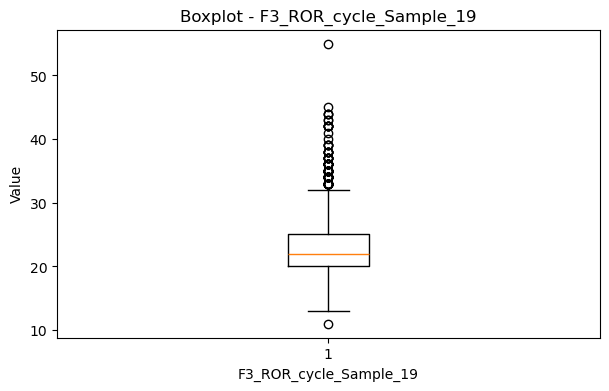

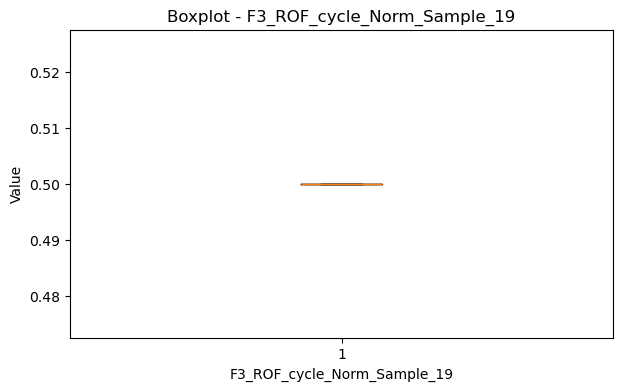

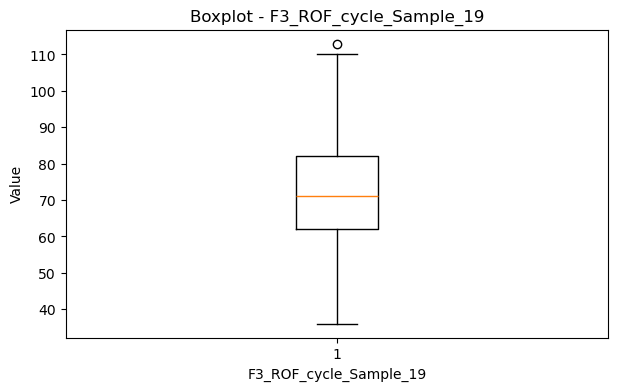

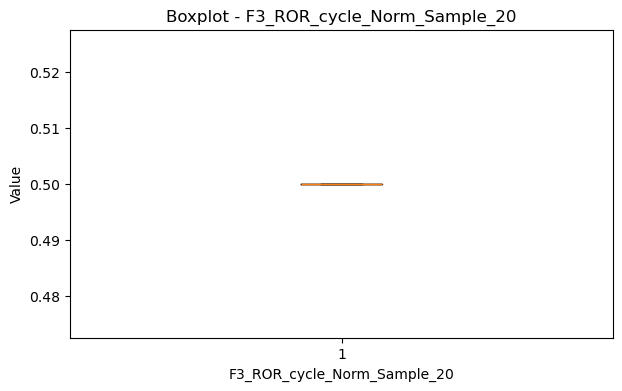

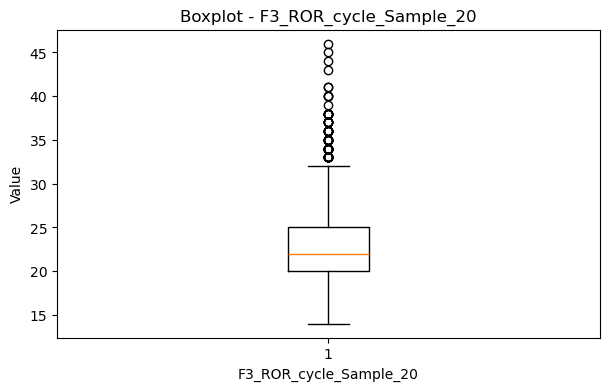

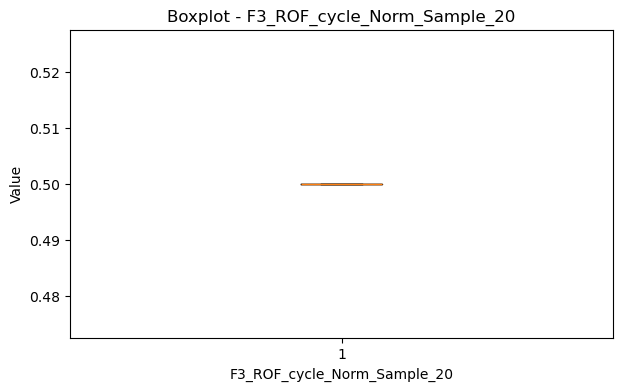

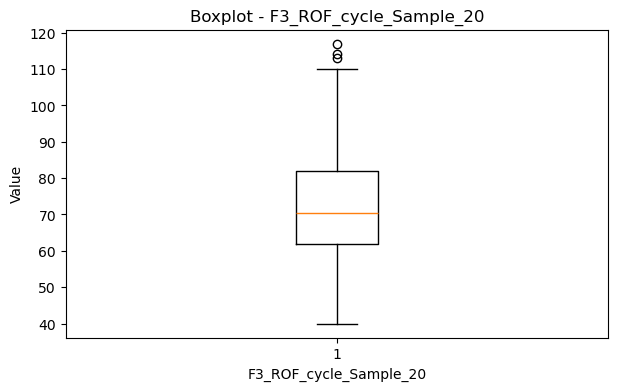

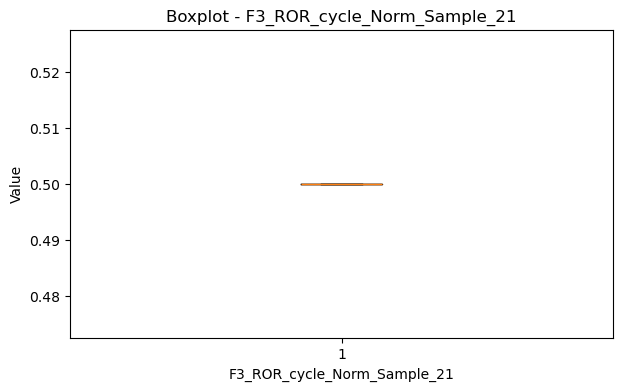

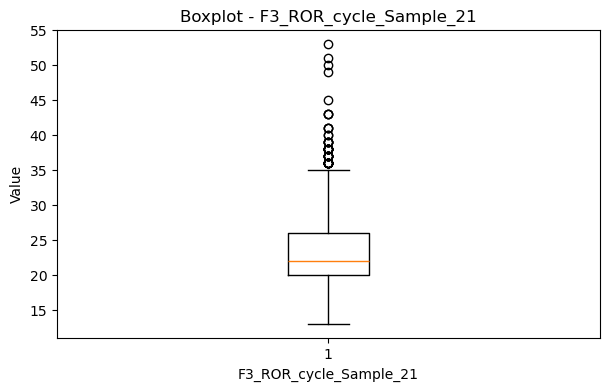

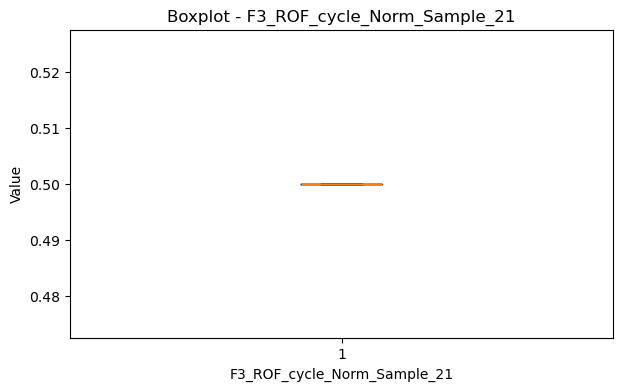

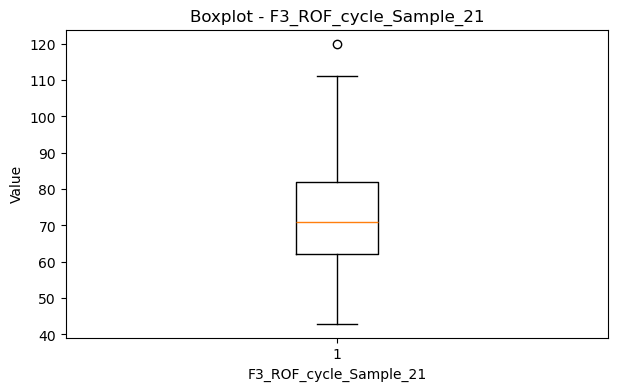

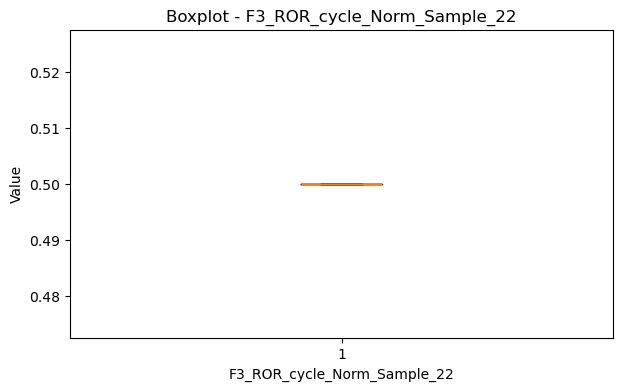

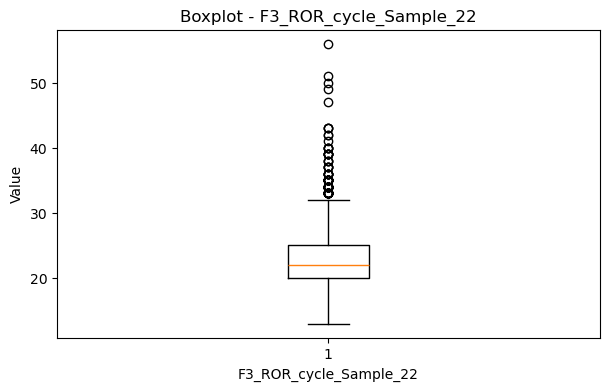

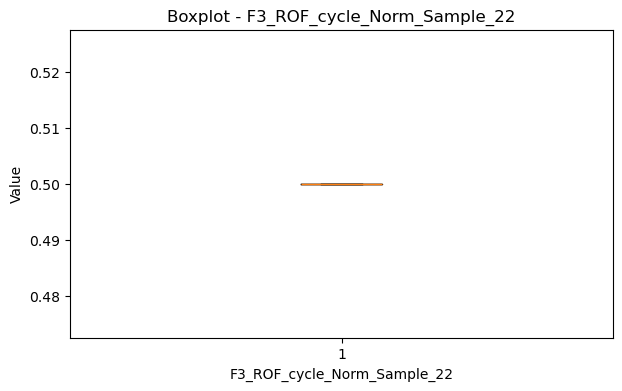

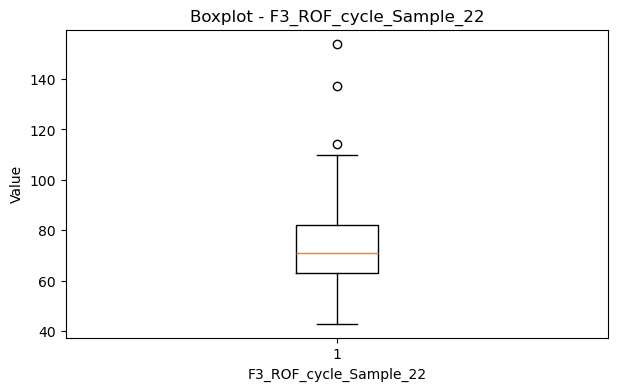

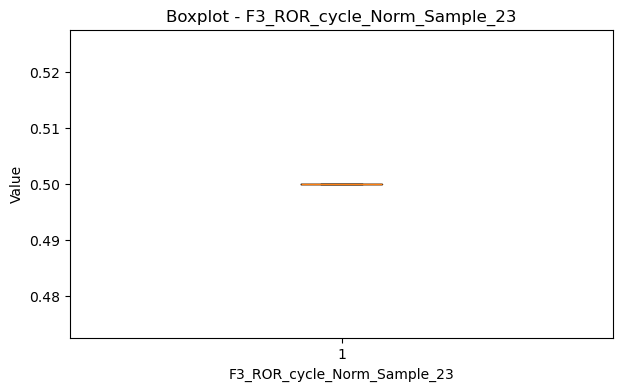

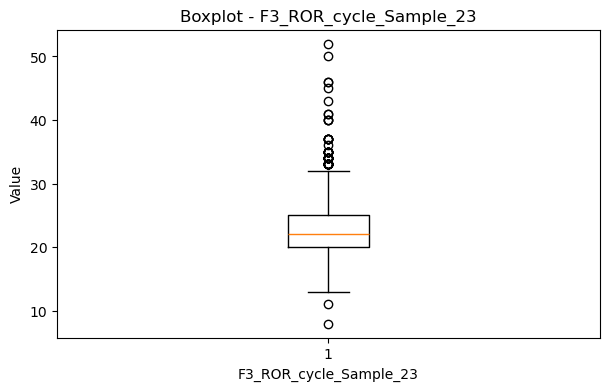

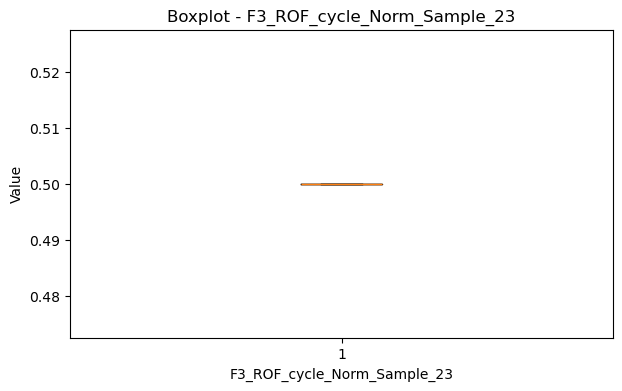

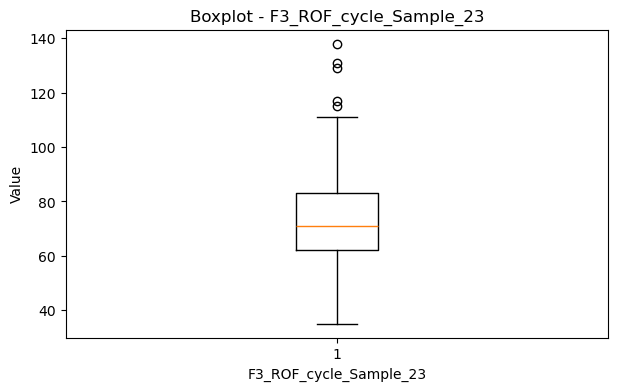

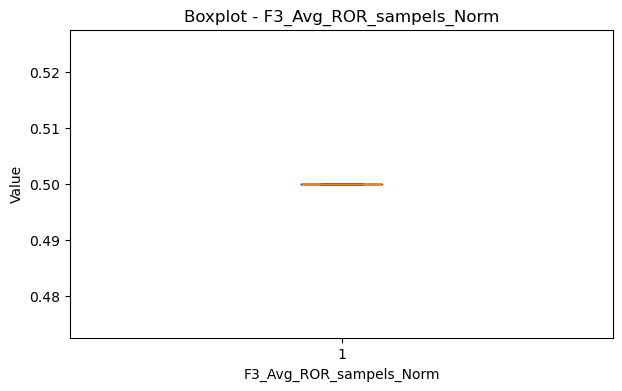

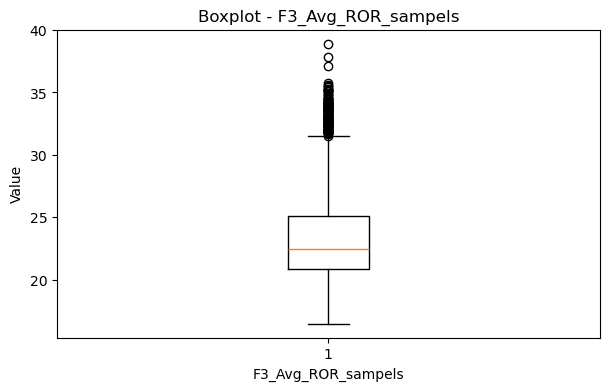

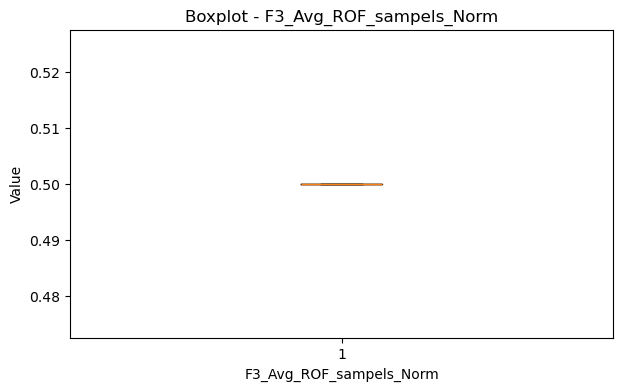

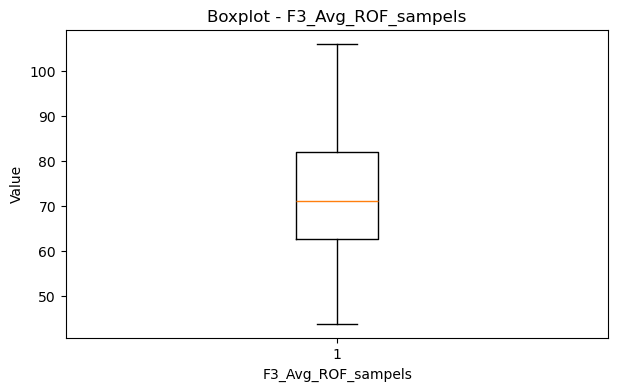

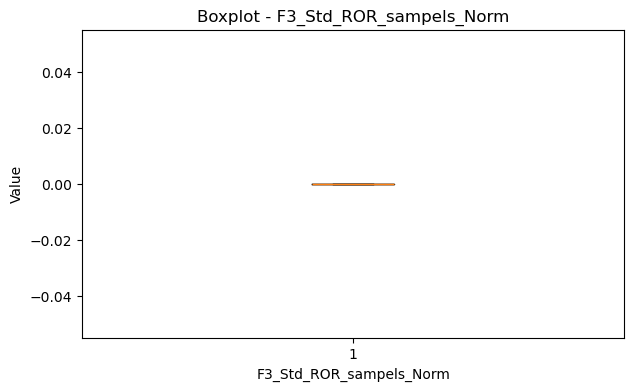

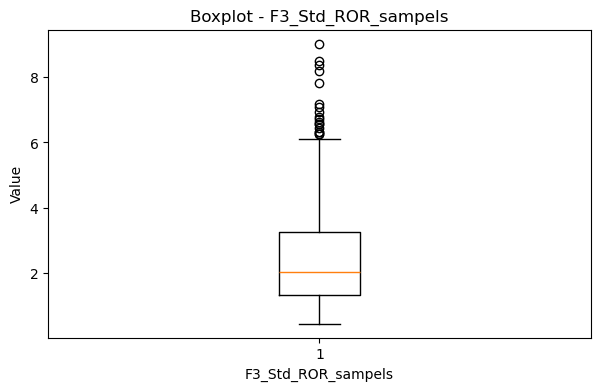

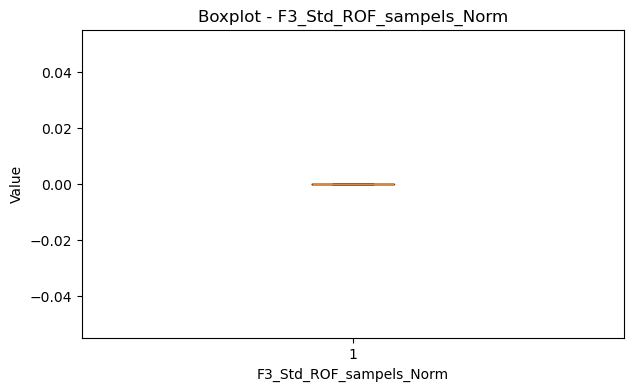

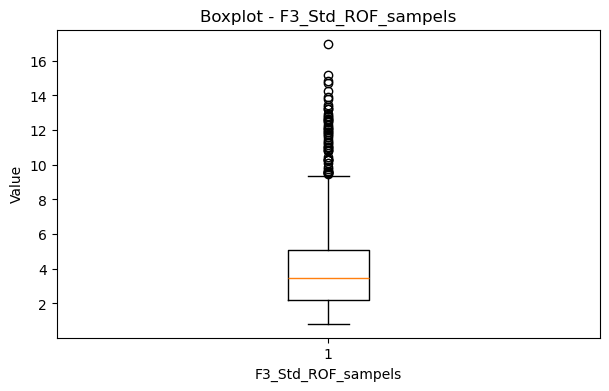

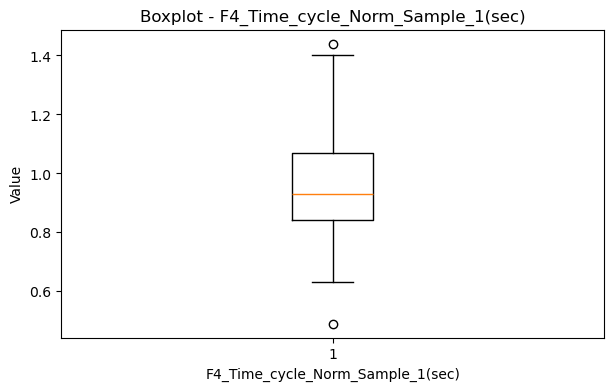

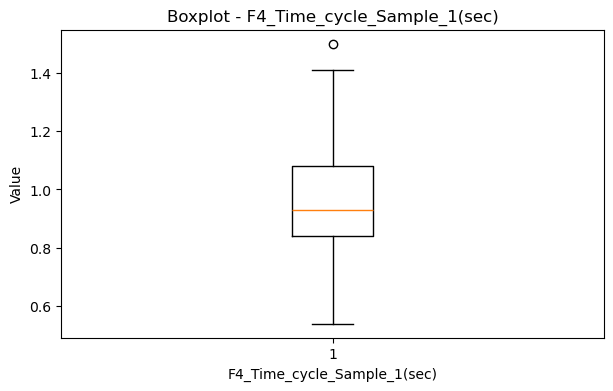

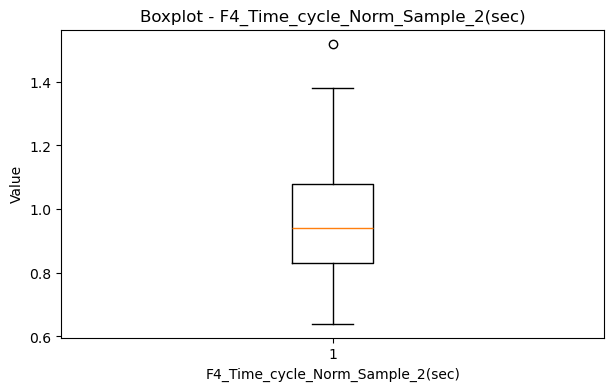

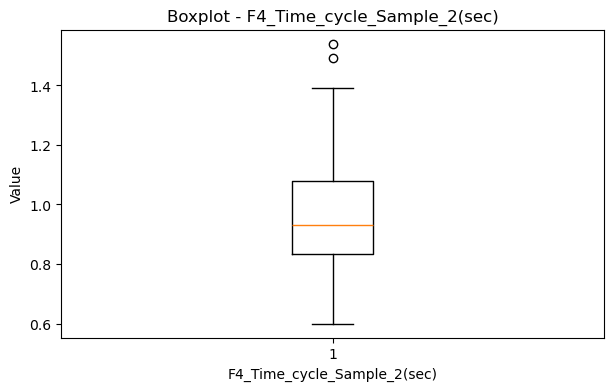

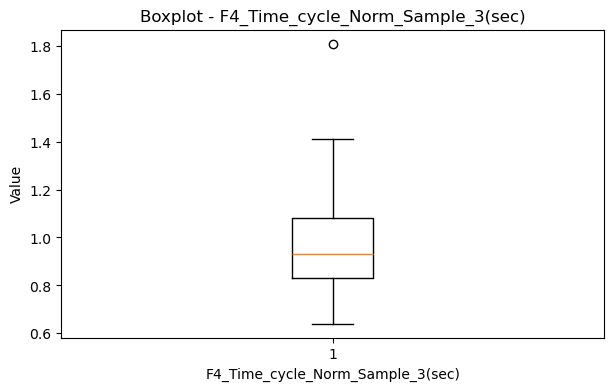

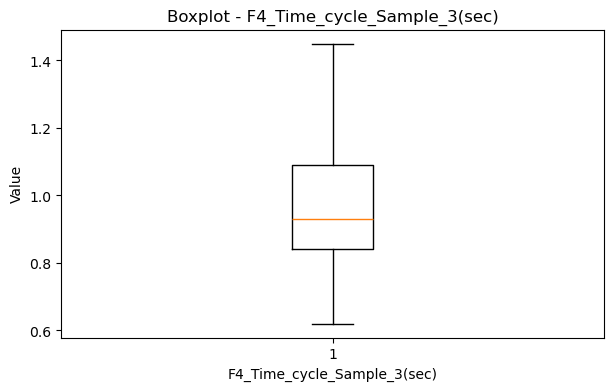

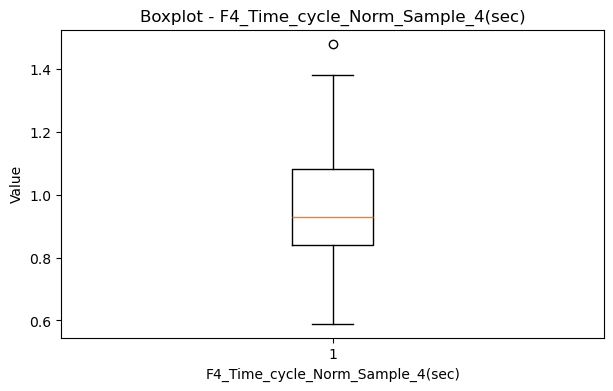

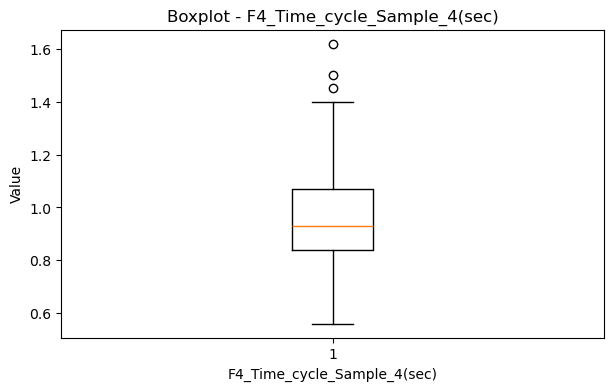

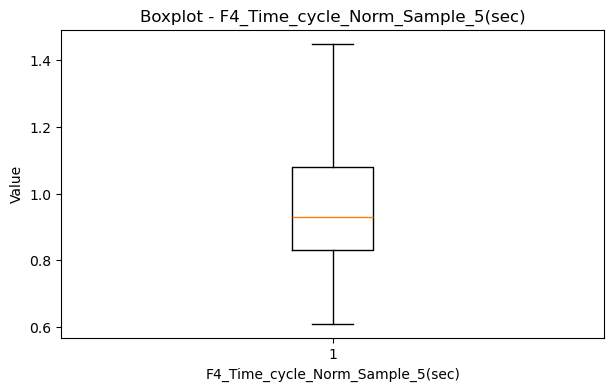

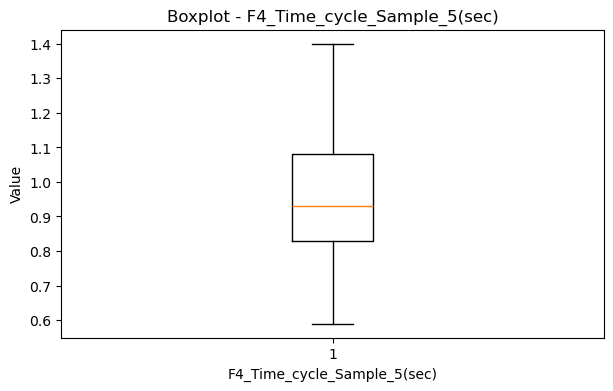

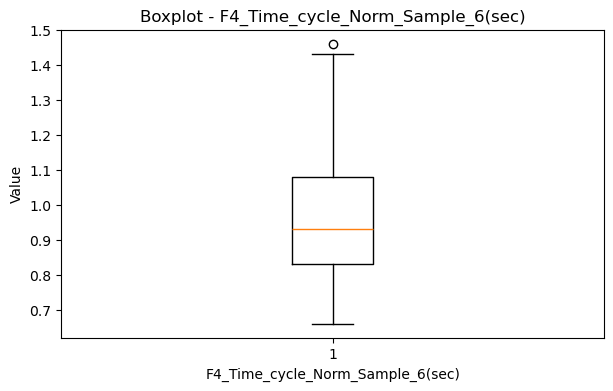

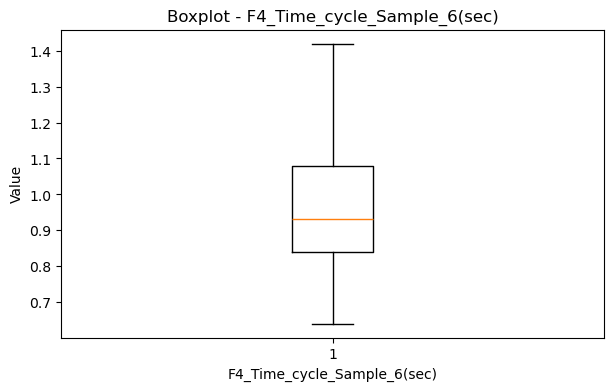

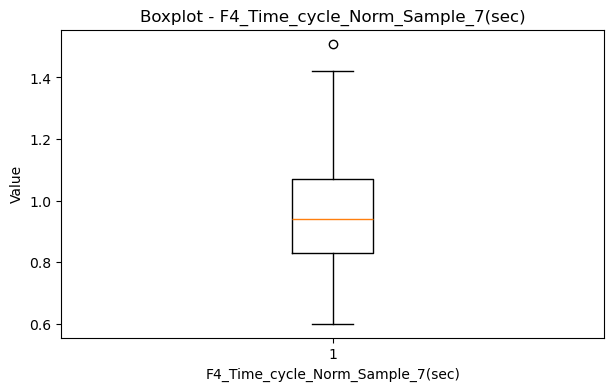

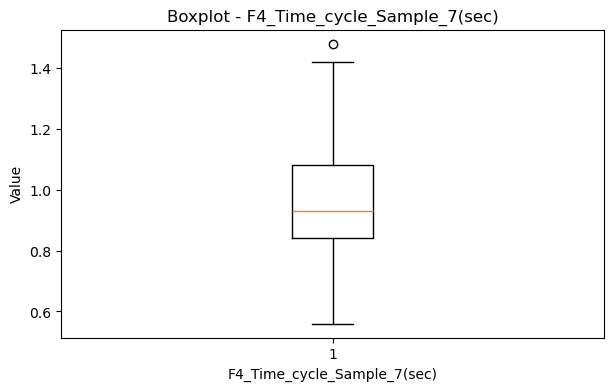

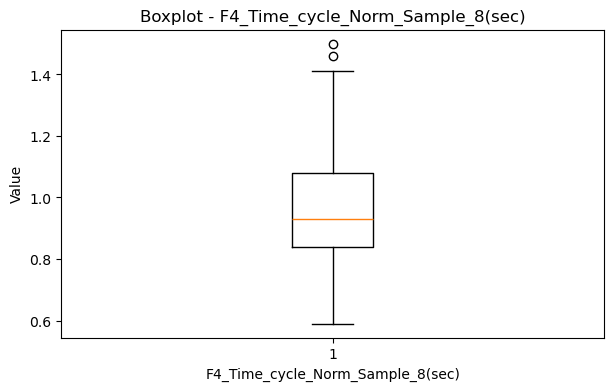

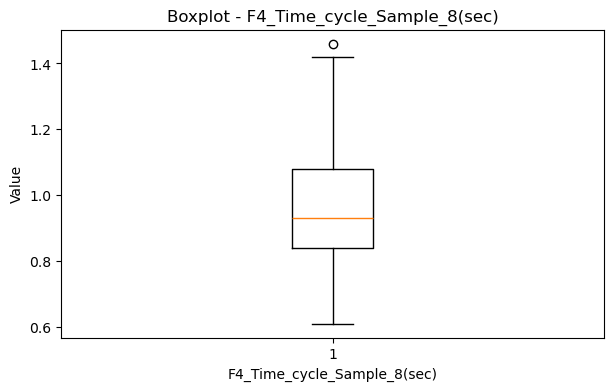

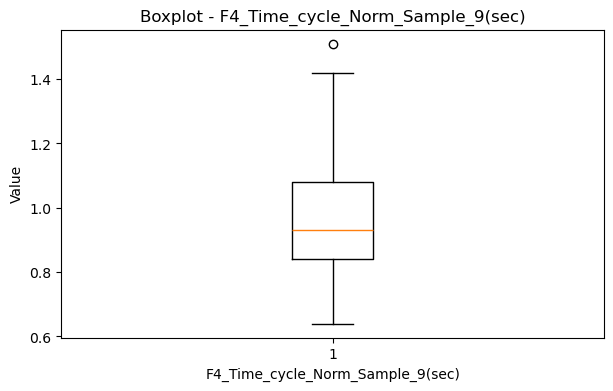

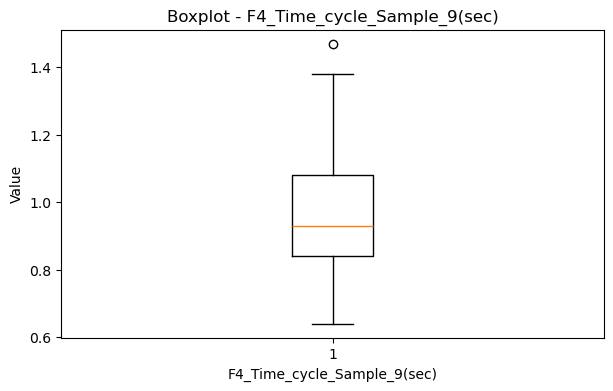

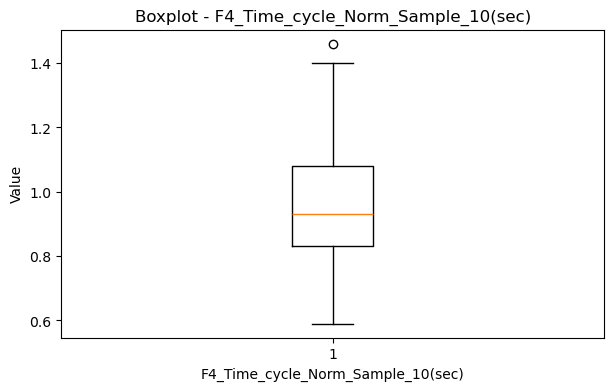

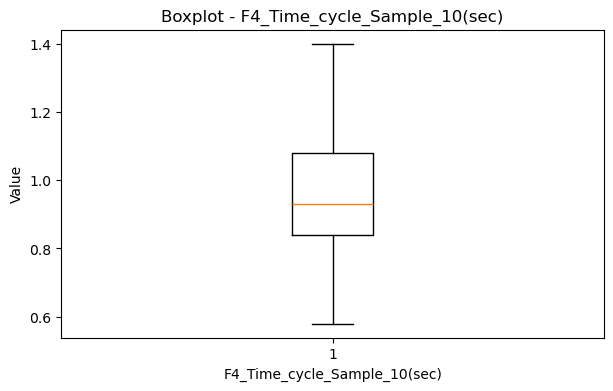

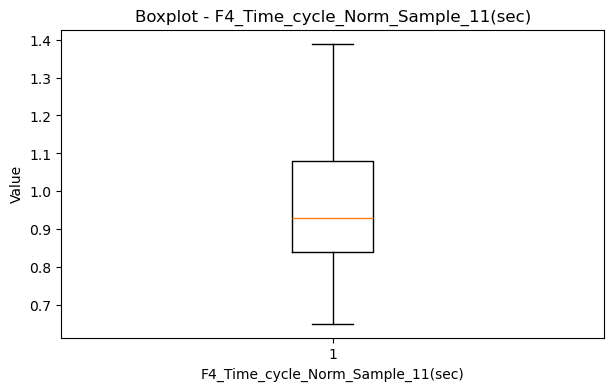

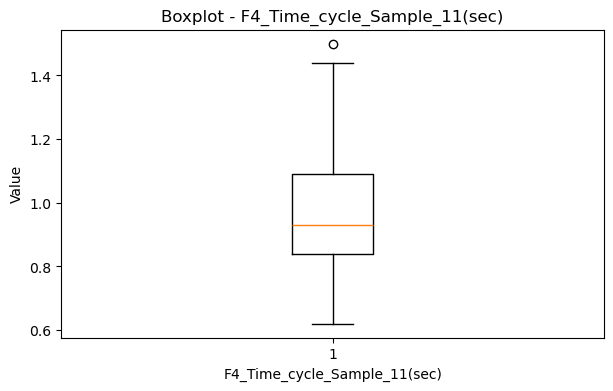

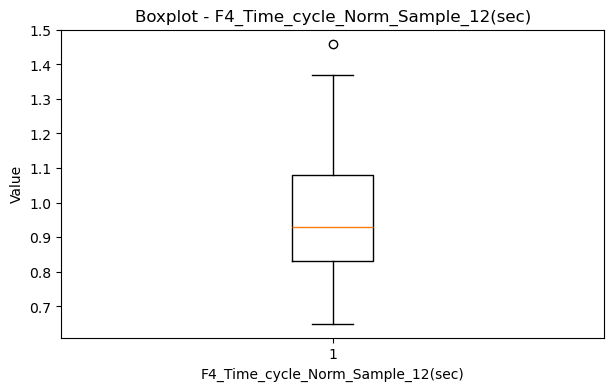

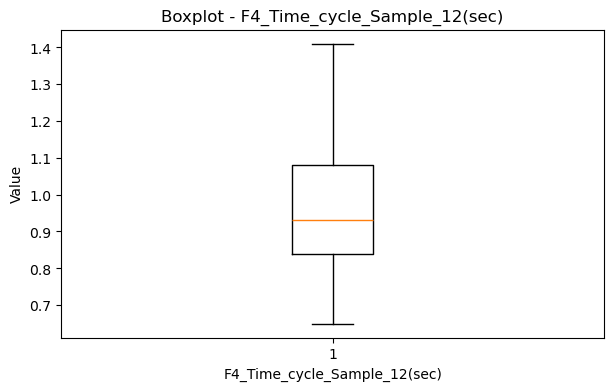

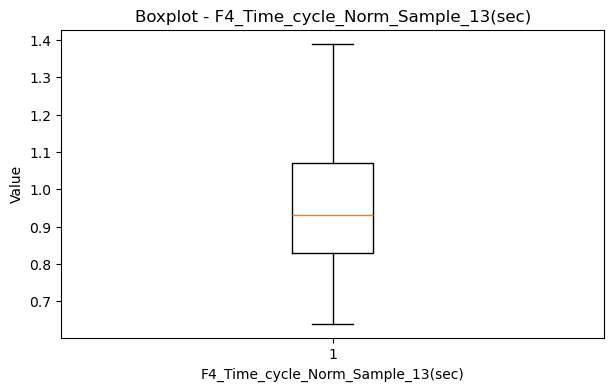

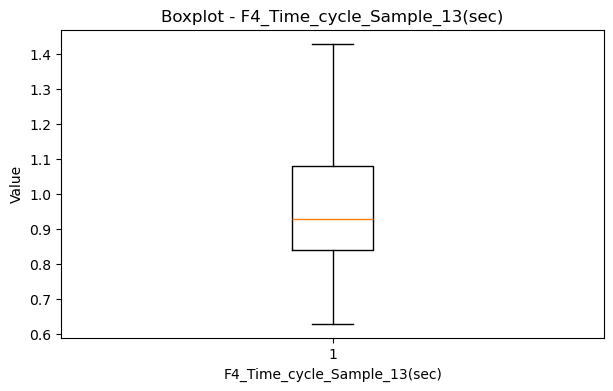

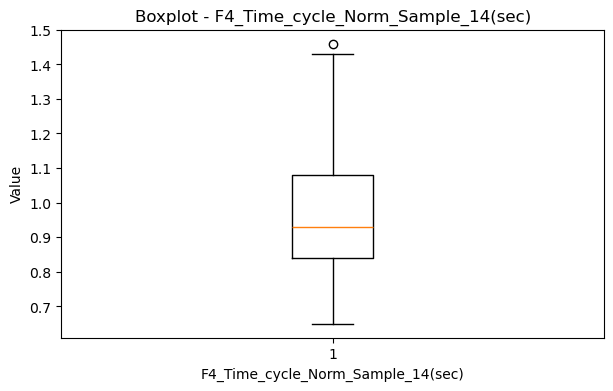

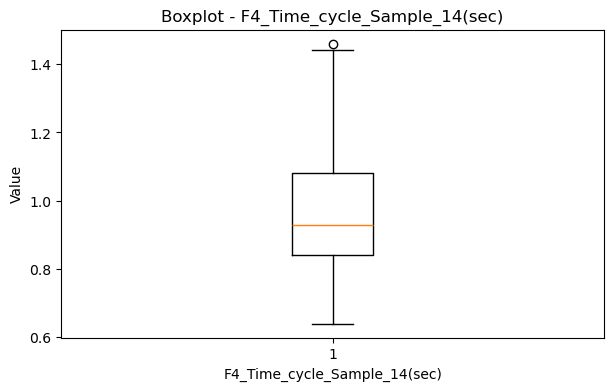

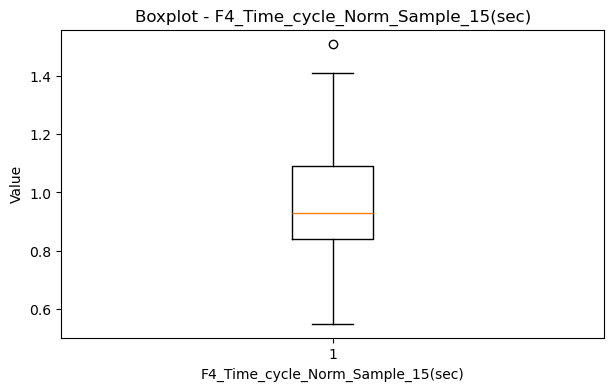

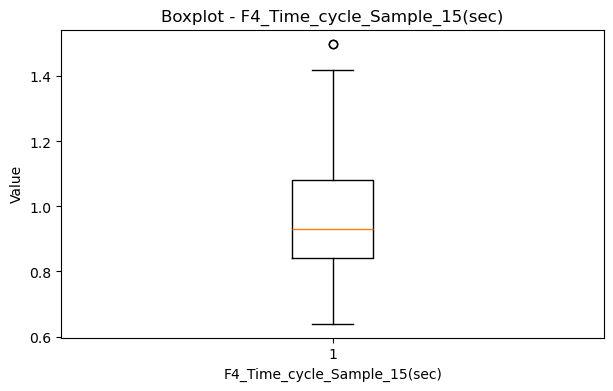

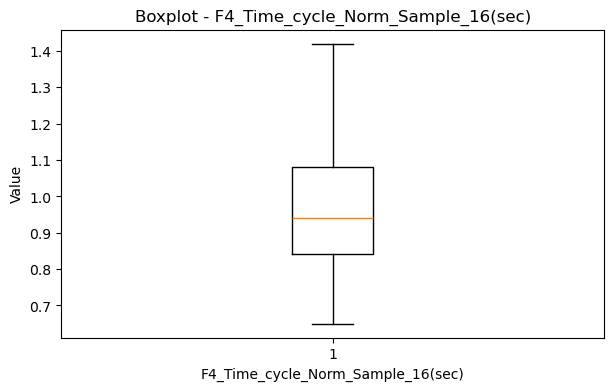

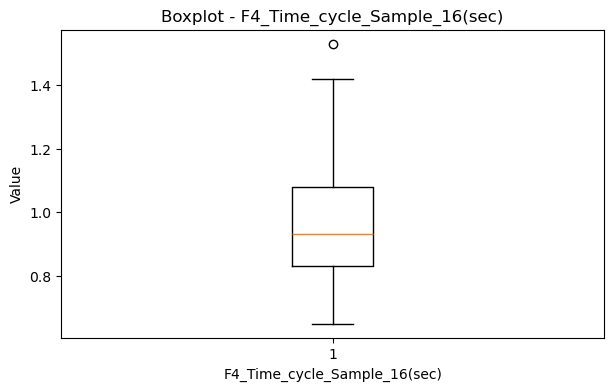

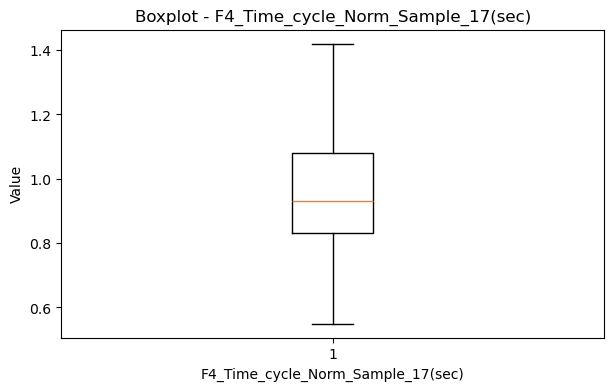

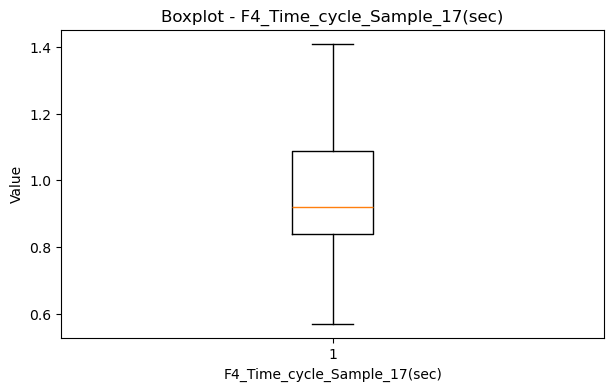

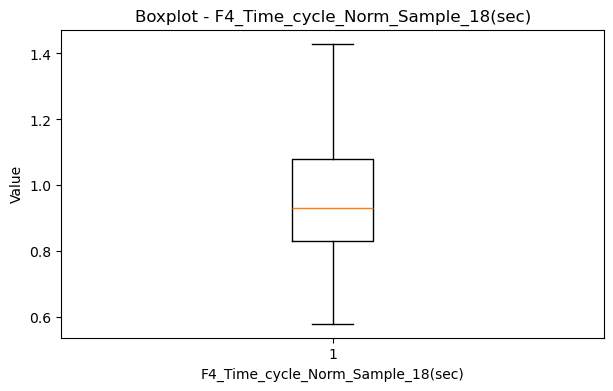

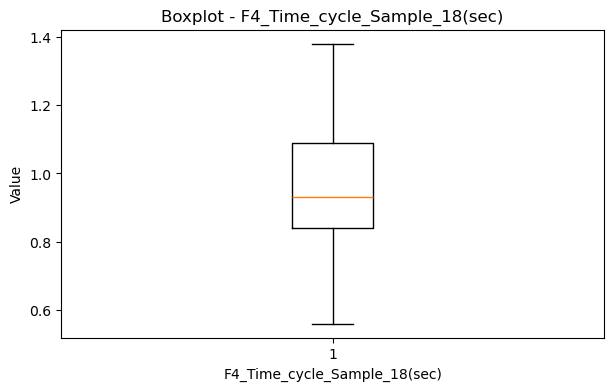

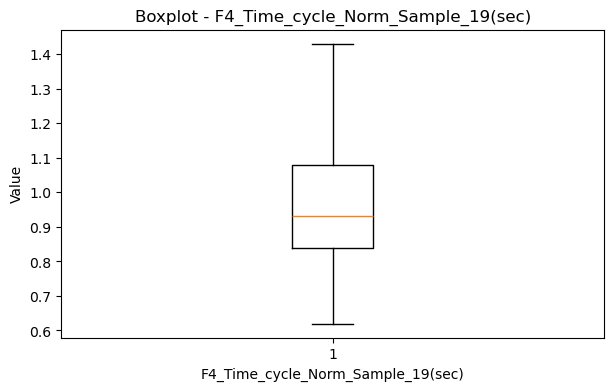

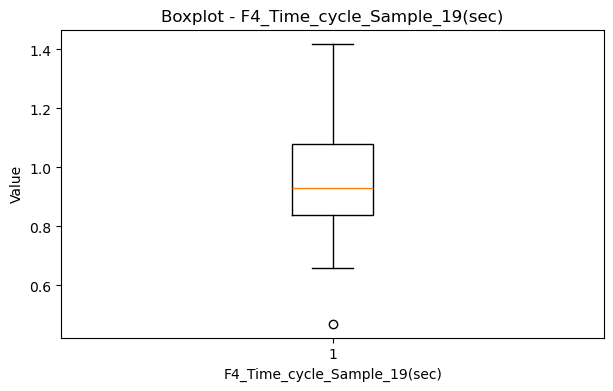

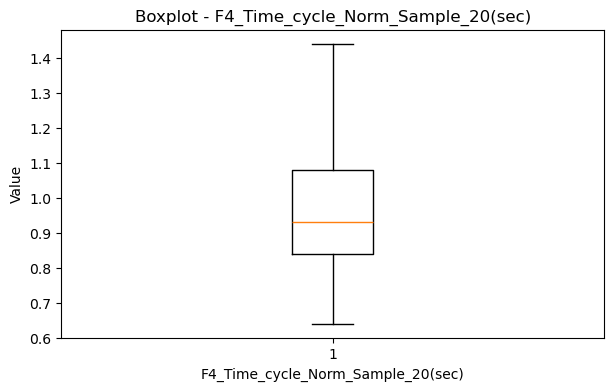

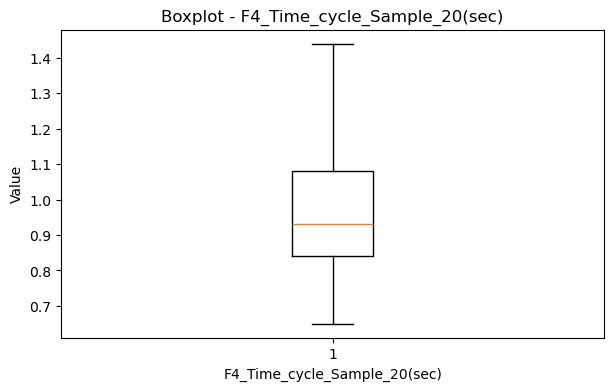

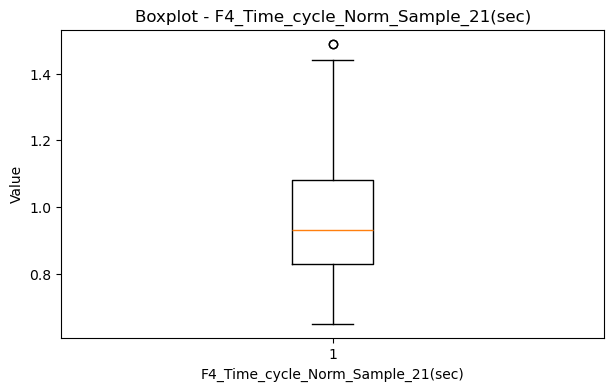

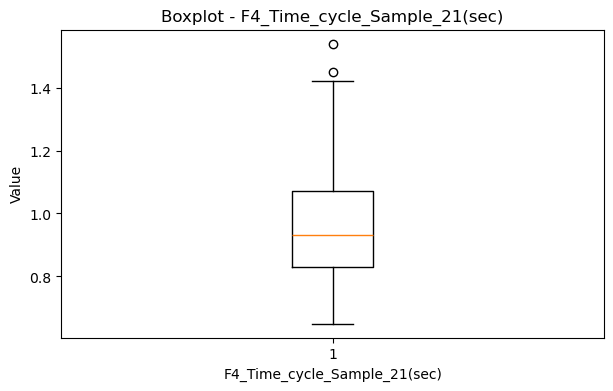

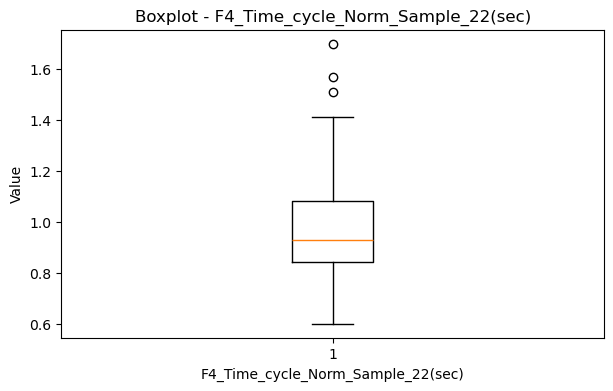

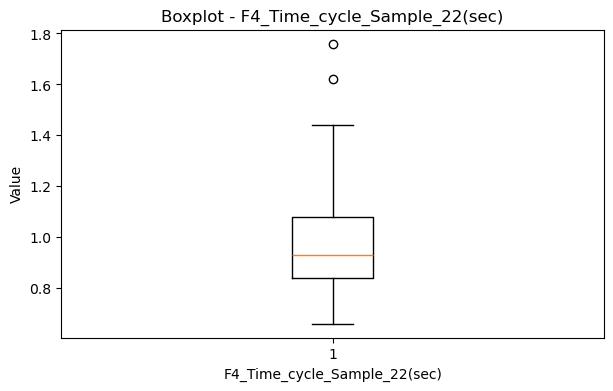

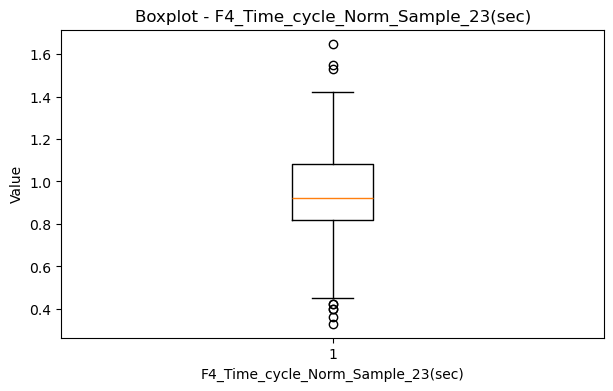

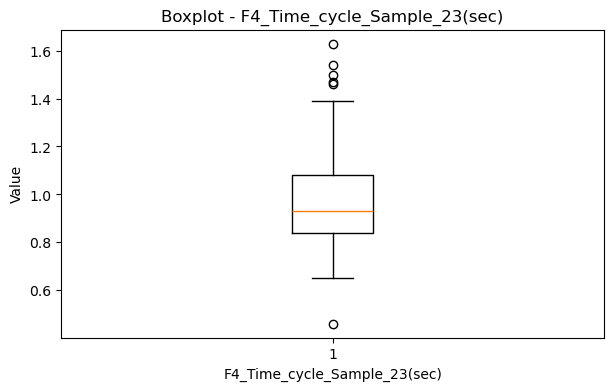

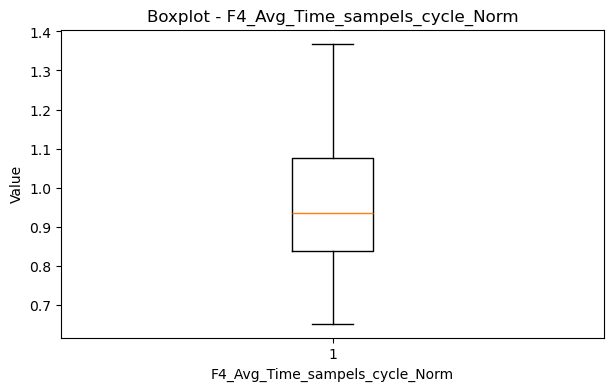

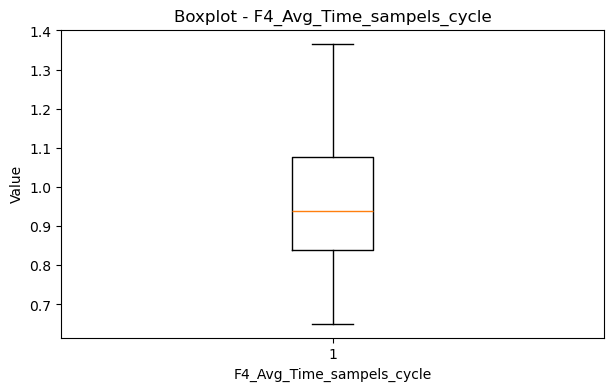

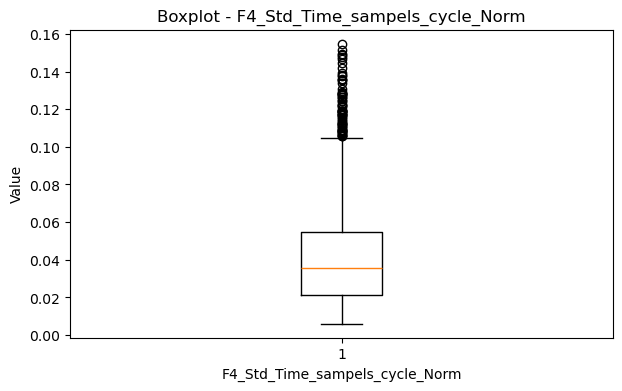

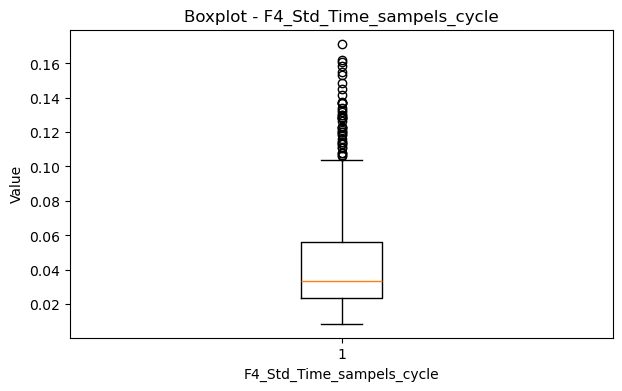

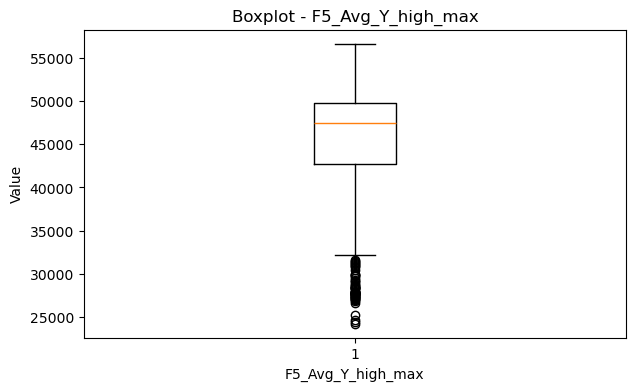

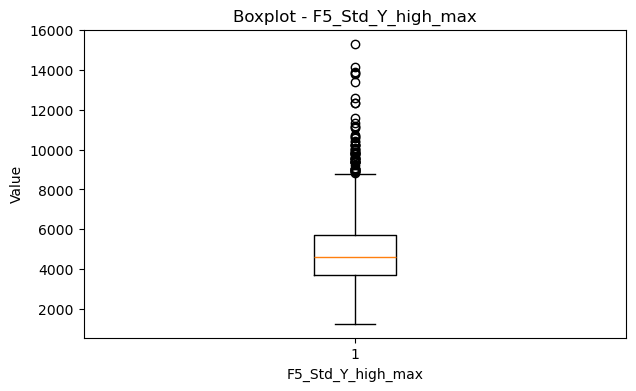

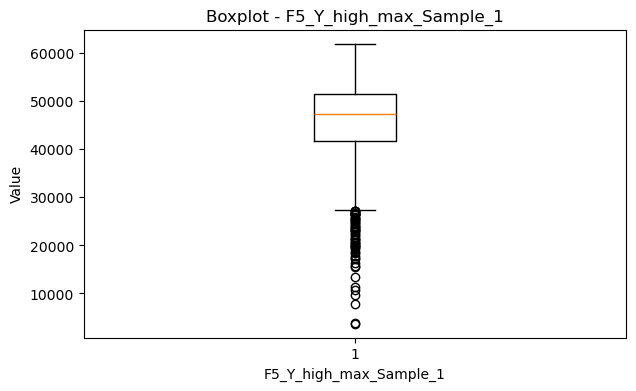

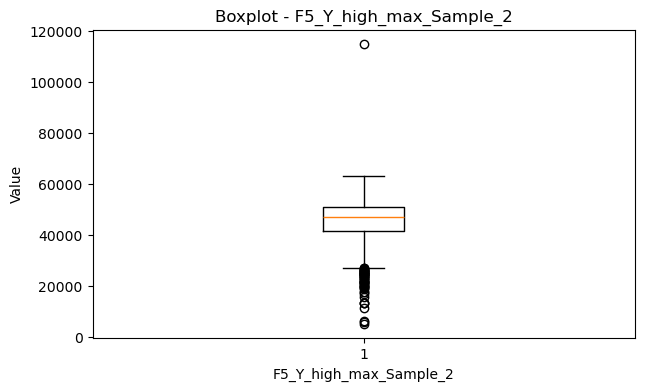

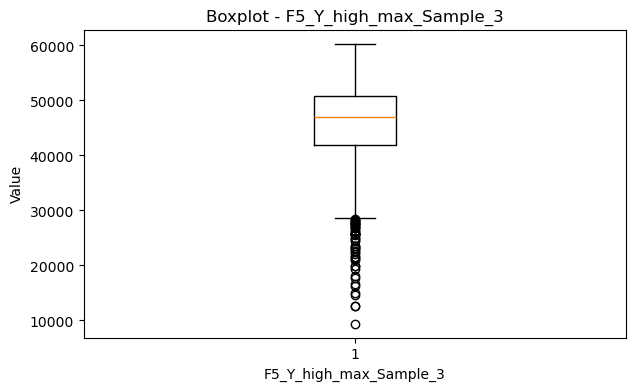

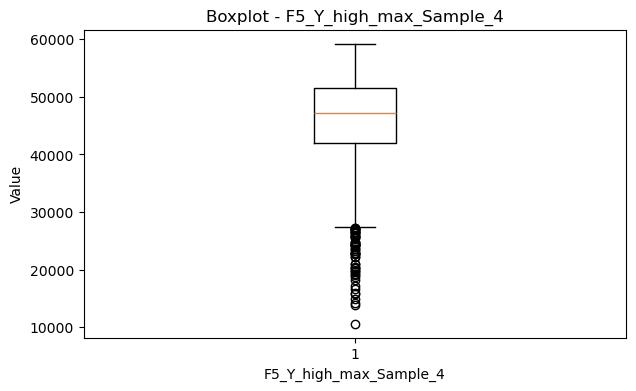

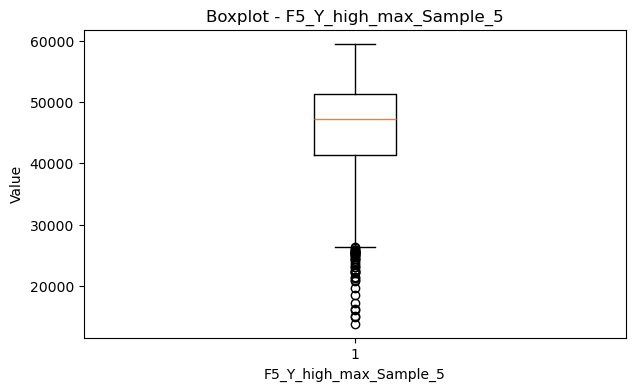

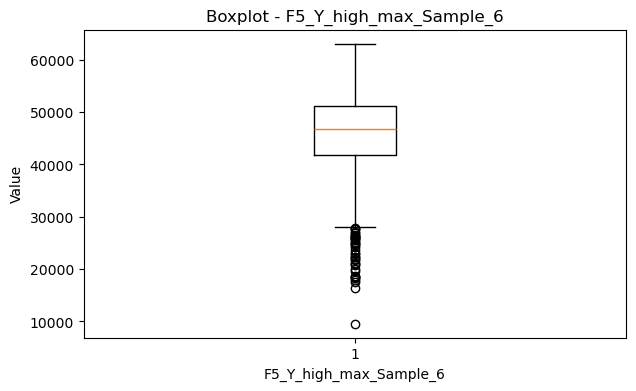

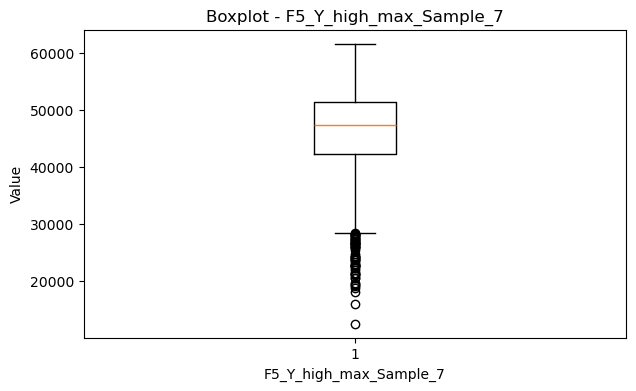

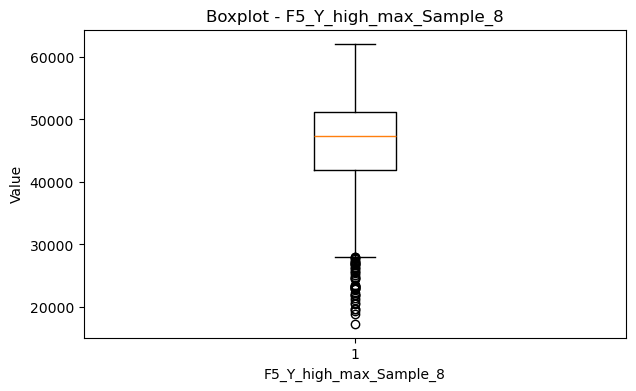

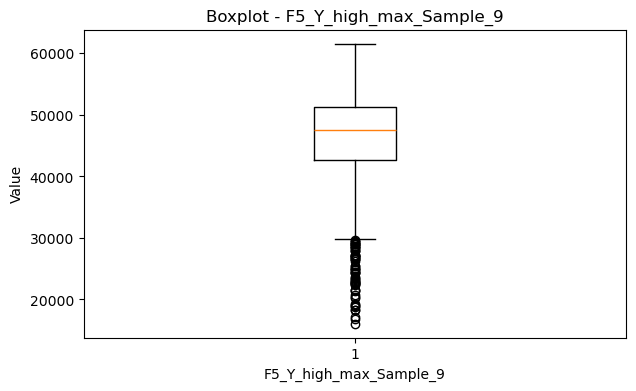

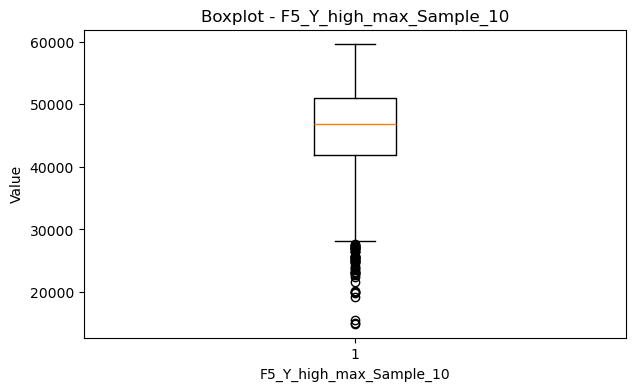

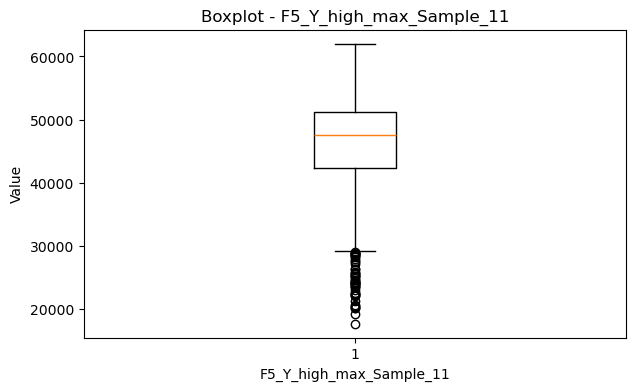

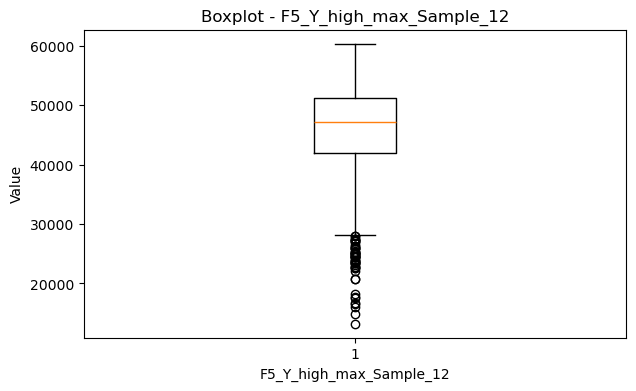

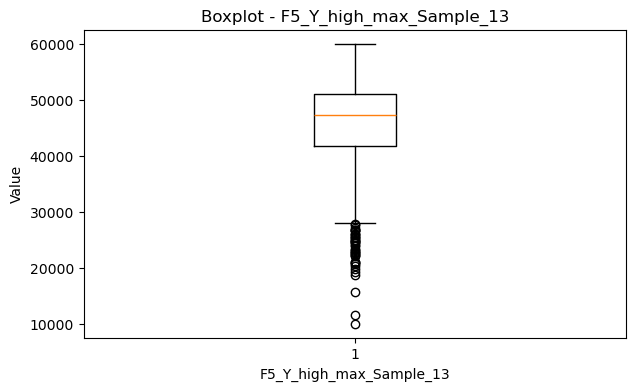

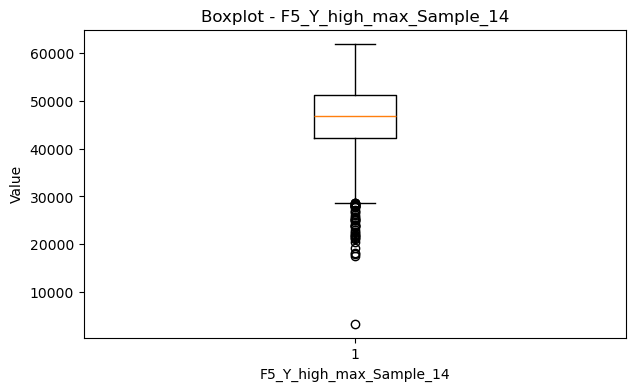

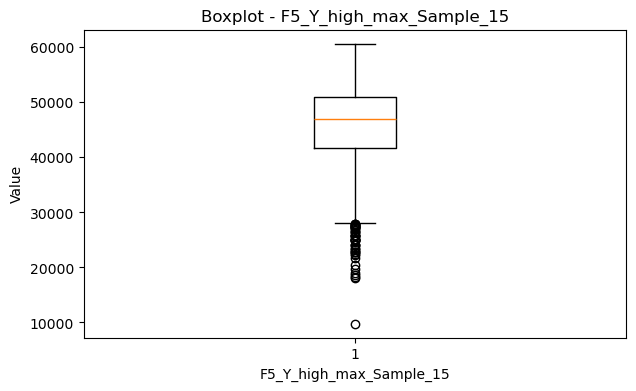

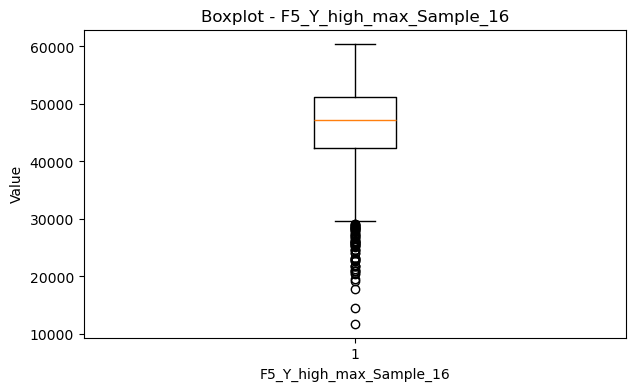

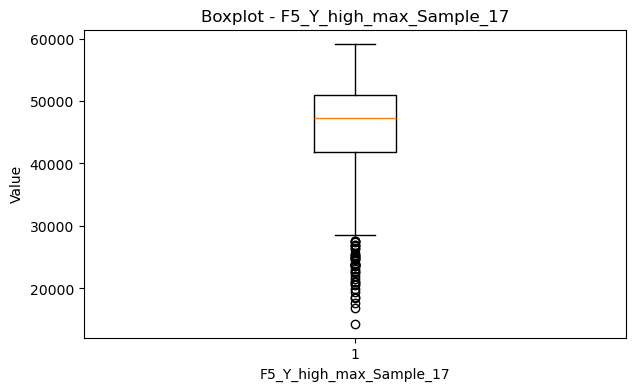

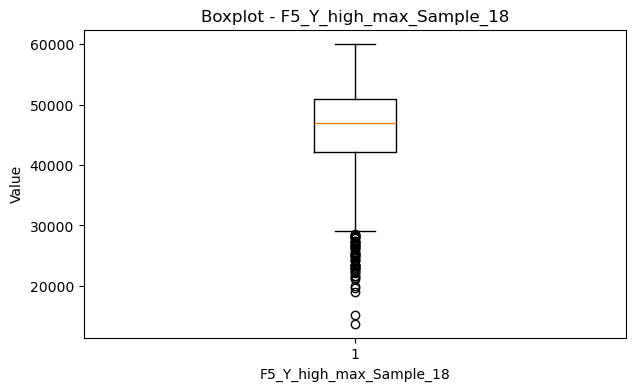

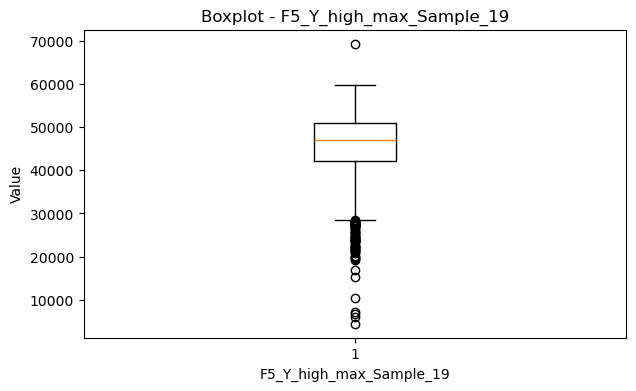

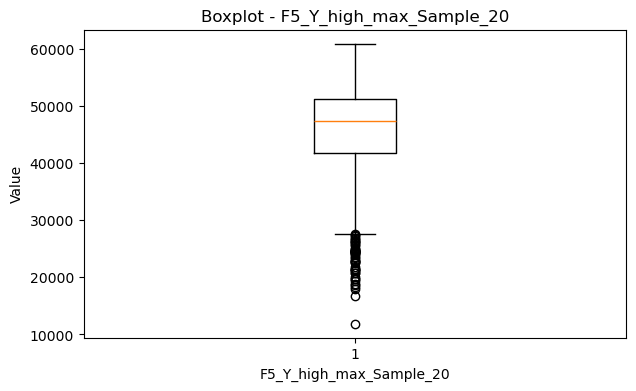

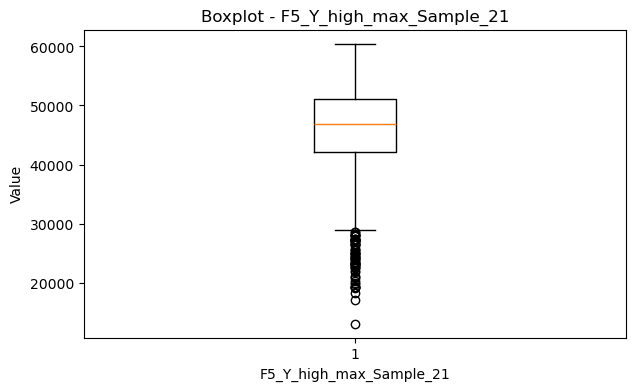

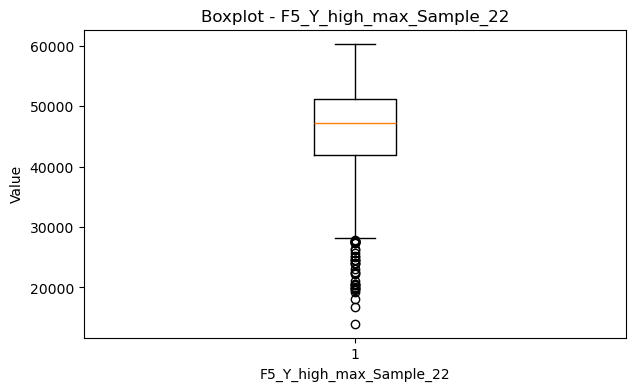

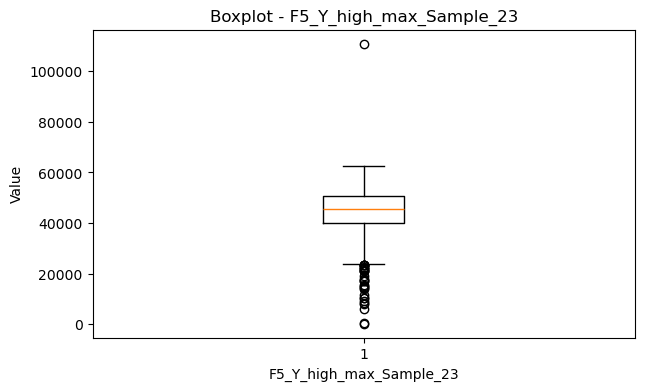

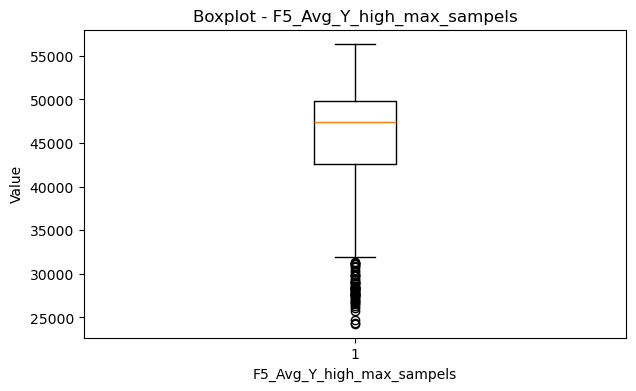

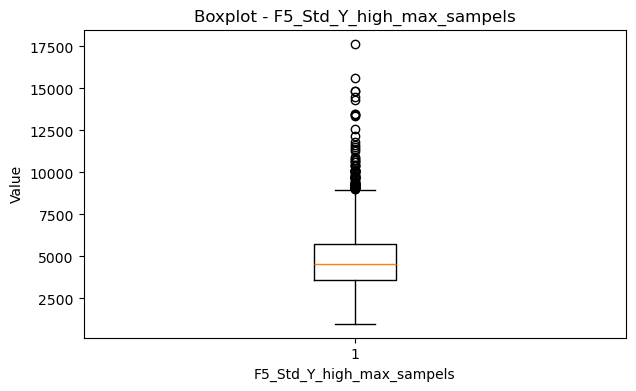

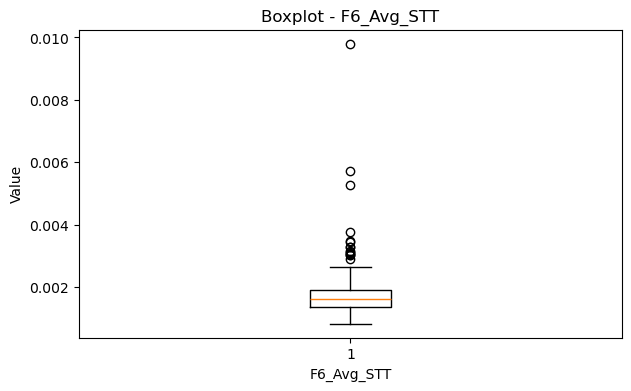

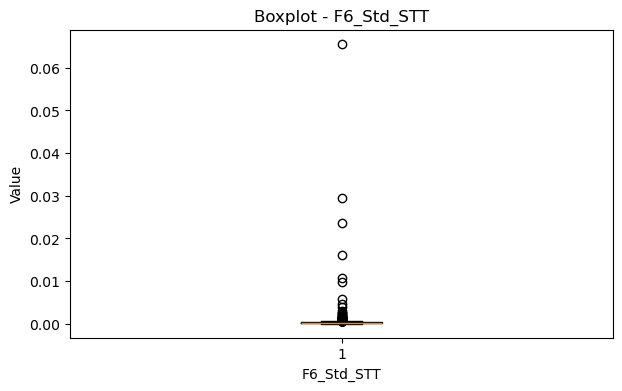

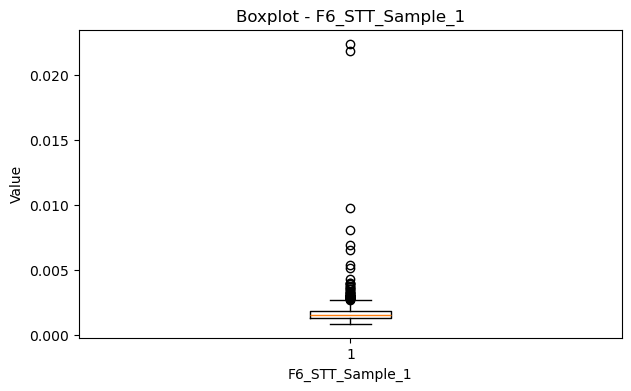

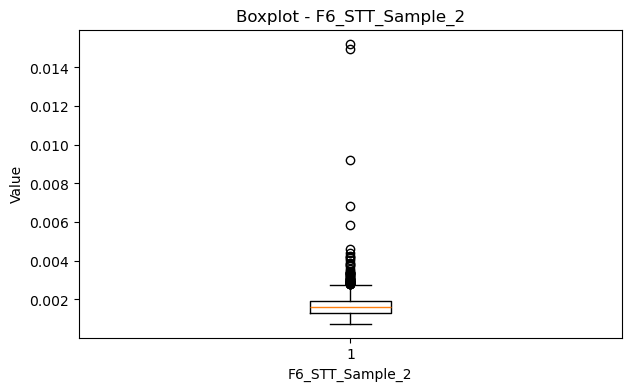

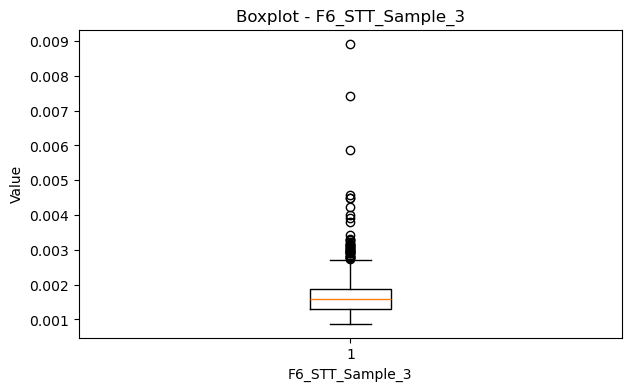

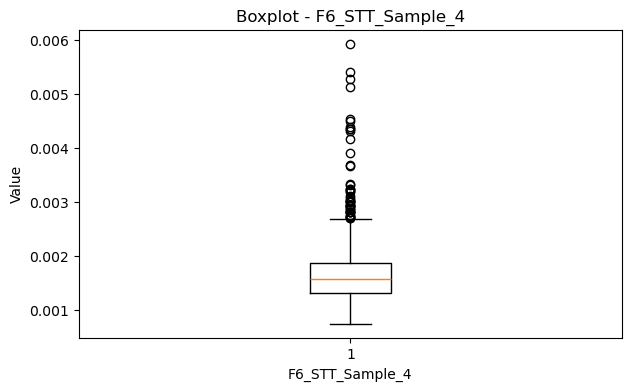

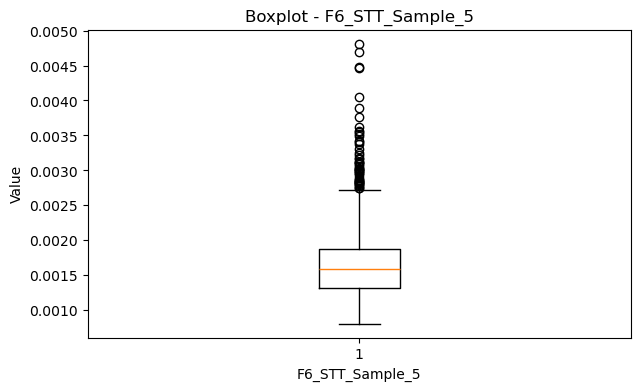

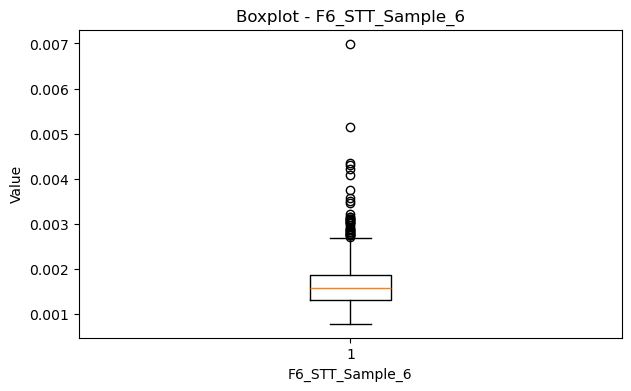

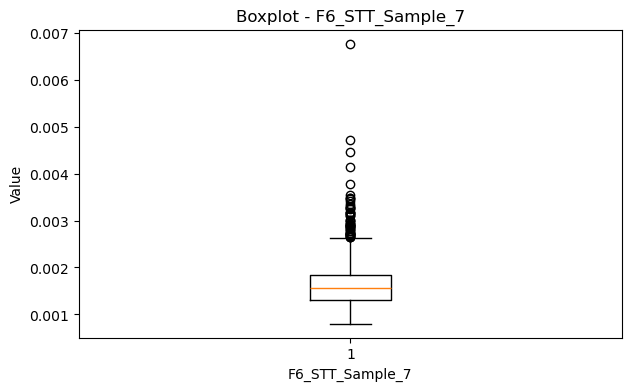

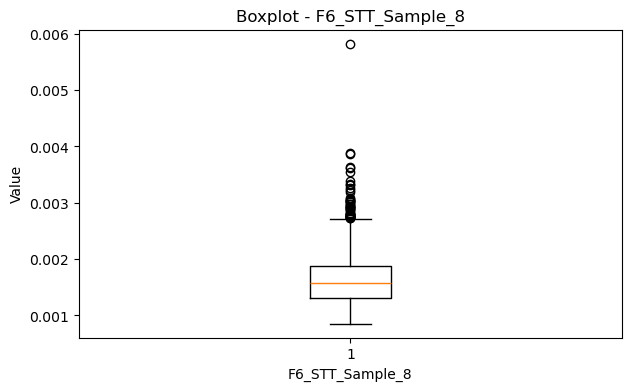

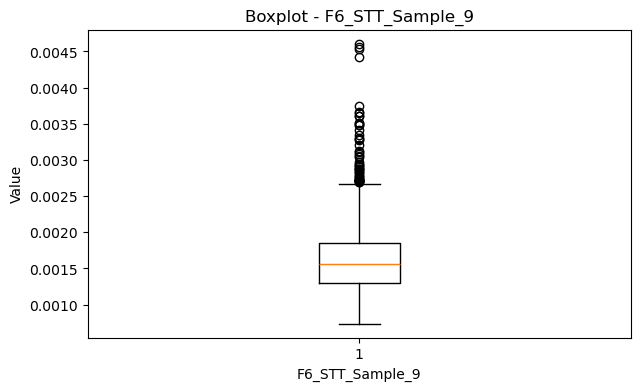

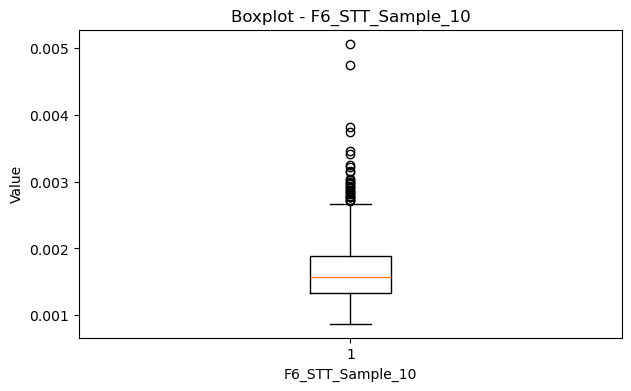

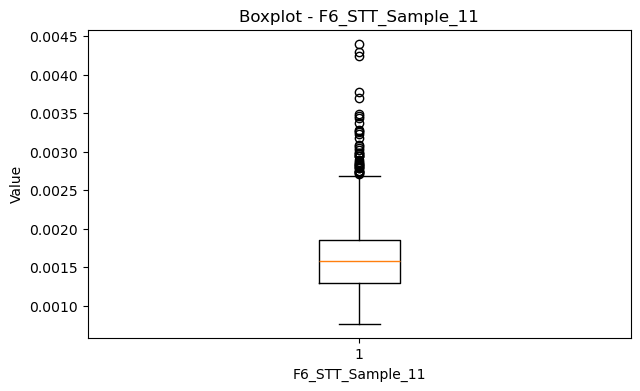

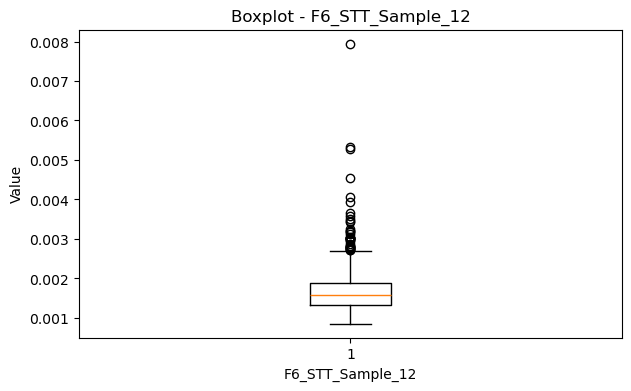

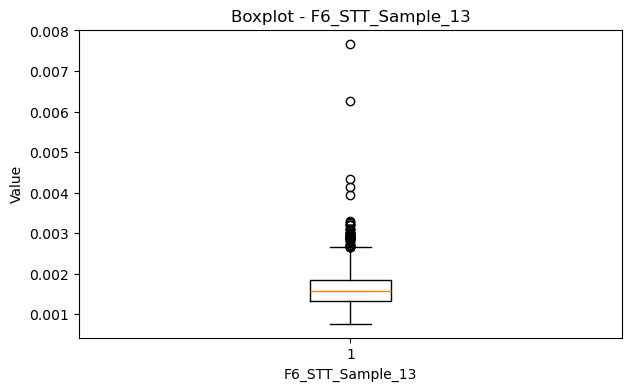

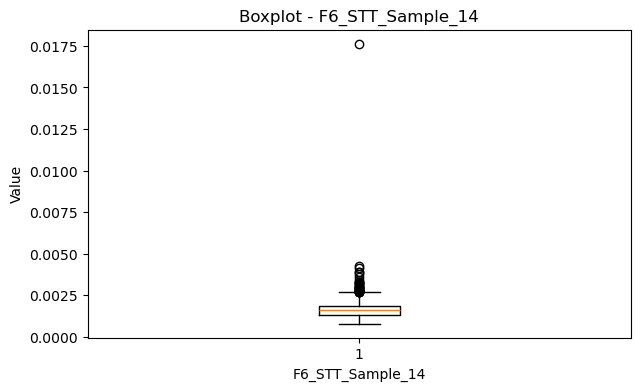

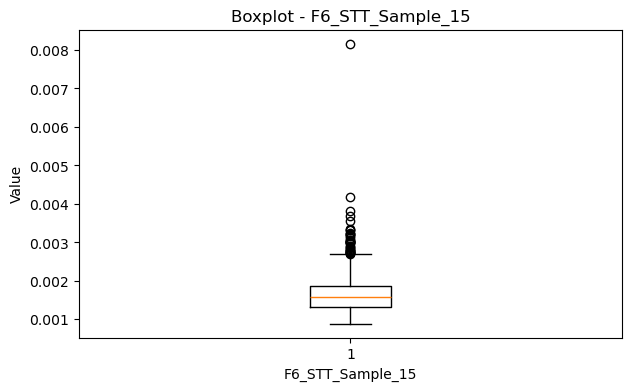

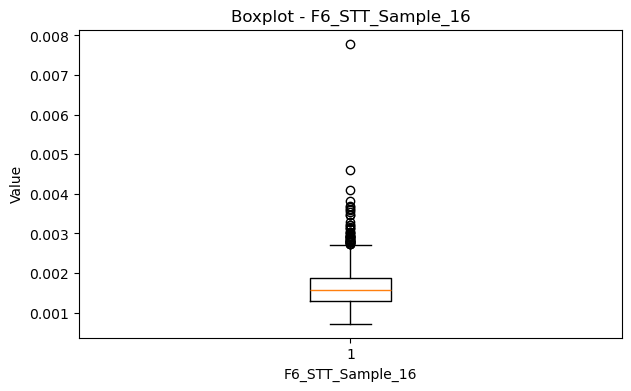

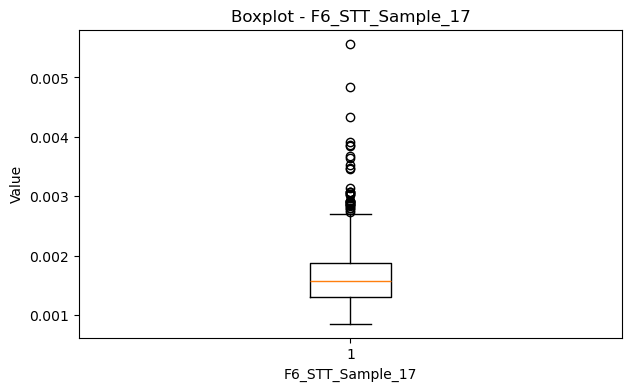

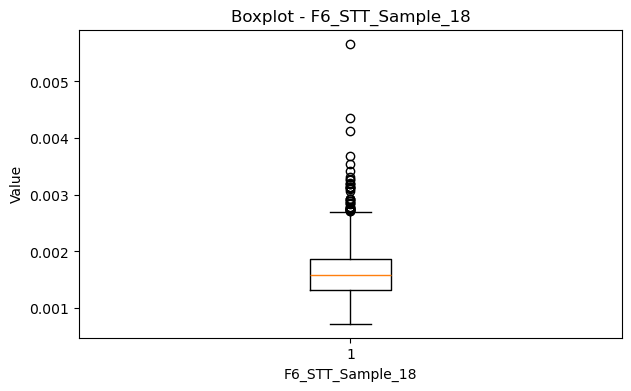

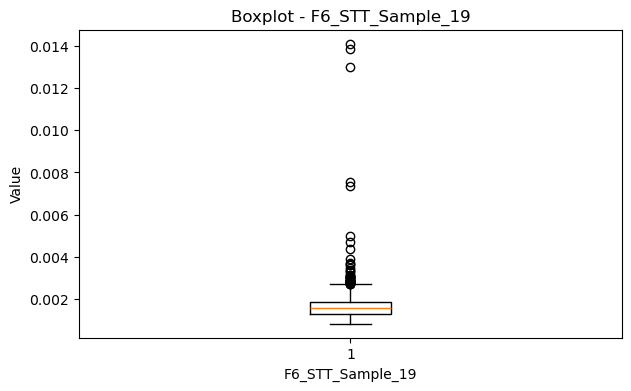

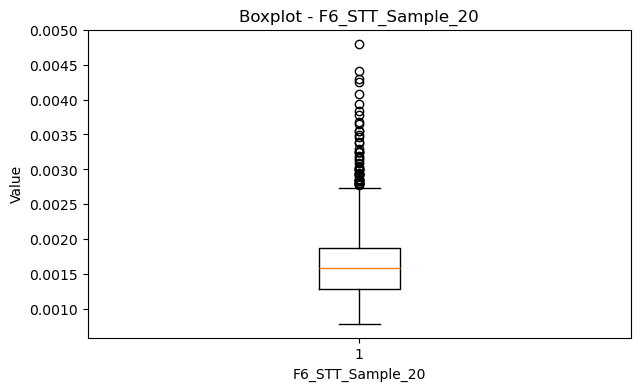

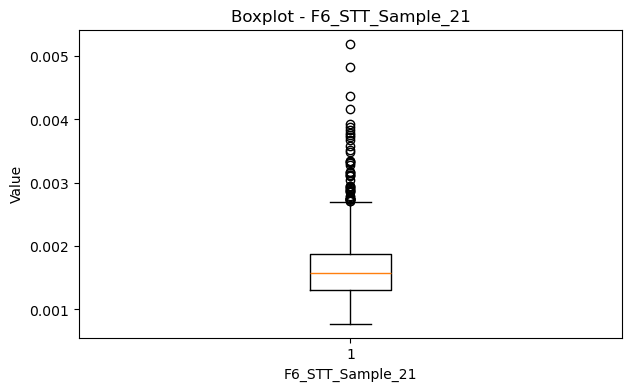

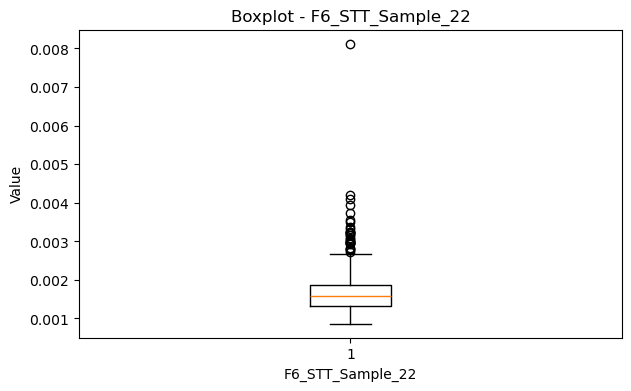

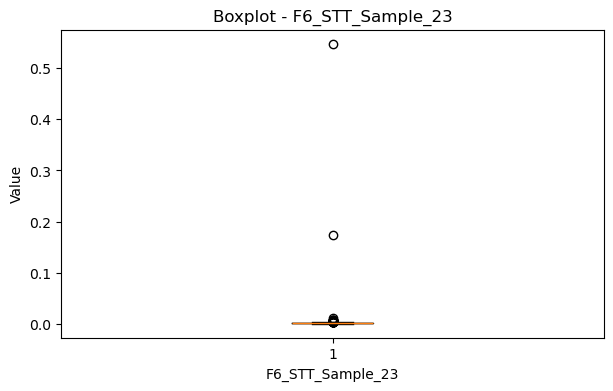

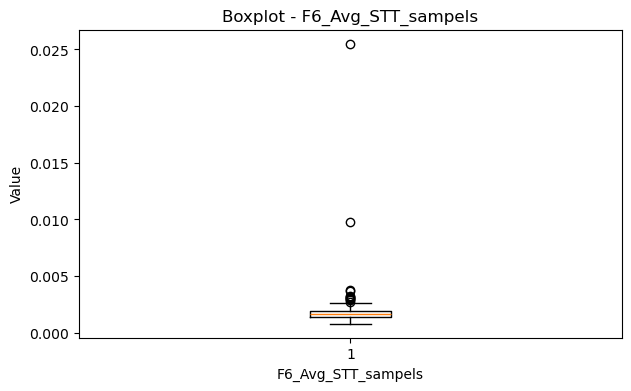

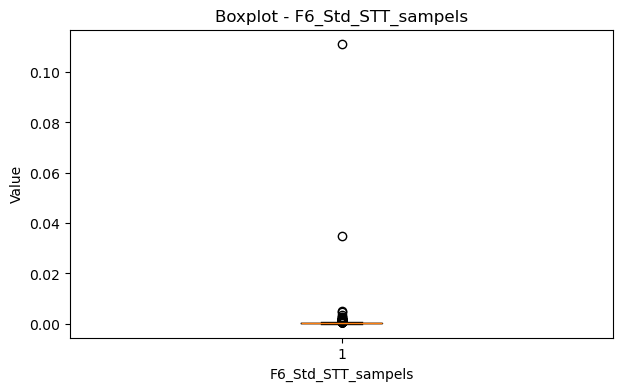

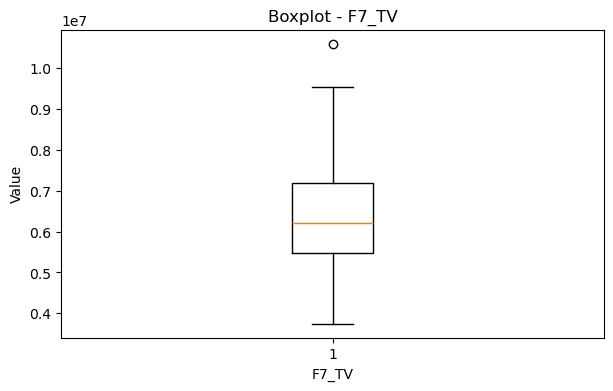

In [ ]:
# Plot boxplots for each numeric feature
for column in combined_train_features_df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(7, 4))
    plt.boxplot(combined_train_features_df[column].dropna())
    plt.xlabel(column)
    plt.ylabel('Value')
    plt.title(f'Boxplot - {column}')
    plt.show()

**Number of outliers by extream value analysis**

In [ ]:
# Find outliers by extreme value analysis
def extreme_values_analysis(df):
    numeric_columns = df.select_dtypes(include=np.number)
    threshold = 3
    extreme_values_count = ((numeric_columns - numeric_columns.mean()) / numeric_columns.std() > threshold).sum()
    print(f'Outliers by extreme values count per column:\n{extreme_values_count}')

extreme_values_analysis(combined_train_features_df)

Outliers by extreme values count per column:
Cycles                 0
L1_MAP                10
L2_DMAP                3
L3_SBP                 7
L4_DSBP                1
                      ..
F6_STT_Sample_22      18
F6_STT_Sample_23       2
F6_Avg_STT_sampels     2
F6_Std_STT_sampels     2
F7_TV                  1
Length: 355, dtype: int64


**Save features dfs**

In [ ]:
#directory_path = 'C:/Users/adior/Documents/Digital Medical Tech - degree/Final Mop Project/Train Files/Proper Windows'
train_directory_path = 'C:/Users/Idan Lichter/OneDrive/Desktop/study/3rd year/Final Project/train features df'
test_directory_path = 'C:/Users/Idan Lichter/OneDrive/Desktop/study/3rd year/Final Project/test features df'

train_file_path = os.path.join(train_directory_path, 'train_features_df.pkl')
test_file_path = os.path.join(test_directory_path, 'test_features_df.pkl')

# Create the directory if it does not exist
os.makedirs(train_directory_path, exist_ok=True)
os.makedirs(test_directory_path, exist_ok=True)

# Save the dictionary to a pickle file
with open(train_file_path, 'wb') as f:
    pickle.dump(combined_train_features_df, f)

with open(test_file_path, 'wb') as f:
    pickle.dump(combined_test_features_df, f)